##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Word embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/word_embeddings">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/word_embeddings.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/word_embeddings.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces word embeddings. It contains complete code to train word embeddings from scratch on a small dataset, and to visualize these embeddings using the [Embedding Projector](http://projector.tensorflow.org) (shown in the image below).

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>

## Representing text as numbers

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing we must do come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, we will look at three strategies for doing so.

### One-hot encodings

As a first idea, we might "one-hot" encode each word in our vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, we will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

To create a vector that contains the encoding of the sentence, we could then concatenate the one-hot vectors for each word.

Key point: This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine we have 10,000 words in the vocabulary. To one-hot encode each word, we would create a vector where 99.99% of the elements are zero.

### Encode each word with a unique number

A second approach we might try is to encode each word using a unique number. Continuing the example above, we could assign 1 to "cat", 2 to "mat", and so on. We could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This appoach is efficient. Instead of a sparse vector, we now have a dense one (where all elements are full).

There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).

* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

## Setup

In [2]:
import tensorflow as tf

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Using the Embedding layer

Keras makes it easy to use word embeddings. Let's take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.


In [4]:
embedding_layer = layers.Embedding(1000, 5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [5]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.0298396 ,  0.02841346,  0.04900734, -0.01906432,  0.01410559],
       [-0.03001586,  0.01602547,  0.00629042, -0.01637052,  0.01647579],
       [ 0.01699759,  0.03675189, -0.01116021,  0.0499186 , -0.01327084]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`


In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's simplest. The [Text Classification with an RNN](text_classification_rnn.ipynb) tutorial is a good next step.

## Learning embeddings from scratch

In this tutorial you will train a sentiment classifier on IMDB movie reviews. In the process, the model will learn embeddings from scratch. We will use to a preprocessed dataset.

To load a text dataset from scratch see the  [Loading text tutorial](../load_data/text.ipynb).

In [7]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Get the encoder (`tfds.features.text.SubwordTextEncoder`), and have a quick look at the vocabulary. 

The "\_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "\_") and partial words which it can use to build larger words:

In [8]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

Movie reviews can be different lengths. We will use the `padded_batch` method to standardize the lengths of the reviews.

In [9]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

As imported, the text of reviews is integer-encoded (each integer represents a specific word or word-part in the vocabulary).

Note the trailing zeros, because the batch is padded to the longest example.

In [10]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 201, 1146,    2, ...,   79, 2858, 7962],
       [  12,  176,  109, ...,    0,    0,    0],
       [ 249,   37,   51, ...,    0,    0,    0],
       ...,
       [ 373, 1669, 7748, ...,    0,    0,    0],
       [5615,  363, 7514, ...,    0,    0,    0],
       [4875, 3466,   23, ...,    0,    0,    0]])

### Create a simple model

We will use the [Keras Sequential API](../../guide/keras) to define our model. In this case it is a "Continuous bag of words" style model.

* Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.

* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

* This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output.  To fix this, see the [masking and padding guide](../../guide/keras/masking_and_padding).

In [11]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10


   1/2500 [..............................] - ETA: 0s - loss: 0.6935 - accuracy: 0.4000

  12/2500 [..............................] - ETA: 10s - loss: 0.6938 - accuracy: 0.4750

  25/2500 [..............................] - ETA: 10s - loss: 0.6929 - accuracy: 0.4560

  38/2500 [..............................] - ETA: 10s - loss: 0.6926 - accuracy: 0.4605

  50/2500 [..............................] - ETA: 10s - loss: 0.6914 - accuracy: 0.4480

  62/2500 [..............................] - ETA: 10s - loss: 0.6920 - accuracy: 0.4597

  75/2500 [..............................] - ETA: 10s - loss: 0.6930 - accuracy: 0.4773

  88/2500 [>.............................] - ETA: 9s - loss: 0.6935 - accuracy: 0.4875 

 101/2500 [>.............................] - ETA: 9s - loss: 0.6934 - accuracy: 0.4901

 114/2500 [>.............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4912

 127/2500 [>.............................] - ETA: 9s - loss: 0.6933 - accuracy: 0.4961

 139/2500 [>.............................] - ETA: 9s - loss: 0.6931 - accuracy: 0.5000

 152/2500 [>.............................] - ETA: 9s - loss: 0.6930 - accuracy: 0.5007

 165/2500 [>.............................] - ETA: 9s - loss: 0.6929 - accuracy: 0.5018

 177/2500 [=>............................] - ETA: 9s - loss: 0.6928 - accuracy: 0.5034

 190/2500 [=>............................] - ETA: 9s - loss: 0.6928 - accuracy: 0.5005

 203/2500 [=>............................] - ETA: 9s - loss: 0.6925 - accuracy: 0.4975

 215/2500 [=>............................] - ETA: 9s - loss: 0.6924 - accuracy: 0.4977

 227/2500 [=>............................] - ETA: 9s - loss: 0.6922 - accuracy: 0.4960

 239/2500 [=>............................] - ETA: 9s - loss: 0.6920 - accuracy: 0.4967

 252/2500 [==>...........................] - ETA: 9s - loss: 0.6919 - accuracy: 0.4980

 265/2500 [==>...........................] - ETA: 9s - loss: 0.6918 - accuracy: 0.4985

 278/2500 [==>...........................] - ETA: 9s - loss: 0.6915 - accuracy: 0.4971

 291/2500 [==>...........................] - ETA: 9s - loss: 0.6913 - accuracy: 0.5014

 303/2500 [==>...........................] - ETA: 9s - loss: 0.6913 - accuracy: 0.5013

 316/2500 [==>...........................] - ETA: 8s - loss: 0.6911 - accuracy: 0.4994

 329/2500 [==>...........................] - ETA: 8s - loss: 0.6908 - accuracy: 0.5021

 342/2500 [===>..........................] - ETA: 8s - loss: 0.6908 - accuracy: 0.5026

 355/2500 [===>..........................] - ETA: 8s - loss: 0.6906 - accuracy: 0.5003

 368/2500 [===>..........................] - ETA: 8s - loss: 0.6904 - accuracy: 0.4976

 381/2500 [===>..........................] - ETA: 8s - loss: 0.6901 - accuracy: 0.4966

 393/2500 [===>..........................] - ETA: 8s - loss: 0.6898 - accuracy: 0.4952

 406/2500 [===>..........................] - ETA: 8s - loss: 0.6899 - accuracy: 0.4975

 419/2500 [====>.........................] - ETA: 8s - loss: 0.6895 - accuracy: 0.4971

 432/2500 [====>.........................] - ETA: 8s - loss: 0.6891 - accuracy: 0.4958

 445/2500 [====>.........................] - ETA: 8s - loss: 0.6889 - accuracy: 0.4960

 458/2500 [====>.........................] - ETA: 8s - loss: 0.6886 - accuracy: 0.4950

 470/2500 [====>.........................] - ETA: 8s - loss: 0.6881 - accuracy: 0.4934

 482/2500 [====>.........................] - ETA: 8s - loss: 0.6879 - accuracy: 0.4938

 495/2500 [====>.........................] - ETA: 8s - loss: 0.6876 - accuracy: 0.4952

 508/2500 [=====>........................] - ETA: 8s - loss: 0.6872 - accuracy: 0.4967

 521/2500 [=====>........................] - ETA: 8s - loss: 0.6868 - accuracy: 0.4952

 533/2500 [=====>........................] - ETA: 8s - loss: 0.6866 - accuracy: 0.4957

 546/2500 [=====>........................] - ETA: 8s - loss: 0.6863 - accuracy: 0.4978

 558/2500 [=====>........................] - ETA: 7s - loss: 0.6859 - accuracy: 0.4973

 570/2500 [=====>........................] - ETA: 7s - loss: 0.6855 - accuracy: 0.4960

 583/2500 [=====>........................] - ETA: 7s - loss: 0.6851 - accuracy: 0.4959

 596/2500 [======>.......................] - ETA: 7s - loss: 0.6847 - accuracy: 0.4965

 609/2500 [======>.......................] - ETA: 7s - loss: 0.6842 - accuracy: 0.4975

 622/2500 [======>.......................] - ETA: 7s - loss: 0.6836 - accuracy: 0.4994

 635/2500 [======>.......................] - ETA: 7s - loss: 0.6829 - accuracy: 0.4989

 647/2500 [======>.......................] - ETA: 7s - loss: 0.6821 - accuracy: 0.5008

 659/2500 [======>.......................] - ETA: 7s - loss: 0.6815 - accuracy: 0.5017

 671/2500 [=======>......................] - ETA: 7s - loss: 0.6811 - accuracy: 0.5025

 684/2500 [=======>......................] - ETA: 7s - loss: 0.6804 - accuracy: 0.5012

 697/2500 [=======>......................] - ETA: 7s - loss: 0.6796 - accuracy: 0.5039

 710/2500 [=======>......................] - ETA: 7s - loss: 0.6787 - accuracy: 0.5059

 723/2500 [=======>......................] - ETA: 7s - loss: 0.6781 - accuracy: 0.5075

 735/2500 [=======>......................] - ETA: 7s - loss: 0.6773 - accuracy: 0.5078

 747/2500 [=======>......................] - ETA: 7s - loss: 0.6766 - accuracy: 0.5083

 760/2500 [========>.....................] - ETA: 7s - loss: 0.6756 - accuracy: 0.5093

 773/2500 [========>.....................] - ETA: 7s - loss: 0.6750 - accuracy: 0.5105

 786/2500 [========>.....................] - ETA: 7s - loss: 0.6739 - accuracy: 0.5111

 799/2500 [========>.....................] - ETA: 6s - loss: 0.6730 - accuracy: 0.5125

 812/2500 [========>.....................] - ETA: 6s - loss: 0.6720 - accuracy: 0.5135

 824/2500 [========>.....................] - ETA: 6s - loss: 0.6712 - accuracy: 0.5136

 837/2500 [=========>....................] - ETA: 6s - loss: 0.6702 - accuracy: 0.5160

 850/2500 [=========>....................] - ETA: 6s - loss: 0.6687 - accuracy: 0.5162

 863/2500 [=========>....................] - ETA: 6s - loss: 0.6679 - accuracy: 0.5183

 876/2500 [=========>....................] - ETA: 6s - loss: 0.6668 - accuracy: 0.5200

 889/2500 [=========>....................] - ETA: 6s - loss: 0.6661 - accuracy: 0.5208

 902/2500 [=========>....................] - ETA: 6s - loss: 0.6641 - accuracy: 0.5229

 914/2500 [=========>....................] - ETA: 6s - loss: 0.6632 - accuracy: 0.5241

 927/2500 [==========>...................] - ETA: 6s - loss: 0.6618 - accuracy: 0.5259

 940/2500 [==========>...................] - ETA: 6s - loss: 0.6599 - accuracy: 0.5280

 953/2500 [==========>...................] - ETA: 6s - loss: 0.6586 - accuracy: 0.5300

 965/2500 [==========>...................] - ETA: 6s - loss: 0.6575 - accuracy: 0.5317

 978/2500 [==========>...................] - ETA: 6s - loss: 0.6562 - accuracy: 0.5330

 990/2500 [==========>...................] - ETA: 6s - loss: 0.6546 - accuracy: 0.5352

1002/2500 [===========>..................] - ETA: 6s - loss: 0.6530 - accuracy: 0.5380

1015/2500 [===========>..................] - ETA: 6s - loss: 0.6510 - accuracy: 0.5406

1028/2500 [===========>..................] - ETA: 6s - loss: 0.6495 - accuracy: 0.5415

1041/2500 [===========>..................] - ETA: 5s - loss: 0.6480 - accuracy: 0.5447

1054/2500 [===========>..................] - ETA: 5s - loss: 0.6462 - accuracy: 0.5460

1068/2500 [===========>..................] - ETA: 5s - loss: 0.6444 - accuracy: 0.5483

1081/2500 [===========>..................] - ETA: 5s - loss: 0.6430 - accuracy: 0.5509

1093/2500 [============>.................] - ETA: 5s - loss: 0.6411 - accuracy: 0.5528

1106/2500 [============>.................] - ETA: 5s - loss: 0.6392 - accuracy: 0.5546

1119/2500 [============>.................] - ETA: 5s - loss: 0.6377 - accuracy: 0.5570

1131/2500 [============>.................] - ETA: 5s - loss: 0.6367 - accuracy: 0.5587

1144/2500 [============>.................] - ETA: 5s - loss: 0.6348 - accuracy: 0.5601

1157/2500 [============>.................] - ETA: 5s - loss: 0.6334 - accuracy: 0.5623

1169/2500 [=============>................] - ETA: 5s - loss: 0.6321 - accuracy: 0.5649

1181/2500 [=============>................] - ETA: 5s - loss: 0.6301 - accuracy: 0.5670

1194/2500 [=============>................] - ETA: 5s - loss: 0.6290 - accuracy: 0.5686

1207/2500 [=============>................] - ETA: 5s - loss: 0.6273 - accuracy: 0.5708

1219/2500 [=============>................] - ETA: 5s - loss: 0.6256 - accuracy: 0.5725

1232/2500 [=============>................] - ETA: 5s - loss: 0.6245 - accuracy: 0.5735

1245/2500 [=============>................] - ETA: 5s - loss: 0.6232 - accuracy: 0.5754

1257/2500 [==============>...............] - ETA: 5s - loss: 0.6221 - accuracy: 0.5769

1270/2500 [==============>...............] - ETA: 5s - loss: 0.6203 - accuracy: 0.5791

1283/2500 [==============>...............] - ETA: 5s - loss: 0.6188 - accuracy: 0.5804

1296/2500 [==============>...............] - ETA: 4s - loss: 0.6171 - accuracy: 0.5833

1309/2500 [==============>...............] - ETA: 4s - loss: 0.6158 - accuracy: 0.5840

1322/2500 [==============>...............] - ETA: 4s - loss: 0.6136 - accuracy: 0.5867

1335/2500 [===============>..............] - ETA: 4s - loss: 0.6115 - accuracy: 0.5891

1347/2500 [===============>..............] - ETA: 4s - loss: 0.6103 - accuracy: 0.5898

1359/2500 [===============>..............] - ETA: 4s - loss: 0.6088 - accuracy: 0.5919

1372/2500 [===============>..............] - ETA: 4s - loss: 0.6074 - accuracy: 0.5942

1385/2500 [===============>..............] - ETA: 4s - loss: 0.6061 - accuracy: 0.5957

1398/2500 [===============>..............] - ETA: 4s - loss: 0.6048 - accuracy: 0.5970

1411/2500 [===============>..............] - ETA: 4s - loss: 0.6037 - accuracy: 0.5982

1423/2500 [================>.............] - ETA: 4s - loss: 0.6025 - accuracy: 0.5994

1435/2500 [================>.............] - ETA: 4s - loss: 0.6011 - accuracy: 0.6011

1448/2500 [================>.............] - ETA: 4s - loss: 0.5999 - accuracy: 0.6032

1461/2500 [================>.............] - ETA: 4s - loss: 0.5981 - accuracy: 0.6049

1473/2500 [================>.............] - ETA: 4s - loss: 0.5966 - accuracy: 0.6060

1486/2500 [================>.............] - ETA: 4s - loss: 0.5948 - accuracy: 0.6081

1499/2500 [================>.............] - ETA: 4s - loss: 0.5940 - accuracy: 0.6095

1511/2500 [=================>............] - ETA: 4s - loss: 0.5930 - accuracy: 0.6103

1523/2500 [=================>............] - ETA: 4s - loss: 0.5914 - accuracy: 0.6118

1536/2500 [=================>............] - ETA: 3s - loss: 0.5904 - accuracy: 0.6133

1549/2500 [=================>............] - ETA: 3s - loss: 0.5890 - accuracy: 0.6150

1562/2500 [=================>............] - ETA: 3s - loss: 0.5876 - accuracy: 0.6169

1575/2500 [=================>............] - ETA: 3s - loss: 0.5859 - accuracy: 0.6185

1588/2500 [==================>...........] - ETA: 3s - loss: 0.5851 - accuracy: 0.6198

1600/2500 [==================>...........] - ETA: 3s - loss: 0.5837 - accuracy: 0.6212

1612/2500 [==================>...........] - ETA: 3s - loss: 0.5821 - accuracy: 0.6228

1624/2500 [==================>...........] - ETA: 3s - loss: 0.5810 - accuracy: 0.6240

1637/2500 [==================>...........] - ETA: 3s - loss: 0.5798 - accuracy: 0.6257

1650/2500 [==================>...........] - ETA: 3s - loss: 0.5784 - accuracy: 0.6268

1663/2500 [==================>...........] - ETA: 3s - loss: 0.5768 - accuracy: 0.6289

1676/2500 [===================>..........] - ETA: 3s - loss: 0.5757 - accuracy: 0.6301

1688/2500 [===================>..........] - ETA: 3s - loss: 0.5741 - accuracy: 0.6312

1700/2500 [===================>..........] - ETA: 3s - loss: 0.5732 - accuracy: 0.6322

1713/2500 [===================>..........] - ETA: 3s - loss: 0.5718 - accuracy: 0.6335

1726/2500 [===================>..........] - ETA: 3s - loss: 0.5704 - accuracy: 0.6351

1739/2500 [===================>..........] - ETA: 3s - loss: 0.5690 - accuracy: 0.6363

1752/2500 [====================>.........] - ETA: 3s - loss: 0.5679 - accuracy: 0.6376

1765/2500 [====================>.........] - ETA: 3s - loss: 0.5669 - accuracy: 0.6389

1778/2500 [====================>.........] - ETA: 2s - loss: 0.5653 - accuracy: 0.6404

1790/2500 [====================>.........] - ETA: 2s - loss: 0.5642 - accuracy: 0.6418

1803/2500 [====================>.........] - ETA: 2s - loss: 0.5629 - accuracy: 0.6429

1816/2500 [====================>.........] - ETA: 2s - loss: 0.5614 - accuracy: 0.6443

1829/2500 [====================>.........] - ETA: 2s - loss: 0.5605 - accuracy: 0.6457

1842/2500 [=====================>........] - ETA: 2s - loss: 0.5597 - accuracy: 0.6464

1854/2500 [=====================>........] - ETA: 2s - loss: 0.5586 - accuracy: 0.6476

1866/2500 [=====================>........] - ETA: 2s - loss: 0.5575 - accuracy: 0.6490

1879/2500 [=====================>........] - ETA: 2s - loss: 0.5566 - accuracy: 0.6503

1892/2500 [=====================>........] - ETA: 2s - loss: 0.5554 - accuracy: 0.6515

1905/2500 [=====================>........] - ETA: 2s - loss: 0.5543 - accuracy: 0.6524

1918/2500 [======================>.......] - ETA: 2s - loss: 0.5528 - accuracy: 0.6539

1931/2500 [======================>.......] - ETA: 2s - loss: 0.5517 - accuracy: 0.6549

1943/2500 [======================>.......] - ETA: 2s - loss: 0.5507 - accuracy: 0.6558

1955/2500 [======================>.......] - ETA: 2s - loss: 0.5496 - accuracy: 0.6569

1968/2500 [======================>.......] - ETA: 2s - loss: 0.5487 - accuracy: 0.6578

1981/2500 [======================>.......] - ETA: 2s - loss: 0.5478 - accuracy: 0.6587

1994/2500 [======================>.......] - ETA: 2s - loss: 0.5471 - accuracy: 0.6596

2007/2500 [=======================>......] - ETA: 2s - loss: 0.5461 - accuracy: 0.6610

2020/2500 [=======================>......] - ETA: 1s - loss: 0.5446 - accuracy: 0.6624

2032/2500 [=======================>......] - ETA: 1s - loss: 0.5439 - accuracy: 0.6637

2045/2500 [=======================>......] - ETA: 1s - loss: 0.5428 - accuracy: 0.6649

2058/2500 [=======================>......] - ETA: 1s - loss: 0.5416 - accuracy: 0.6660

2071/2500 [=======================>......] - ETA: 1s - loss: 0.5406 - accuracy: 0.6670

2084/2500 [========================>.....] - ETA: 1s - loss: 0.5398 - accuracy: 0.6681

2097/2500 [========================>.....] - ETA: 1s - loss: 0.5387 - accuracy: 0.6691

2109/2500 [========================>.....] - ETA: 1s - loss: 0.5375 - accuracy: 0.6704

2121/2500 [========================>.....] - ETA: 1s - loss: 0.5360 - accuracy: 0.6715

2133/2500 [========================>.....] - ETA: 1s - loss: 0.5353 - accuracy: 0.6725

2146/2500 [========================>.....] - ETA: 1s - loss: 0.5342 - accuracy: 0.6736

2159/2500 [========================>.....] - ETA: 1s - loss: 0.5334 - accuracy: 0.6744

2172/2500 [=========================>....] - ETA: 1s - loss: 0.5321 - accuracy: 0.6757

2185/2500 [=========================>....] - ETA: 1s - loss: 0.5311 - accuracy: 0.6767

2197/2500 [=========================>....] - ETA: 1s - loss: 0.5302 - accuracy: 0.6772

2209/2500 [=========================>....] - ETA: 1s - loss: 0.5294 - accuracy: 0.6779

2222/2500 [=========================>....] - ETA: 1s - loss: 0.5282 - accuracy: 0.6789

2235/2500 [=========================>....] - ETA: 1s - loss: 0.5274 - accuracy: 0.6796

2248/2500 [=========================>....] - ETA: 1s - loss: 0.5261 - accuracy: 0.6808

2261/2500 [==========================>...] - ETA: 0s - loss: 0.5252 - accuracy: 0.6817

2274/2500 [==========================>...] - ETA: 0s - loss: 0.5244 - accuracy: 0.6826

2286/2500 [==========================>...] - ETA: 0s - loss: 0.5237 - accuracy: 0.6834

2298/2500 [==========================>...] - ETA: 0s - loss: 0.5228 - accuracy: 0.6843

2311/2500 [==========================>...] - ETA: 0s - loss: 0.5217 - accuracy: 0.6852

2324/2500 [==========================>...] - ETA: 0s - loss: 0.5205 - accuracy: 0.6864

2337/2500 [===========================>..] - ETA: 0s - loss: 0.5193 - accuracy: 0.6874

2350/2500 [===========================>..] - ETA: 0s - loss: 0.5183 - accuracy: 0.6883

2363/2500 [===========================>..] - ETA: 0s - loss: 0.5175 - accuracy: 0.6889

2375/2500 [===========================>..] - ETA: 0s - loss: 0.5165 - accuracy: 0.6897

2388/2500 [===========================>..] - ETA: 0s - loss: 0.5155 - accuracy: 0.6908

2401/2500 [===========================>..] - ETA: 0s - loss: 0.5145 - accuracy: 0.6919

2415/2500 [===========================>..] - ETA: 0s - loss: 0.5133 - accuracy: 0.6930

2429/2500 [============================>.] - ETA: 0s - loss: 0.5128 - accuracy: 0.6937

2443/2500 [============================>.] - ETA: 0s - loss: 0.5125 - accuracy: 0.6939

2456/2500 [============================>.] - ETA: 0s - loss: 0.5112 - accuracy: 0.6948

2469/2500 [============================>.] - ETA: 0s - loss: 0.5103 - accuracy: 0.6957

2482/2500 [============================>.] - ETA: 0s - loss: 0.5097 - accuracy: 0.6963

2496/2500 [============================>.] - ETA: 0s - loss: 0.5088 - accuracy: 0.6972

2500/2500 [==============================] - 10s 4ms/step - loss: 0.5084 - accuracy: 0.6976 - val_loss: 0.4872 - val_accuracy: 0.7900


Epoch 2/10
   1/2500 [..............................] - ETA: 0s - loss: 0.1731 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 9s - loss: 0.3361 - accuracy: 0.8929

  27/2500 [..............................] - ETA: 9s - loss: 0.3332 - accuracy: 0.8704

  40/2500 [..............................] - ETA: 9s - loss: 0.3388 - accuracy: 0.8700

  53/2500 [..............................] - ETA: 9s - loss: 0.3389 - accuracy: 0.8585

  66/2500 [..............................] - ETA: 9s - loss: 0.3444 - accuracy: 0.8561

  79/2500 [..............................] - ETA: 9s - loss: 0.3341 - accuracy: 0.8608

  92/2500 [>.............................] - ETA: 9s - loss: 0.3329 - accuracy: 0.8533

 105/2500 [>.............................] - ETA: 9s - loss: 0.3313 - accuracy: 0.8552

 117/2500 [>.............................] - ETA: 9s - loss: 0.3302 - accuracy: 0.8581

 129/2500 [>.............................] - ETA: 9s - loss: 0.3323 - accuracy: 0.8574

 142/2500 [>.............................] - ETA: 9s - loss: 0.3364 - accuracy: 0.8549

 154/2500 [>.............................] - ETA: 9s - loss: 0.3319 - accuracy: 0.8591

 166/2500 [>.............................] - ETA: 9s - loss: 0.3329 - accuracy: 0.8566

 179/2500 [=>............................] - ETA: 9s - loss: 0.3296 - accuracy: 0.8592

 192/2500 [=>............................] - ETA: 9s - loss: 0.3279 - accuracy: 0.8599

 206/2500 [=>............................] - ETA: 9s - loss: 0.3306 - accuracy: 0.8617

 219/2500 [=>............................] - ETA: 9s - loss: 0.3311 - accuracy: 0.8580

 232/2500 [=>............................] - ETA: 9s - loss: 0.3287 - accuracy: 0.8586

 245/2500 [=>............................] - ETA: 9s - loss: 0.3295 - accuracy: 0.8592

 257/2500 [==>...........................] - ETA: 9s - loss: 0.3285 - accuracy: 0.8588

 270/2500 [==>...........................] - ETA: 9s - loss: 0.3261 - accuracy: 0.8619

 283/2500 [==>...........................] - ETA: 8s - loss: 0.3268 - accuracy: 0.8604

 296/2500 [==>...........................] - ETA: 8s - loss: 0.3251 - accuracy: 0.8622

 309/2500 [==>...........................] - ETA: 8s - loss: 0.3250 - accuracy: 0.8631

 322/2500 [==>...........................] - ETA: 8s - loss: 0.3270 - accuracy: 0.8615

 334/2500 [===>..........................] - ETA: 8s - loss: 0.3270 - accuracy: 0.8602

 347/2500 [===>..........................] - ETA: 8s - loss: 0.3252 - accuracy: 0.8628

 360/2500 [===>..........................] - ETA: 8s - loss: 0.3238 - accuracy: 0.8639

 373/2500 [===>..........................] - ETA: 8s - loss: 0.3230 - accuracy: 0.8649

 386/2500 [===>..........................] - ETA: 8s - loss: 0.3224 - accuracy: 0.8637

 397/2500 [===>..........................] - ETA: 8s - loss: 0.3220 - accuracy: 0.8640

 409/2500 [===>..........................] - ETA: 8s - loss: 0.3240 - accuracy: 0.8638

 421/2500 [====>.........................] - ETA: 8s - loss: 0.3210 - accuracy: 0.8658

 434/2500 [====>.........................] - ETA: 8s - loss: 0.3198 - accuracy: 0.8668

 447/2500 [====>.........................] - ETA: 8s - loss: 0.3194 - accuracy: 0.8662

 460/2500 [====>.........................] - ETA: 8s - loss: 0.3186 - accuracy: 0.8659

 473/2500 [====>.........................] - ETA: 8s - loss: 0.3171 - accuracy: 0.8668

 486/2500 [====>.........................] - ETA: 8s - loss: 0.3173 - accuracy: 0.8658

 498/2500 [====>.........................] - ETA: 8s - loss: 0.3172 - accuracy: 0.8661

 510/2500 [=====>........................] - ETA: 8s - loss: 0.3186 - accuracy: 0.8647

 523/2500 [=====>........................] - ETA: 8s - loss: 0.3190 - accuracy: 0.8658

 536/2500 [=====>........................] - ETA: 8s - loss: 0.3177 - accuracy: 0.8666

 549/2500 [=====>........................] - ETA: 7s - loss: 0.3184 - accuracy: 0.8658

 562/2500 [=====>........................] - ETA: 7s - loss: 0.3176 - accuracy: 0.8660

 575/2500 [=====>........................] - ETA: 7s - loss: 0.3190 - accuracy: 0.8661

 587/2500 [======>.......................] - ETA: 7s - loss: 0.3187 - accuracy: 0.8673

 599/2500 [======>.......................] - ETA: 7s - loss: 0.3176 - accuracy: 0.8676

 612/2500 [======>.......................] - ETA: 7s - loss: 0.3161 - accuracy: 0.8686

 625/2500 [======>.......................] - ETA: 7s - loss: 0.3164 - accuracy: 0.8685

 638/2500 [======>.......................] - ETA: 7s - loss: 0.3154 - accuracy: 0.8696

 651/2500 [======>.......................] - ETA: 7s - loss: 0.3157 - accuracy: 0.8688

 663/2500 [======>.......................] - ETA: 7s - loss: 0.3149 - accuracy: 0.8691

 675/2500 [=======>......................] - ETA: 7s - loss: 0.3152 - accuracy: 0.8695

 687/2500 [=======>......................] - ETA: 7s - loss: 0.3152 - accuracy: 0.8677

 700/2500 [=======>......................] - ETA: 7s - loss: 0.3154 - accuracy: 0.8677

 713/2500 [=======>......................] - ETA: 7s - loss: 0.3139 - accuracy: 0.8689

 726/2500 [=======>......................] - ETA: 7s - loss: 0.3139 - accuracy: 0.8691

 739/2500 [=======>......................] - ETA: 7s - loss: 0.3134 - accuracy: 0.8681

 751/2500 [========>.....................] - ETA: 7s - loss: 0.3130 - accuracy: 0.8691

 763/2500 [========>.....................] - ETA: 7s - loss: 0.3115 - accuracy: 0.8695

 776/2500 [========>.....................] - ETA: 7s - loss: 0.3110 - accuracy: 0.8692

 789/2500 [========>.....................] - ETA: 7s - loss: 0.3108 - accuracy: 0.8695

 803/2500 [========>.....................] - ETA: 6s - loss: 0.3115 - accuracy: 0.8687

 816/2500 [========>.....................] - ETA: 6s - loss: 0.3106 - accuracy: 0.8691

 829/2500 [========>.....................] - ETA: 6s - loss: 0.3092 - accuracy: 0.8703

 841/2500 [=========>....................] - ETA: 6s - loss: 0.3098 - accuracy: 0.8703

 854/2500 [=========>....................] - ETA: 6s - loss: 0.3091 - accuracy: 0.8710

 867/2500 [=========>....................] - ETA: 6s - loss: 0.3084 - accuracy: 0.8708

 880/2500 [=========>....................] - ETA: 6s - loss: 0.3080 - accuracy: 0.8712

 893/2500 [=========>....................] - ETA: 6s - loss: 0.3077 - accuracy: 0.8716

 906/2500 [=========>....................] - ETA: 6s - loss: 0.3066 - accuracy: 0.8722

 919/2500 [==========>...................] - ETA: 6s - loss: 0.3065 - accuracy: 0.8721

 931/2500 [==========>...................] - ETA: 6s - loss: 0.3054 - accuracy: 0.8730

 943/2500 [==========>...................] - ETA: 6s - loss: 0.3051 - accuracy: 0.8726

 956/2500 [==========>...................] - ETA: 6s - loss: 0.3048 - accuracy: 0.8731

 969/2500 [==========>...................] - ETA: 6s - loss: 0.3042 - accuracy: 0.8737

 982/2500 [==========>...................] - ETA: 6s - loss: 0.3046 - accuracy: 0.8736

 996/2500 [==========>...................] - ETA: 6s - loss: 0.3045 - accuracy: 0.8733

1009/2500 [===========>..................] - ETA: 6s - loss: 0.3045 - accuracy: 0.8727

1021/2500 [===========>..................] - ETA: 6s - loss: 0.3046 - accuracy: 0.8729

1033/2500 [===========>..................] - ETA: 5s - loss: 0.3040 - accuracy: 0.8735

1046/2500 [===========>..................] - ETA: 5s - loss: 0.3036 - accuracy: 0.8734

1059/2500 [===========>..................] - ETA: 5s - loss: 0.3031 - accuracy: 0.8738

1072/2500 [===========>..................] - ETA: 5s - loss: 0.3024 - accuracy: 0.8742

1085/2500 [============>.................] - ETA: 5s - loss: 0.3022 - accuracy: 0.8739

1098/2500 [============>.................] - ETA: 5s - loss: 0.3015 - accuracy: 0.8741

1110/2500 [============>.................] - ETA: 5s - loss: 0.3006 - accuracy: 0.8746

1122/2500 [============>.................] - ETA: 5s - loss: 0.3000 - accuracy: 0.8749

1135/2500 [============>.................] - ETA: 5s - loss: 0.2992 - accuracy: 0.8752

1148/2500 [============>.................] - ETA: 5s - loss: 0.2996 - accuracy: 0.8754

1161/2500 [============>.................] - ETA: 5s - loss: 0.2993 - accuracy: 0.8757

1174/2500 [=============>................] - ETA: 5s - loss: 0.2995 - accuracy: 0.8754

1187/2500 [=============>................] - ETA: 5s - loss: 0.2992 - accuracy: 0.8759

1200/2500 [=============>................] - ETA: 5s - loss: 0.2984 - accuracy: 0.8757

1212/2500 [=============>................] - ETA: 5s - loss: 0.2984 - accuracy: 0.8755

1224/2500 [=============>................] - ETA: 5s - loss: 0.2984 - accuracy: 0.8753

1237/2500 [=============>................] - ETA: 5s - loss: 0.2981 - accuracy: 0.8753

1250/2500 [==============>...............] - ETA: 5s - loss: 0.2977 - accuracy: 0.8757

1263/2500 [==============>...............] - ETA: 5s - loss: 0.2972 - accuracy: 0.8755

1275/2500 [==============>...............] - ETA: 5s - loss: 0.2972 - accuracy: 0.8755

1288/2500 [==============>...............] - ETA: 4s - loss: 0.2970 - accuracy: 0.8758

1301/2500 [==============>...............] - ETA: 4s - loss: 0.2973 - accuracy: 0.8753

1314/2500 [==============>...............] - ETA: 4s - loss: 0.2972 - accuracy: 0.8754

1326/2500 [==============>...............] - ETA: 4s - loss: 0.2964 - accuracy: 0.8756

1339/2500 [===============>..............] - ETA: 4s - loss: 0.2964 - accuracy: 0.8756

1352/2500 [===============>..............] - ETA: 4s - loss: 0.2959 - accuracy: 0.8761

1364/2500 [===============>..............] - ETA: 4s - loss: 0.2954 - accuracy: 0.8762

1376/2500 [===============>..............] - ETA: 4s - loss: 0.2950 - accuracy: 0.8767

1388/2500 [===============>..............] - ETA: 4s - loss: 0.2947 - accuracy: 0.8767

1400/2500 [===============>..............] - ETA: 4s - loss: 0.2940 - accuracy: 0.8769

1413/2500 [===============>..............] - ETA: 4s - loss: 0.2936 - accuracy: 0.8770

1426/2500 [================>.............] - ETA: 4s - loss: 0.2932 - accuracy: 0.8772

1439/2500 [================>.............] - ETA: 4s - loss: 0.2928 - accuracy: 0.8774

1451/2500 [================>.............] - ETA: 4s - loss: 0.2923 - accuracy: 0.8777

1463/2500 [================>.............] - ETA: 4s - loss: 0.2920 - accuracy: 0.8778

1476/2500 [================>.............] - ETA: 4s - loss: 0.2922 - accuracy: 0.8777

1489/2500 [================>.............] - ETA: 4s - loss: 0.2919 - accuracy: 0.8780

1502/2500 [=================>............] - ETA: 4s - loss: 0.2918 - accuracy: 0.8780

1515/2500 [=================>............] - ETA: 4s - loss: 0.2924 - accuracy: 0.8778

1528/2500 [=================>............] - ETA: 3s - loss: 0.2919 - accuracy: 0.8779

1540/2500 [=================>............] - ETA: 3s - loss: 0.2917 - accuracy: 0.8779

1552/2500 [=================>............] - ETA: 3s - loss: 0.2912 - accuracy: 0.8782

1565/2500 [=================>............] - ETA: 3s - loss: 0.2910 - accuracy: 0.8784

1578/2500 [=================>............] - ETA: 3s - loss: 0.2911 - accuracy: 0.8784

1591/2500 [==================>...........] - ETA: 3s - loss: 0.2912 - accuracy: 0.8785

1603/2500 [==================>...........] - ETA: 3s - loss: 0.2916 - accuracy: 0.8781

1615/2500 [==================>...........] - ETA: 3s - loss: 0.2914 - accuracy: 0.8783

1627/2500 [==================>...........] - ETA: 3s - loss: 0.2913 - accuracy: 0.8782

1639/2500 [==================>...........] - ETA: 3s - loss: 0.2913 - accuracy: 0.8782

1652/2500 [==================>...........] - ETA: 3s - loss: 0.2914 - accuracy: 0.8783

1665/2500 [==================>...........] - ETA: 3s - loss: 0.2915 - accuracy: 0.8783

1678/2500 [===================>..........] - ETA: 3s - loss: 0.2910 - accuracy: 0.8784

1691/2500 [===================>..........] - ETA: 3s - loss: 0.2909 - accuracy: 0.8783

1704/2500 [===================>..........] - ETA: 3s - loss: 0.2913 - accuracy: 0.8778

1716/2500 [===================>..........] - ETA: 3s - loss: 0.2909 - accuracy: 0.8780

1728/2500 [===================>..........] - ETA: 3s - loss: 0.2904 - accuracy: 0.8785

1741/2500 [===================>..........] - ETA: 3s - loss: 0.2901 - accuracy: 0.8789

1754/2500 [====================>.........] - ETA: 3s - loss: 0.2904 - accuracy: 0.8790

1767/2500 [====================>.........] - ETA: 2s - loss: 0.2902 - accuracy: 0.8791

1780/2500 [====================>.........] - ETA: 2s - loss: 0.2902 - accuracy: 0.8789

1793/2500 [====================>.........] - ETA: 2s - loss: 0.2892 - accuracy: 0.8794

1805/2500 [====================>.........] - ETA: 2s - loss: 0.2886 - accuracy: 0.8798

1818/2500 [====================>.........] - ETA: 2s - loss: 0.2892 - accuracy: 0.8792

1831/2500 [====================>.........] - ETA: 2s - loss: 0.2886 - accuracy: 0.8796

1844/2500 [=====================>........] - ETA: 2s - loss: 0.2884 - accuracy: 0.8796

1857/2500 [=====================>........] - ETA: 2s - loss: 0.2891 - accuracy: 0.8792

1870/2500 [=====================>........] - ETA: 2s - loss: 0.2888 - accuracy: 0.8796

1882/2500 [=====================>........] - ETA: 2s - loss: 0.2886 - accuracy: 0.8795

1895/2500 [=====================>........] - ETA: 2s - loss: 0.2887 - accuracy: 0.8797

1908/2500 [=====================>........] - ETA: 2s - loss: 0.2884 - accuracy: 0.8796

1921/2500 [======================>.......] - ETA: 2s - loss: 0.2884 - accuracy: 0.8796

1934/2500 [======================>.......] - ETA: 2s - loss: 0.2882 - accuracy: 0.8798

1947/2500 [======================>.......] - ETA: 2s - loss: 0.2877 - accuracy: 0.8800

1960/2500 [======================>.......] - ETA: 2s - loss: 0.2875 - accuracy: 0.8799

1972/2500 [======================>.......] - ETA: 2s - loss: 0.2871 - accuracy: 0.8801

1985/2500 [======================>.......] - ETA: 2s - loss: 0.2865 - accuracy: 0.8806

1998/2500 [======================>.......] - ETA: 2s - loss: 0.2865 - accuracy: 0.8805

2011/2500 [=======================>......] - ETA: 1s - loss: 0.2865 - accuracy: 0.8806

2024/2500 [=======================>......] - ETA: 1s - loss: 0.2862 - accuracy: 0.8807

2037/2500 [=======================>......] - ETA: 1s - loss: 0.2867 - accuracy: 0.8805

2050/2500 [=======================>......] - ETA: 1s - loss: 0.2873 - accuracy: 0.8805

2062/2500 [=======================>......] - ETA: 1s - loss: 0.2873 - accuracy: 0.8808

2074/2500 [=======================>......] - ETA: 1s - loss: 0.2869 - accuracy: 0.8809

2087/2500 [========================>.....] - ETA: 1s - loss: 0.2868 - accuracy: 0.8809

2100/2500 [========================>.....] - ETA: 1s - loss: 0.2865 - accuracy: 0.8810

2113/2500 [========================>.....] - ETA: 1s - loss: 0.2863 - accuracy: 0.8812

2126/2500 [========================>.....] - ETA: 1s - loss: 0.2857 - accuracy: 0.8814

2139/2500 [========================>.....] - ETA: 1s - loss: 0.2854 - accuracy: 0.8814

2151/2500 [========================>.....] - ETA: 1s - loss: 0.2854 - accuracy: 0.8815

2164/2500 [========================>.....] - ETA: 1s - loss: 0.2851 - accuracy: 0.8816

2176/2500 [=========================>....] - ETA: 1s - loss: 0.2850 - accuracy: 0.8816

2189/2500 [=========================>....] - ETA: 1s - loss: 0.2843 - accuracy: 0.8820

2202/2500 [=========================>....] - ETA: 1s - loss: 0.2841 - accuracy: 0.8821

2215/2500 [=========================>....] - ETA: 1s - loss: 0.2836 - accuracy: 0.8823

2227/2500 [=========================>....] - ETA: 1s - loss: 0.2838 - accuracy: 0.8822

2239/2500 [=========================>....] - ETA: 1s - loss: 0.2838 - accuracy: 0.8823

2251/2500 [==========================>...] - ETA: 1s - loss: 0.2842 - accuracy: 0.8822

2264/2500 [==========================>...] - ETA: 0s - loss: 0.2840 - accuracy: 0.8823

2277/2500 [==========================>...] - ETA: 0s - loss: 0.2841 - accuracy: 0.8824

2290/2500 [==========================>...] - ETA: 0s - loss: 0.2835 - accuracy: 0.8827

2303/2500 [==========================>...] - ETA: 0s - loss: 0.2830 - accuracy: 0.8829

2315/2500 [==========================>...] - ETA: 0s - loss: 0.2829 - accuracy: 0.8829

2327/2500 [==========================>...] - ETA: 0s - loss: 0.2831 - accuracy: 0.8829

2340/2500 [===========================>..] - ETA: 0s - loss: 0.2834 - accuracy: 0.8827

2353/2500 [===========================>..] - ETA: 0s - loss: 0.2836 - accuracy: 0.8826

2366/2500 [===========================>..] - ETA: 0s - loss: 0.2837 - accuracy: 0.8828

2379/2500 [===========================>..] - ETA: 0s - loss: 0.2838 - accuracy: 0.8825

2391/2500 [===========================>..] - ETA: 0s - loss: 0.2838 - accuracy: 0.8825

2403/2500 [===========================>..] - ETA: 0s - loss: 0.2841 - accuracy: 0.8824

2415/2500 [===========================>..] - ETA: 0s - loss: 0.2841 - accuracy: 0.8823

2428/2500 [============================>.] - ETA: 0s - loss: 0.2838 - accuracy: 0.8825

2442/2500 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8828

2455/2500 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8827

2468/2500 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8827

2481/2500 [============================>.] - ETA: 0s - loss: 0.2836 - accuracy: 0.8825

2493/2500 [============================>.] - ETA: 0s - loss: 0.2832 - accuracy: 0.8827

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2830 - accuracy: 0.8829 - val_loss: 0.4278 - val_accuracy: 0.8350


Epoch 3/10
   1/2500 [..............................] - ETA: 0s - loss: 0.2073 - accuracy: 0.9000

  14/2500 [..............................] - ETA: 9s - loss: 0.2776 - accuracy: 0.8929

  26/2500 [..............................] - ETA: 9s - loss: 0.2664 - accuracy: 0.8923

  38/2500 [..............................] - ETA: 9s - loss: 0.2520 - accuracy: 0.8842

  51/2500 [..............................] - ETA: 9s - loss: 0.2609 - accuracy: 0.8804

  64/2500 [..............................] - ETA: 9s - loss: 0.2497 - accuracy: 0.8859

  77/2500 [..............................] - ETA: 9s - loss: 0.2449 - accuracy: 0.8857

  90/2500 [>.............................] - ETA: 9s - loss: 0.2535 - accuracy: 0.8856

 103/2500 [>.............................] - ETA: 9s - loss: 0.2480 - accuracy: 0.8893

 115/2500 [>.............................] - ETA: 9s - loss: 0.2485 - accuracy: 0.8904

 127/2500 [>.............................] - ETA: 9s - loss: 0.2454 - accuracy: 0.8929

 140/2500 [>.............................] - ETA: 9s - loss: 0.2420 - accuracy: 0.8929

 153/2500 [>.............................] - ETA: 9s - loss: 0.2456 - accuracy: 0.8915

 166/2500 [>.............................] - ETA: 9s - loss: 0.2443 - accuracy: 0.8928

 178/2500 [=>............................] - ETA: 9s - loss: 0.2437 - accuracy: 0.8966

 191/2500 [=>............................] - ETA: 9s - loss: 0.2407 - accuracy: 0.8984

 203/2500 [=>............................] - ETA: 9s - loss: 0.2469 - accuracy: 0.8970

 215/2500 [=>............................] - ETA: 9s - loss: 0.2440 - accuracy: 0.8991

 227/2500 [=>............................] - ETA: 9s - loss: 0.2471 - accuracy: 0.8974

 240/2500 [=>............................] - ETA: 9s - loss: 0.2456 - accuracy: 0.8975

 252/2500 [==>...........................] - ETA: 9s - loss: 0.2431 - accuracy: 0.8996

 265/2500 [==>...........................] - ETA: 9s - loss: 0.2429 - accuracy: 0.8989

 278/2500 [==>...........................] - ETA: 9s - loss: 0.2452 - accuracy: 0.8989

 290/2500 [==>...........................] - ETA: 9s - loss: 0.2464 - accuracy: 0.8976

 301/2500 [==>...........................] - ETA: 9s - loss: 0.2424 - accuracy: 0.9000

 313/2500 [==>...........................] - ETA: 9s - loss: 0.2413 - accuracy: 0.9013

 326/2500 [==>...........................] - ETA: 9s - loss: 0.2428 - accuracy: 0.9006

 338/2500 [===>..........................] - ETA: 9s - loss: 0.2419 - accuracy: 0.9021

 351/2500 [===>..........................] - ETA: 8s - loss: 0.2486 - accuracy: 0.8994

 363/2500 [===>..........................] - ETA: 8s - loss: 0.2503 - accuracy: 0.8992

 375/2500 [===>..........................] - ETA: 8s - loss: 0.2519 - accuracy: 0.8979

 387/2500 [===>..........................] - ETA: 8s - loss: 0.2503 - accuracy: 0.8987

 400/2500 [===>..........................] - ETA: 8s - loss: 0.2477 - accuracy: 0.9007

 412/2500 [===>..........................] - ETA: 8s - loss: 0.2496 - accuracy: 0.9005

 425/2500 [====>.........................] - ETA: 8s - loss: 0.2495 - accuracy: 0.9005

 438/2500 [====>.........................] - ETA: 8s - loss: 0.2490 - accuracy: 0.9009

 451/2500 [====>.........................] - ETA: 8s - loss: 0.2465 - accuracy: 0.9022

 463/2500 [====>.........................] - ETA: 8s - loss: 0.2470 - accuracy: 0.9015

 475/2500 [====>.........................] - ETA: 8s - loss: 0.2459 - accuracy: 0.9019

 487/2500 [====>.........................] - ETA: 8s - loss: 0.2468 - accuracy: 0.9016

 499/2500 [====>.........................] - ETA: 8s - loss: 0.2458 - accuracy: 0.9026

 512/2500 [=====>........................] - ETA: 8s - loss: 0.2464 - accuracy: 0.9021

 524/2500 [=====>........................] - ETA: 8s - loss: 0.2445 - accuracy: 0.9023

 536/2500 [=====>........................] - ETA: 8s - loss: 0.2462 - accuracy: 0.9019

 548/2500 [=====>........................] - ETA: 8s - loss: 0.2463 - accuracy: 0.9022

 560/2500 [=====>........................] - ETA: 8s - loss: 0.2453 - accuracy: 0.9025

 573/2500 [=====>........................] - ETA: 8s - loss: 0.2458 - accuracy: 0.9024

 586/2500 [======>.......................] - ETA: 8s - loss: 0.2454 - accuracy: 0.9027

 599/2500 [======>.......................] - ETA: 7s - loss: 0.2440 - accuracy: 0.9037

 612/2500 [======>.......................] - ETA: 7s - loss: 0.2447 - accuracy: 0.9028

 624/2500 [======>.......................] - ETA: 7s - loss: 0.2448 - accuracy: 0.9029

 636/2500 [======>.......................] - ETA: 7s - loss: 0.2431 - accuracy: 0.9038

 649/2500 [======>.......................] - ETA: 7s - loss: 0.2427 - accuracy: 0.9035

 661/2500 [======>.......................] - ETA: 7s - loss: 0.2417 - accuracy: 0.9042

 673/2500 [=======>......................] - ETA: 7s - loss: 0.2435 - accuracy: 0.9036

 686/2500 [=======>......................] - ETA: 7s - loss: 0.2432 - accuracy: 0.9032

 699/2500 [=======>......................] - ETA: 7s - loss: 0.2436 - accuracy: 0.9030

 711/2500 [=======>......................] - ETA: 7s - loss: 0.2436 - accuracy: 0.9031

 723/2500 [=======>......................] - ETA: 7s - loss: 0.2439 - accuracy: 0.9033

 736/2500 [=======>......................] - ETA: 7s - loss: 0.2428 - accuracy: 0.9034

 749/2500 [=======>......................] - ETA: 7s - loss: 0.2448 - accuracy: 0.9024

 762/2500 [========>.....................] - ETA: 7s - loss: 0.2438 - accuracy: 0.9024

 774/2500 [========>.....................] - ETA: 7s - loss: 0.2436 - accuracy: 0.9022

 787/2500 [========>.....................] - ETA: 7s - loss: 0.2438 - accuracy: 0.9020

 799/2500 [========>.....................] - ETA: 7s - loss: 0.2438 - accuracy: 0.9016

 812/2500 [========>.....................] - ETA: 7s - loss: 0.2431 - accuracy: 0.9020

 825/2500 [========>.....................] - ETA: 6s - loss: 0.2430 - accuracy: 0.9022

 838/2500 [=========>....................] - ETA: 6s - loss: 0.2421 - accuracy: 0.9023

 851/2500 [=========>....................] - ETA: 6s - loss: 0.2413 - accuracy: 0.9028

 863/2500 [=========>....................] - ETA: 6s - loss: 0.2411 - accuracy: 0.9031

 875/2500 [=========>....................] - ETA: 6s - loss: 0.2408 - accuracy: 0.9033

 886/2500 [=========>....................] - ETA: 6s - loss: 0.2404 - accuracy: 0.9035

 898/2500 [=========>....................] - ETA: 6s - loss: 0.2395 - accuracy: 0.9037

 911/2500 [=========>....................] - ETA: 6s - loss: 0.2395 - accuracy: 0.9045

 924/2500 [==========>...................] - ETA: 6s - loss: 0.2388 - accuracy: 0.9049

 937/2500 [==========>...................] - ETA: 6s - loss: 0.2389 - accuracy: 0.9052

 949/2500 [==========>...................] - ETA: 6s - loss: 0.2401 - accuracy: 0.9046

 962/2500 [==========>...................] - ETA: 6s - loss: 0.2398 - accuracy: 0.9052

 974/2500 [==========>...................] - ETA: 6s - loss: 0.2400 - accuracy: 0.9047

 986/2500 [==========>...................] - ETA: 6s - loss: 0.2392 - accuracy: 0.9053

 999/2500 [==========>...................] - ETA: 6s - loss: 0.2385 - accuracy: 0.9055

1011/2500 [===========>..................] - ETA: 6s - loss: 0.2383 - accuracy: 0.9055

1024/2500 [===========>..................] - ETA: 6s - loss: 0.2375 - accuracy: 0.9060

1037/2500 [===========>..................] - ETA: 6s - loss: 0.2373 - accuracy: 0.9062

1049/2500 [===========>..................] - ETA: 6s - loss: 0.2366 - accuracy: 0.9064

1061/2500 [===========>..................] - ETA: 5s - loss: 0.2367 - accuracy: 0.9063

1074/2500 [===========>..................] - ETA: 5s - loss: 0.2366 - accuracy: 0.9067

1087/2500 [============>.................] - ETA: 5s - loss: 0.2366 - accuracy: 0.9067

1100/2500 [============>.................] - ETA: 5s - loss: 0.2361 - accuracy: 0.9072

1113/2500 [============>.................] - ETA: 5s - loss: 0.2366 - accuracy: 0.9066

1126/2500 [============>.................] - ETA: 5s - loss: 0.2359 - accuracy: 0.9072

1138/2500 [============>.................] - ETA: 5s - loss: 0.2350 - accuracy: 0.9078

1150/2500 [============>.................] - ETA: 5s - loss: 0.2349 - accuracy: 0.9076

1163/2500 [============>.................] - ETA: 5s - loss: 0.2350 - accuracy: 0.9074

1176/2500 [=============>................] - ETA: 5s - loss: 0.2347 - accuracy: 0.9074

1188/2500 [=============>................] - ETA: 5s - loss: 0.2350 - accuracy: 0.9073

1201/2500 [=============>................] - ETA: 5s - loss: 0.2366 - accuracy: 0.9068

1214/2500 [=============>................] - ETA: 5s - loss: 0.2363 - accuracy: 0.9068

1226/2500 [=============>................] - ETA: 5s - loss: 0.2363 - accuracy: 0.9069

1238/2500 [=============>................] - ETA: 5s - loss: 0.2356 - accuracy: 0.9071

1251/2500 [==============>...............] - ETA: 5s - loss: 0.2353 - accuracy: 0.9074

1264/2500 [==============>...............] - ETA: 5s - loss: 0.2350 - accuracy: 0.9073

1277/2500 [==============>...............] - ETA: 5s - loss: 0.2344 - accuracy: 0.9075

1290/2500 [==============>...............] - ETA: 5s - loss: 0.2343 - accuracy: 0.9075

1303/2500 [==============>...............] - ETA: 4s - loss: 0.2343 - accuracy: 0.9077

1316/2500 [==============>...............] - ETA: 4s - loss: 0.2338 - accuracy: 0.9076

1329/2500 [==============>...............] - ETA: 4s - loss: 0.2333 - accuracy: 0.9078

1342/2500 [===============>..............] - ETA: 4s - loss: 0.2337 - accuracy: 0.9077

1355/2500 [===============>..............] - ETA: 4s - loss: 0.2340 - accuracy: 0.9076

1368/2500 [===============>..............] - ETA: 4s - loss: 0.2339 - accuracy: 0.9078

1381/2500 [===============>..............] - ETA: 4s - loss: 0.2344 - accuracy: 0.9075

1393/2500 [===============>..............] - ETA: 4s - loss: 0.2343 - accuracy: 0.9076

1405/2500 [===============>..............] - ETA: 4s - loss: 0.2339 - accuracy: 0.9080

1418/2500 [================>.............] - ETA: 4s - loss: 0.2332 - accuracy: 0.9085

1431/2500 [================>.............] - ETA: 4s - loss: 0.2330 - accuracy: 0.9083

1444/2500 [================>.............] - ETA: 4s - loss: 0.2325 - accuracy: 0.9084

1457/2500 [================>.............] - ETA: 4s - loss: 0.2325 - accuracy: 0.9083

1470/2500 [================>.............] - ETA: 4s - loss: 0.2329 - accuracy: 0.9082

1482/2500 [================>.............] - ETA: 4s - loss: 0.2325 - accuracy: 0.9085

1493/2500 [================>.............] - ETA: 4s - loss: 0.2321 - accuracy: 0.9088

1506/2500 [=================>............] - ETA: 4s - loss: 0.2313 - accuracy: 0.9091

1518/2500 [=================>............] - ETA: 4s - loss: 0.2306 - accuracy: 0.9093

1531/2500 [=================>............] - ETA: 4s - loss: 0.2301 - accuracy: 0.9094

1544/2500 [=================>............] - ETA: 3s - loss: 0.2301 - accuracy: 0.9097

1557/2500 [=================>............] - ETA: 3s - loss: 0.2309 - accuracy: 0.9096

1569/2500 [=================>............] - ETA: 3s - loss: 0.2309 - accuracy: 0.9094

1581/2500 [=================>............] - ETA: 3s - loss: 0.2302 - accuracy: 0.9098

1594/2500 [==================>...........] - ETA: 3s - loss: 0.2300 - accuracy: 0.9099

1607/2500 [==================>...........] - ETA: 3s - loss: 0.2302 - accuracy: 0.9099

1620/2500 [==================>...........] - ETA: 3s - loss: 0.2301 - accuracy: 0.9098

1633/2500 [==================>...........] - ETA: 3s - loss: 0.2297 - accuracy: 0.9099

1646/2500 [==================>...........] - ETA: 3s - loss: 0.2297 - accuracy: 0.9099

1658/2500 [==================>...........] - ETA: 3s - loss: 0.2305 - accuracy: 0.9097

1670/2500 [===================>..........] - ETA: 3s - loss: 0.2306 - accuracy: 0.9098

1683/2500 [===================>..........] - ETA: 3s - loss: 0.2311 - accuracy: 0.9097

1696/2500 [===================>..........] - ETA: 3s - loss: 0.2308 - accuracy: 0.9097

1709/2500 [===================>..........] - ETA: 3s - loss: 0.2309 - accuracy: 0.9096

1722/2500 [===================>..........] - ETA: 3s - loss: 0.2309 - accuracy: 0.9098

1734/2500 [===================>..........] - ETA: 3s - loss: 0.2307 - accuracy: 0.9097

1747/2500 [===================>..........] - ETA: 3s - loss: 0.2303 - accuracy: 0.9101

1760/2500 [====================>.........] - ETA: 3s - loss: 0.2306 - accuracy: 0.9101

1773/2500 [====================>.........] - ETA: 3s - loss: 0.2304 - accuracy: 0.9103

1786/2500 [====================>.........] - ETA: 2s - loss: 0.2305 - accuracy: 0.9101

1799/2500 [====================>.........] - ETA: 2s - loss: 0.2300 - accuracy: 0.9101

1812/2500 [====================>.........] - ETA: 2s - loss: 0.2296 - accuracy: 0.9104

1824/2500 [====================>.........] - ETA: 2s - loss: 0.2302 - accuracy: 0.9100

1836/2500 [=====================>........] - ETA: 2s - loss: 0.2302 - accuracy: 0.9100

1849/2500 [=====================>........] - ETA: 2s - loss: 0.2309 - accuracy: 0.9097

1862/2500 [=====================>........] - ETA: 2s - loss: 0.2304 - accuracy: 0.9097

1875/2500 [=====================>........] - ETA: 2s - loss: 0.2307 - accuracy: 0.9095

1888/2500 [=====================>........] - ETA: 2s - loss: 0.2303 - accuracy: 0.9097

1901/2500 [=====================>........] - ETA: 2s - loss: 0.2307 - accuracy: 0.9096

1913/2500 [=====================>........] - ETA: 2s - loss: 0.2306 - accuracy: 0.9096

1926/2500 [======================>.......] - ETA: 2s - loss: 0.2304 - accuracy: 0.9095

1939/2500 [======================>.......] - ETA: 2s - loss: 0.2306 - accuracy: 0.9095

1952/2500 [======================>.......] - ETA: 2s - loss: 0.2304 - accuracy: 0.9094

1965/2500 [======================>.......] - ETA: 2s - loss: 0.2305 - accuracy: 0.9096

1978/2500 [======================>.......] - ETA: 2s - loss: 0.2300 - accuracy: 0.9097

1990/2500 [======================>.......] - ETA: 2s - loss: 0.2300 - accuracy: 0.9098

2002/2500 [=======================>......] - ETA: 2s - loss: 0.2296 - accuracy: 0.9100

2015/2500 [=======================>......] - ETA: 2s - loss: 0.2292 - accuracy: 0.9102

2028/2500 [=======================>......] - ETA: 1s - loss: 0.2293 - accuracy: 0.9103

2041/2500 [=======================>......] - ETA: 1s - loss: 0.2295 - accuracy: 0.9101

2054/2500 [=======================>......] - ETA: 1s - loss: 0.2294 - accuracy: 0.9101

2067/2500 [=======================>......] - ETA: 1s - loss: 0.2302 - accuracy: 0.9101

2079/2500 [=======================>......] - ETA: 1s - loss: 0.2302 - accuracy: 0.9100

2091/2500 [========================>.....] - ETA: 1s - loss: 0.2299 - accuracy: 0.9101

2103/2500 [========================>.....] - ETA: 1s - loss: 0.2298 - accuracy: 0.9102

2116/2500 [========================>.....] - ETA: 1s - loss: 0.2296 - accuracy: 0.9102

2129/2500 [========================>.....] - ETA: 1s - loss: 0.2301 - accuracy: 0.9100

2142/2500 [========================>.....] - ETA: 1s - loss: 0.2303 - accuracy: 0.9097

2155/2500 [========================>.....] - ETA: 1s - loss: 0.2303 - accuracy: 0.9100

2168/2500 [=========================>....] - ETA: 1s - loss: 0.2301 - accuracy: 0.9099

2180/2500 [=========================>....] - ETA: 1s - loss: 0.2301 - accuracy: 0.9100

2193/2500 [=========================>....] - ETA: 1s - loss: 0.2301 - accuracy: 0.9101

2206/2500 [=========================>....] - ETA: 1s - loss: 0.2302 - accuracy: 0.9100

2219/2500 [=========================>....] - ETA: 1s - loss: 0.2302 - accuracy: 0.9101

2232/2500 [=========================>....] - ETA: 1s - loss: 0.2301 - accuracy: 0.9103

2245/2500 [=========================>....] - ETA: 1s - loss: 0.2299 - accuracy: 0.9105

2257/2500 [==========================>...] - ETA: 1s - loss: 0.2296 - accuracy: 0.9104

2269/2500 [==========================>...] - ETA: 0s - loss: 0.2291 - accuracy: 0.9107

2282/2500 [==========================>...] - ETA: 0s - loss: 0.2290 - accuracy: 0.9107

2295/2500 [==========================>...] - ETA: 0s - loss: 0.2292 - accuracy: 0.9103

2307/2500 [==========================>...] - ETA: 0s - loss: 0.2291 - accuracy: 0.9104

2320/2500 [==========================>...] - ETA: 0s - loss: 0.2289 - accuracy: 0.9104

2333/2500 [==========================>...] - ETA: 0s - loss: 0.2288 - accuracy: 0.9105

2344/2500 [===========================>..] - ETA: 0s - loss: 0.2285 - accuracy: 0.9106

2356/2500 [===========================>..] - ETA: 0s - loss: 0.2283 - accuracy: 0.9107

2368/2500 [===========================>..] - ETA: 0s - loss: 0.2283 - accuracy: 0.9107

2381/2500 [===========================>..] - ETA: 0s - loss: 0.2284 - accuracy: 0.9106

2394/2500 [===========================>..] - ETA: 0s - loss: 0.2281 - accuracy: 0.9108

2407/2500 [===========================>..] - ETA: 0s - loss: 0.2279 - accuracy: 0.9108

2421/2500 [============================>.] - ETA: 0s - loss: 0.2283 - accuracy: 0.9107

2433/2500 [============================>.] - ETA: 0s - loss: 0.2282 - accuracy: 0.9106

2446/2500 [============================>.] - ETA: 0s - loss: 0.2278 - accuracy: 0.9107

2460/2500 [============================>.] - ETA: 0s - loss: 0.2276 - accuracy: 0.9109

2473/2500 [============================>.] - ETA: 0s - loss: 0.2281 - accuracy: 0.9107

2486/2500 [============================>.] - ETA: 0s - loss: 0.2277 - accuracy: 0.9109

2500/2500 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.9111

2500/2500 [==============================] - 10s 4ms/step - loss: 0.2276 - accuracy: 0.9111 - val_loss: 0.3485 - val_accuracy: 0.8800


Epoch 4/10


   1/2500 [..............................] - ETA: 0s - loss: 0.1402 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 9s - loss: 0.2793 - accuracy: 0.8786

  27/2500 [..............................] - ETA: 9s - loss: 0.2387 - accuracy: 0.9037

  40/2500 [..............................] - ETA: 9s - loss: 0.2121 - accuracy: 0.9100

  53/2500 [..............................] - ETA: 9s - loss: 0.2178 - accuracy: 0.9000

  65/2500 [..............................] - ETA: 9s - loss: 0.2231 - accuracy: 0.9031

  77/2500 [..............................] - ETA: 9s - loss: 0.2172 - accuracy: 0.9091

  90/2500 [>.............................] - ETA: 9s - loss: 0.2141 - accuracy: 0.9089

 103/2500 [>.............................] - ETA: 9s - loss: 0.2133 - accuracy: 0.9087

 116/2500 [>.............................] - ETA: 9s - loss: 0.2145 - accuracy: 0.9086

 129/2500 [>.............................] - ETA: 9s - loss: 0.2128 - accuracy: 0.9132

 141/2500 [>.............................] - ETA: 9s - loss: 0.2105 - accuracy: 0.9142

 153/2500 [>.............................] - ETA: 9s - loss: 0.2126 - accuracy: 0.9131

 166/2500 [>.............................] - ETA: 9s - loss: 0.2100 - accuracy: 0.9133

 179/2500 [=>............................] - ETA: 9s - loss: 0.2082 - accuracy: 0.9123

 193/2500 [=>............................] - ETA: 9s - loss: 0.2052 - accuracy: 0.9140

 206/2500 [=>............................] - ETA: 9s - loss: 0.2067 - accuracy: 0.9121

 220/2500 [=>............................] - ETA: 9s - loss: 0.2022 - accuracy: 0.9155

 233/2500 [=>............................] - ETA: 9s - loss: 0.2028 - accuracy: 0.9155

 246/2500 [=>............................] - ETA: 9s - loss: 0.2034 - accuracy: 0.9159

 259/2500 [==>...........................] - ETA: 8s - loss: 0.2044 - accuracy: 0.9170

 272/2500 [==>...........................] - ETA: 8s - loss: 0.2032 - accuracy: 0.9173

 286/2500 [==>...........................] - ETA: 8s - loss: 0.2015 - accuracy: 0.9189

 299/2500 [==>...........................] - ETA: 8s - loss: 0.1997 - accuracy: 0.9201

 312/2500 [==>...........................] - ETA: 8s - loss: 0.1979 - accuracy: 0.9215

 324/2500 [==>...........................] - ETA: 8s - loss: 0.2001 - accuracy: 0.9216

 336/2500 [===>..........................] - ETA: 8s - loss: 0.2017 - accuracy: 0.9208

 349/2500 [===>..........................] - ETA: 8s - loss: 0.2021 - accuracy: 0.9203

 362/2500 [===>..........................] - ETA: 8s - loss: 0.2020 - accuracy: 0.9218

 375/2500 [===>..........................] - ETA: 8s - loss: 0.2030 - accuracy: 0.9216

 388/2500 [===>..........................] - ETA: 8s - loss: 0.2005 - accuracy: 0.9237

 402/2500 [===>..........................] - ETA: 8s - loss: 0.2024 - accuracy: 0.9239

 415/2500 [===>..........................] - ETA: 8s - loss: 0.2033 - accuracy: 0.9236

 427/2500 [====>.........................] - ETA: 8s - loss: 0.2038 - accuracy: 0.9232

 440/2500 [====>.........................] - ETA: 8s - loss: 0.2037 - accuracy: 0.9234

 453/2500 [====>.........................] - ETA: 8s - loss: 0.2052 - accuracy: 0.9234

 466/2500 [====>.........................] - ETA: 8s - loss: 0.2057 - accuracy: 0.9230

 479/2500 [====>.........................] - ETA: 8s - loss: 0.2059 - accuracy: 0.9232

 493/2500 [====>.........................] - ETA: 7s - loss: 0.2056 - accuracy: 0.9233

 506/2500 [=====>........................] - ETA: 7s - loss: 0.2067 - accuracy: 0.9231

 518/2500 [=====>........................] - ETA: 7s - loss: 0.2058 - accuracy: 0.9237

 531/2500 [=====>........................] - ETA: 7s - loss: 0.2056 - accuracy: 0.9245

 544/2500 [=====>........................] - ETA: 7s - loss: 0.2035 - accuracy: 0.9256

 557/2500 [=====>........................] - ETA: 7s - loss: 0.2023 - accuracy: 0.9262

 570/2500 [=====>........................] - ETA: 7s - loss: 0.2038 - accuracy: 0.9253

 583/2500 [=====>........................] - ETA: 7s - loss: 0.2056 - accuracy: 0.9242

 596/2500 [======>.......................] - ETA: 7s - loss: 0.2058 - accuracy: 0.9242

 609/2500 [======>.......................] - ETA: 7s - loss: 0.2057 - accuracy: 0.9241

 622/2500 [======>.......................] - ETA: 7s - loss: 0.2041 - accuracy: 0.9244

 635/2500 [======>.......................] - ETA: 7s - loss: 0.2053 - accuracy: 0.9241

 648/2500 [======>.......................] - ETA: 7s - loss: 0.2053 - accuracy: 0.9239

 662/2500 [======>.......................] - ETA: 7s - loss: 0.2062 - accuracy: 0.9230

 675/2500 [=======>......................] - ETA: 7s - loss: 0.2065 - accuracy: 0.9233

 687/2500 [=======>......................] - ETA: 7s - loss: 0.2070 - accuracy: 0.9234

 700/2500 [=======>......................] - ETA: 7s - loss: 0.2069 - accuracy: 0.9236

 714/2500 [=======>......................] - ETA: 7s - loss: 0.2072 - accuracy: 0.9234

 728/2500 [=======>......................] - ETA: 7s - loss: 0.2063 - accuracy: 0.9238

 741/2500 [=======>......................] - ETA: 7s - loss: 0.2067 - accuracy: 0.9242

 754/2500 [========>.....................] - ETA: 6s - loss: 0.2067 - accuracy: 0.9239

 766/2500 [========>.....................] - ETA: 6s - loss: 0.2057 - accuracy: 0.9240

 779/2500 [========>.....................] - ETA: 6s - loss: 0.2065 - accuracy: 0.9235

 792/2500 [========>.....................] - ETA: 6s - loss: 0.2061 - accuracy: 0.9239

 806/2500 [========>.....................] - ETA: 6s - loss: 0.2061 - accuracy: 0.9239

 819/2500 [========>.....................] - ETA: 6s - loss: 0.2066 - accuracy: 0.9236

 832/2500 [========>.....................] - ETA: 6s - loss: 0.2061 - accuracy: 0.9238

 845/2500 [=========>....................] - ETA: 6s - loss: 0.2063 - accuracy: 0.9237

 859/2500 [=========>....................] - ETA: 6s - loss: 0.2062 - accuracy: 0.9236

 871/2500 [=========>....................] - ETA: 6s - loss: 0.2067 - accuracy: 0.9234

 883/2500 [=========>....................] - ETA: 6s - loss: 0.2075 - accuracy: 0.9231

 896/2500 [=========>....................] - ETA: 6s - loss: 0.2070 - accuracy: 0.9234

 909/2500 [=========>....................] - ETA: 6s - loss: 0.2062 - accuracy: 0.9238

 922/2500 [==========>...................] - ETA: 6s - loss: 0.2055 - accuracy: 0.9239

 935/2500 [==========>...................] - ETA: 6s - loss: 0.2058 - accuracy: 0.9235

 948/2500 [==========>...................] - ETA: 6s - loss: 0.2055 - accuracy: 0.9237

 960/2500 [==========>...................] - ETA: 6s - loss: 0.2063 - accuracy: 0.9236

 973/2500 [==========>...................] - ETA: 6s - loss: 0.2058 - accuracy: 0.9234

 987/2500 [==========>...................] - ETA: 6s - loss: 0.2049 - accuracy: 0.9238

1001/2500 [===========>..................] - ETA: 5s - loss: 0.2040 - accuracy: 0.9240

1014/2500 [===========>..................] - ETA: 5s - loss: 0.2033 - accuracy: 0.9243

1027/2500 [===========>..................] - ETA: 5s - loss: 0.2031 - accuracy: 0.9245

1039/2500 [===========>..................] - ETA: 5s - loss: 0.2024 - accuracy: 0.9248

1051/2500 [===========>..................] - ETA: 5s - loss: 0.2014 - accuracy: 0.9254

1064/2500 [===========>..................] - ETA: 5s - loss: 0.2008 - accuracy: 0.9258

1077/2500 [===========>..................] - ETA: 5s - loss: 0.1998 - accuracy: 0.9261

1090/2500 [============>.................] - ETA: 5s - loss: 0.2001 - accuracy: 0.9261

1103/2500 [============>.................] - ETA: 5s - loss: 0.1999 - accuracy: 0.9257

1116/2500 [============>.................] - ETA: 5s - loss: 0.1993 - accuracy: 0.9255

1128/2500 [============>.................] - ETA: 5s - loss: 0.1998 - accuracy: 0.9250

1140/2500 [============>.................] - ETA: 5s - loss: 0.1999 - accuracy: 0.9250

1152/2500 [============>.................] - ETA: 5s - loss: 0.1996 - accuracy: 0.9254

1165/2500 [============>.................] - ETA: 5s - loss: 0.1995 - accuracy: 0.9255

1178/2500 [=============>................] - ETA: 5s - loss: 0.1998 - accuracy: 0.9252

1190/2500 [=============>................] - ETA: 5s - loss: 0.2010 - accuracy: 0.9246

1203/2500 [=============>................] - ETA: 5s - loss: 0.2011 - accuracy: 0.9245

1215/2500 [=============>................] - ETA: 5s - loss: 0.2016 - accuracy: 0.9237

1227/2500 [=============>................] - ETA: 5s - loss: 0.2008 - accuracy: 0.9239

1240/2500 [=============>................] - ETA: 5s - loss: 0.2006 - accuracy: 0.9241

1253/2500 [==============>...............] - ETA: 5s - loss: 0.2005 - accuracy: 0.9241

1266/2500 [==============>...............] - ETA: 4s - loss: 0.2012 - accuracy: 0.9238

1279/2500 [==============>...............] - ETA: 4s - loss: 0.2005 - accuracy: 0.9239

1292/2500 [==============>...............] - ETA: 4s - loss: 0.2001 - accuracy: 0.9242

1304/2500 [==============>...............] - ETA: 4s - loss: 0.2000 - accuracy: 0.9242

1316/2500 [==============>...............] - ETA: 4s - loss: 0.1990 - accuracy: 0.9245

1329/2500 [==============>...............] - ETA: 4s - loss: 0.1988 - accuracy: 0.9245

1342/2500 [===============>..............] - ETA: 4s - loss: 0.1986 - accuracy: 0.9245

1355/2500 [===============>..............] - ETA: 4s - loss: 0.1987 - accuracy: 0.9246

1368/2500 [===============>..............] - ETA: 4s - loss: 0.1984 - accuracy: 0.9246

1380/2500 [===============>..............] - ETA: 4s - loss: 0.1982 - accuracy: 0.9246

1392/2500 [===============>..............] - ETA: 4s - loss: 0.1987 - accuracy: 0.9246

1404/2500 [===============>..............] - ETA: 4s - loss: 0.1986 - accuracy: 0.9245

1417/2500 [================>.............] - ETA: 4s - loss: 0.1981 - accuracy: 0.9245

1430/2500 [================>.............] - ETA: 4s - loss: 0.1979 - accuracy: 0.9245

1443/2500 [================>.............] - ETA: 4s - loss: 0.1982 - accuracy: 0.9241

1456/2500 [================>.............] - ETA: 4s - loss: 0.1985 - accuracy: 0.9241

1468/2500 [================>.............] - ETA: 4s - loss: 0.1983 - accuracy: 0.9243

1480/2500 [================>.............] - ETA: 4s - loss: 0.1990 - accuracy: 0.9241

1492/2500 [================>.............] - ETA: 4s - loss: 0.1987 - accuracy: 0.9244

1505/2500 [=================>............] - ETA: 4s - loss: 0.1985 - accuracy: 0.9245

1518/2500 [=================>............] - ETA: 3s - loss: 0.1978 - accuracy: 0.9247

1531/2500 [=================>............] - ETA: 3s - loss: 0.1974 - accuracy: 0.9249

1544/2500 [=================>............] - ETA: 3s - loss: 0.1972 - accuracy: 0.9250

1556/2500 [=================>............] - ETA: 3s - loss: 0.1966 - accuracy: 0.9254

1568/2500 [=================>............] - ETA: 3s - loss: 0.1965 - accuracy: 0.9254

1581/2500 [=================>............] - ETA: 3s - loss: 0.1965 - accuracy: 0.9255

1595/2500 [==================>...........] - ETA: 3s - loss: 0.1967 - accuracy: 0.9256

1608/2500 [==================>...........] - ETA: 3s - loss: 0.1966 - accuracy: 0.9256

1621/2500 [==================>...........] - ETA: 3s - loss: 0.1974 - accuracy: 0.9254

1634/2500 [==================>...........] - ETA: 3s - loss: 0.1972 - accuracy: 0.9256

1646/2500 [==================>...........] - ETA: 3s - loss: 0.1965 - accuracy: 0.9259

1658/2500 [==================>...........] - ETA: 3s - loss: 0.1968 - accuracy: 0.9258

1671/2500 [===================>..........] - ETA: 3s - loss: 0.1969 - accuracy: 0.9257

1684/2500 [===================>..........] - ETA: 3s - loss: 0.1967 - accuracy: 0.9258

1697/2500 [===================>..........] - ETA: 3s - loss: 0.1962 - accuracy: 0.9260

1710/2500 [===================>..........] - ETA: 3s - loss: 0.1961 - accuracy: 0.9261

1723/2500 [===================>..........] - ETA: 3s - loss: 0.1965 - accuracy: 0.9259

1735/2500 [===================>..........] - ETA: 3s - loss: 0.1965 - accuracy: 0.9259

1747/2500 [===================>..........] - ETA: 3s - loss: 0.1963 - accuracy: 0.9262

1760/2500 [====================>.........] - ETA: 2s - loss: 0.1963 - accuracy: 0.9263

1773/2500 [====================>.........] - ETA: 2s - loss: 0.1963 - accuracy: 0.9264

1786/2500 [====================>.........] - ETA: 2s - loss: 0.1962 - accuracy: 0.9264

1799/2500 [====================>.........] - ETA: 2s - loss: 0.1966 - accuracy: 0.9263

1811/2500 [====================>.........] - ETA: 2s - loss: 0.1968 - accuracy: 0.9263

1823/2500 [====================>.........] - ETA: 2s - loss: 0.1966 - accuracy: 0.9263

1836/2500 [=====================>........] - ETA: 2s - loss: 0.1961 - accuracy: 0.9265

1850/2500 [=====================>........] - ETA: 2s - loss: 0.1961 - accuracy: 0.9263

1863/2500 [=====================>........] - ETA: 2s - loss: 0.1960 - accuracy: 0.9262

1876/2500 [=====================>........] - ETA: 2s - loss: 0.1960 - accuracy: 0.9262

1889/2500 [=====================>........] - ETA: 2s - loss: 0.1963 - accuracy: 0.9262

1902/2500 [=====================>........] - ETA: 2s - loss: 0.1961 - accuracy: 0.9262

1915/2500 [=====================>........] - ETA: 2s - loss: 0.1962 - accuracy: 0.9263

1928/2500 [======================>.......] - ETA: 2s - loss: 0.1960 - accuracy: 0.9263

1942/2500 [======================>.......] - ETA: 2s - loss: 0.1956 - accuracy: 0.9263

1955/2500 [======================>.......] - ETA: 2s - loss: 0.1962 - accuracy: 0.9262

1968/2500 [======================>.......] - ETA: 2s - loss: 0.1961 - accuracy: 0.9262

1981/2500 [======================>.......] - ETA: 2s - loss: 0.1961 - accuracy: 0.9264

1993/2500 [======================>.......] - ETA: 2s - loss: 0.1961 - accuracy: 0.9263

2006/2500 [=======================>......] - ETA: 1s - loss: 0.1961 - accuracy: 0.9264

2019/2500 [=======================>......] - ETA: 1s - loss: 0.1961 - accuracy: 0.9264

2032/2500 [=======================>......] - ETA: 1s - loss: 0.1961 - accuracy: 0.9263

2045/2500 [=======================>......] - ETA: 1s - loss: 0.1966 - accuracy: 0.9264

2058/2500 [=======================>......] - ETA: 1s - loss: 0.1974 - accuracy: 0.9259

2071/2500 [=======================>......] - ETA: 1s - loss: 0.1973 - accuracy: 0.9259

2083/2500 [=======================>......] - ETA: 1s - loss: 0.1969 - accuracy: 0.9262

2095/2500 [========================>.....] - ETA: 1s - loss: 0.1968 - accuracy: 0.9263

2108/2500 [========================>.....] - ETA: 1s - loss: 0.1966 - accuracy: 0.9262

2121/2500 [========================>.....] - ETA: 1s - loss: 0.1971 - accuracy: 0.9261

2135/2500 [========================>.....] - ETA: 1s - loss: 0.1969 - accuracy: 0.9262

2148/2500 [========================>.....] - ETA: 1s - loss: 0.1971 - accuracy: 0.9263

2161/2500 [========================>.....] - ETA: 1s - loss: 0.1968 - accuracy: 0.9265

2174/2500 [=========================>....] - ETA: 1s - loss: 0.1971 - accuracy: 0.9263

2187/2500 [=========================>....] - ETA: 1s - loss: 0.1968 - accuracy: 0.9264

2200/2500 [=========================>....] - ETA: 1s - loss: 0.1977 - accuracy: 0.9261

2213/2500 [=========================>....] - ETA: 1s - loss: 0.1978 - accuracy: 0.9260

2226/2500 [=========================>....] - ETA: 1s - loss: 0.1982 - accuracy: 0.9257

2239/2500 [=========================>....] - ETA: 1s - loss: 0.1980 - accuracy: 0.9258

2252/2500 [==========================>...] - ETA: 1s - loss: 0.1977 - accuracy: 0.9259

2265/2500 [==========================>...] - ETA: 0s - loss: 0.1976 - accuracy: 0.9259

2278/2500 [==========================>...] - ETA: 0s - loss: 0.1974 - accuracy: 0.9260

2291/2500 [==========================>...] - ETA: 0s - loss: 0.1974 - accuracy: 0.9261

2304/2500 [==========================>...] - ETA: 0s - loss: 0.1974 - accuracy: 0.9261

2317/2500 [==========================>...] - ETA: 0s - loss: 0.1972 - accuracy: 0.9261

2330/2500 [==========================>...] - ETA: 0s - loss: 0.1973 - accuracy: 0.9261

2342/2500 [===========================>..] - ETA: 0s - loss: 0.1972 - accuracy: 0.9262

2355/2500 [===========================>..] - ETA: 0s - loss: 0.1971 - accuracy: 0.9262

2367/2500 [===========================>..] - ETA: 0s - loss: 0.1969 - accuracy: 0.9263

2380/2500 [===========================>..] - ETA: 0s - loss: 0.1963 - accuracy: 0.9266

2392/2500 [===========================>..] - ETA: 0s - loss: 0.1961 - accuracy: 0.9266

2404/2500 [===========================>..] - ETA: 0s - loss: 0.1961 - accuracy: 0.9266

2418/2500 [============================>.] - ETA: 0s - loss: 0.1961 - accuracy: 0.9265

2431/2500 [============================>.] - ETA: 0s - loss: 0.1962 - accuracy: 0.9266

2444/2500 [============================>.] - ETA: 0s - loss: 0.1960 - accuracy: 0.9266

2458/2500 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9267

2472/2500 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9266

2486/2500 [============================>.] - ETA: 0s - loss: 0.1958 - accuracy: 0.9267

2500/2500 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9267

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1956 - accuracy: 0.9267 - val_loss: 0.4168 - val_accuracy: 0.8400


Epoch 5/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0264 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 9s - loss: 0.1875 - accuracy: 0.9000

  27/2500 [..............................] - ETA: 9s - loss: 0.2367 - accuracy: 0.9000

  39/2500 [..............................] - ETA: 9s - loss: 0.2162 - accuracy: 0.9103

  52/2500 [..............................] - ETA: 9s - loss: 0.2090 - accuracy: 0.9135

  64/2500 [..............................] - ETA: 9s - loss: 0.1973 - accuracy: 0.9187

  76/2500 [..............................] - ETA: 10s - loss: 0.1971 - accuracy: 0.9184

  88/2500 [>.............................] - ETA: 10s - loss: 0.1935 - accuracy: 0.9182

 101/2500 [>.............................] - ETA: 9s - loss: 0.1875 - accuracy: 0.9218 

 113/2500 [>.............................] - ETA: 9s - loss: 0.1982 - accuracy: 0.9177

 125/2500 [>.............................] - ETA: 9s - loss: 0.1928 - accuracy: 0.9208

 138/2500 [>.............................] - ETA: 9s - loss: 0.1967 - accuracy: 0.9217

 150/2500 [>.............................] - ETA: 9s - loss: 0.2017 - accuracy: 0.9207

 163/2500 [>.............................] - ETA: 9s - loss: 0.2008 - accuracy: 0.9209

 176/2500 [=>............................] - ETA: 9s - loss: 0.2017 - accuracy: 0.9216

 189/2500 [=>............................] - ETA: 9s - loss: 0.1979 - accuracy: 0.9228

 202/2500 [=>............................] - ETA: 9s - loss: 0.1996 - accuracy: 0.9213

 215/2500 [=>............................] - ETA: 9s - loss: 0.1971 - accuracy: 0.9214

 228/2500 [=>............................] - ETA: 9s - loss: 0.1964 - accuracy: 0.9224

 240/2500 [=>............................] - ETA: 9s - loss: 0.1989 - accuracy: 0.9212

 252/2500 [==>...........................] - ETA: 9s - loss: 0.2002 - accuracy: 0.9202

 265/2500 [==>...........................] - ETA: 9s - loss: 0.1982 - accuracy: 0.9215

 278/2500 [==>...........................] - ETA: 9s - loss: 0.1963 - accuracy: 0.9223

 291/2500 [==>...........................] - ETA: 9s - loss: 0.1948 - accuracy: 0.9234

 304/2500 [==>...........................] - ETA: 9s - loss: 0.1932 - accuracy: 0.9240

 317/2500 [==>...........................] - ETA: 8s - loss: 0.1932 - accuracy: 0.9233

 329/2500 [==>...........................] - ETA: 8s - loss: 0.1911 - accuracy: 0.9234

 341/2500 [===>..........................] - ETA: 8s - loss: 0.1900 - accuracy: 0.9240

 354/2500 [===>..........................] - ETA: 8s - loss: 0.1912 - accuracy: 0.9223

 367/2500 [===>..........................] - ETA: 8s - loss: 0.1911 - accuracy: 0.9226

 380/2500 [===>..........................] - ETA: 8s - loss: 0.1913 - accuracy: 0.9229

 394/2500 [===>..........................] - ETA: 8s - loss: 0.1918 - accuracy: 0.9223

 407/2500 [===>..........................] - ETA: 8s - loss: 0.1892 - accuracy: 0.9238

 419/2500 [====>.........................] - ETA: 8s - loss: 0.1915 - accuracy: 0.9239

 432/2500 [====>.........................] - ETA: 8s - loss: 0.1912 - accuracy: 0.9236

 445/2500 [====>.........................] - ETA: 8s - loss: 0.1911 - accuracy: 0.9236

 458/2500 [====>.........................] - ETA: 8s - loss: 0.1911 - accuracy: 0.9240

 471/2500 [====>.........................] - ETA: 8s - loss: 0.1895 - accuracy: 0.9248

 484/2500 [====>.........................] - ETA: 8s - loss: 0.1889 - accuracy: 0.9254

 497/2500 [====>.........................] - ETA: 8s - loss: 0.1868 - accuracy: 0.9258

 509/2500 [=====>........................] - ETA: 8s - loss: 0.1851 - accuracy: 0.9265

 522/2500 [=====>........................] - ETA: 8s - loss: 0.1848 - accuracy: 0.9266

 535/2500 [=====>........................] - ETA: 8s - loss: 0.1852 - accuracy: 0.9271

 548/2500 [=====>........................] - ETA: 7s - loss: 0.1854 - accuracy: 0.9277

 561/2500 [=====>........................] - ETA: 7s - loss: 0.1842 - accuracy: 0.9278

 574/2500 [=====>........................] - ETA: 7s - loss: 0.1852 - accuracy: 0.9280

 586/2500 [======>.......................] - ETA: 7s - loss: 0.1858 - accuracy: 0.9276

 598/2500 [======>.......................] - ETA: 7s - loss: 0.1870 - accuracy: 0.9276

 611/2500 [======>.......................] - ETA: 7s - loss: 0.1870 - accuracy: 0.9270

 625/2500 [======>.......................] - ETA: 7s - loss: 0.1870 - accuracy: 0.9274

 638/2500 [======>.......................] - ETA: 7s - loss: 0.1851 - accuracy: 0.9285

 651/2500 [======>.......................] - ETA: 7s - loss: 0.1870 - accuracy: 0.9286

 664/2500 [======>.......................] - ETA: 7s - loss: 0.1871 - accuracy: 0.9286

 676/2500 [=======>......................] - ETA: 7s - loss: 0.1863 - accuracy: 0.9294

 689/2500 [=======>......................] - ETA: 7s - loss: 0.1855 - accuracy: 0.9296

 702/2500 [=======>......................] - ETA: 7s - loss: 0.1848 - accuracy: 0.9305

 715/2500 [=======>......................] - ETA: 7s - loss: 0.1848 - accuracy: 0.9295

 728/2500 [=======>......................] - ETA: 7s - loss: 0.1850 - accuracy: 0.9295

 741/2500 [=======>......................] - ETA: 7s - loss: 0.1847 - accuracy: 0.9296

 754/2500 [========>.....................] - ETA: 7s - loss: 0.1850 - accuracy: 0.9292

 766/2500 [========>.....................] - ETA: 7s - loss: 0.1854 - accuracy: 0.9292

 778/2500 [========>.....................] - ETA: 7s - loss: 0.1868 - accuracy: 0.9285

 791/2500 [========>.....................] - ETA: 6s - loss: 0.1880 - accuracy: 0.9283

 804/2500 [========>.....................] - ETA: 6s - loss: 0.1886 - accuracy: 0.9272

 817/2500 [========>.....................] - ETA: 6s - loss: 0.1883 - accuracy: 0.9272

 830/2500 [========>.....................] - ETA: 6s - loss: 0.1885 - accuracy: 0.9272

 843/2500 [=========>....................] - ETA: 6s - loss: 0.1879 - accuracy: 0.9275

 856/2500 [=========>....................] - ETA: 6s - loss: 0.1874 - accuracy: 0.9279

 869/2500 [=========>....................] - ETA: 6s - loss: 0.1864 - accuracy: 0.9282

 882/2500 [=========>....................] - ETA: 6s - loss: 0.1850 - accuracy: 0.9288

 895/2500 [=========>....................] - ETA: 6s - loss: 0.1837 - accuracy: 0.9294

 908/2500 [=========>....................] - ETA: 6s - loss: 0.1830 - accuracy: 0.9298

 922/2500 [==========>...................] - ETA: 6s - loss: 0.1839 - accuracy: 0.9297

 934/2500 [==========>...................] - ETA: 6s - loss: 0.1837 - accuracy: 0.9300

 945/2500 [==========>...................] - ETA: 6s - loss: 0.1831 - accuracy: 0.9304

 958/2500 [==========>...................] - ETA: 6s - loss: 0.1826 - accuracy: 0.9307

 971/2500 [==========>...................] - ETA: 6s - loss: 0.1830 - accuracy: 0.9308

 984/2500 [==========>...................] - ETA: 6s - loss: 0.1825 - accuracy: 0.9307

 997/2500 [==========>...................] - ETA: 6s - loss: 0.1824 - accuracy: 0.9310

1010/2500 [===========>..................] - ETA: 6s - loss: 0.1830 - accuracy: 0.9307

1022/2500 [===========>..................] - ETA: 6s - loss: 0.1827 - accuracy: 0.9310

1035/2500 [===========>..................] - ETA: 5s - loss: 0.1818 - accuracy: 0.9315

1048/2500 [===========>..................] - ETA: 5s - loss: 0.1814 - accuracy: 0.9314

1062/2500 [===========>..................] - ETA: 5s - loss: 0.1813 - accuracy: 0.9315

1076/2500 [===========>..................] - ETA: 5s - loss: 0.1804 - accuracy: 0.9322

1090/2500 [============>.................] - ETA: 5s - loss: 0.1801 - accuracy: 0.9325

1103/2500 [============>.................] - ETA: 5s - loss: 0.1799 - accuracy: 0.9326

1116/2500 [============>.................] - ETA: 5s - loss: 0.1798 - accuracy: 0.9326

1129/2500 [============>.................] - ETA: 5s - loss: 0.1801 - accuracy: 0.9322

1143/2500 [============>.................] - ETA: 5s - loss: 0.1802 - accuracy: 0.9323

1156/2500 [============>.................] - ETA: 5s - loss: 0.1802 - accuracy: 0.9324

1170/2500 [=============>................] - ETA: 5s - loss: 0.1804 - accuracy: 0.9322

1183/2500 [=============>................] - ETA: 5s - loss: 0.1796 - accuracy: 0.9325

1195/2500 [=============>................] - ETA: 5s - loss: 0.1795 - accuracy: 0.9326

1208/2500 [=============>................] - ETA: 5s - loss: 0.1800 - accuracy: 0.9321

1221/2500 [=============>................] - ETA: 5s - loss: 0.1801 - accuracy: 0.9319

1234/2500 [=============>................] - ETA: 5s - loss: 0.1800 - accuracy: 0.9315

1247/2500 [=============>................] - ETA: 5s - loss: 0.1804 - accuracy: 0.9314

1260/2500 [==============>...............] - ETA: 5s - loss: 0.1801 - accuracy: 0.9313

1273/2500 [==============>...............] - ETA: 4s - loss: 0.1797 - accuracy: 0.9314

1285/2500 [==============>...............] - ETA: 4s - loss: 0.1796 - accuracy: 0.9316

1297/2500 [==============>...............] - ETA: 4s - loss: 0.1800 - accuracy: 0.9315

1310/2500 [==============>...............] - ETA: 4s - loss: 0.1798 - accuracy: 0.9315

1323/2500 [==============>...............] - ETA: 4s - loss: 0.1799 - accuracy: 0.9311

1336/2500 [===============>..............] - ETA: 4s - loss: 0.1806 - accuracy: 0.9311

1349/2500 [===============>..............] - ETA: 4s - loss: 0.1807 - accuracy: 0.9308

1362/2500 [===============>..............] - ETA: 4s - loss: 0.1803 - accuracy: 0.9308

1374/2500 [===============>..............] - ETA: 4s - loss: 0.1798 - accuracy: 0.9311

1387/2500 [===============>..............] - ETA: 4s - loss: 0.1789 - accuracy: 0.9315

1400/2500 [===============>..............] - ETA: 4s - loss: 0.1788 - accuracy: 0.9316

1413/2500 [===============>..............] - ETA: 4s - loss: 0.1789 - accuracy: 0.9316

1426/2500 [================>.............] - ETA: 4s - loss: 0.1794 - accuracy: 0.9316

1439/2500 [================>.............] - ETA: 4s - loss: 0.1789 - accuracy: 0.9319

1451/2500 [================>.............] - ETA: 4s - loss: 0.1790 - accuracy: 0.9320

1463/2500 [================>.............] - ETA: 4s - loss: 0.1792 - accuracy: 0.9321

1475/2500 [================>.............] - ETA: 4s - loss: 0.1791 - accuracy: 0.9322

1488/2500 [================>.............] - ETA: 4s - loss: 0.1791 - accuracy: 0.9321

1501/2500 [=================>............] - ETA: 4s - loss: 0.1795 - accuracy: 0.9319

1513/2500 [=================>............] - ETA: 4s - loss: 0.1792 - accuracy: 0.9322

1526/2500 [=================>............] - ETA: 3s - loss: 0.1795 - accuracy: 0.9320

1538/2500 [=================>............] - ETA: 3s - loss: 0.1789 - accuracy: 0.9322

1550/2500 [=================>............] - ETA: 3s - loss: 0.1783 - accuracy: 0.9326

1562/2500 [=================>............] - ETA: 3s - loss: 0.1787 - accuracy: 0.9324

1575/2500 [=================>............] - ETA: 3s - loss: 0.1786 - accuracy: 0.9322

1588/2500 [==================>...........] - ETA: 3s - loss: 0.1790 - accuracy: 0.9319

1601/2500 [==================>...........] - ETA: 3s - loss: 0.1790 - accuracy: 0.9320

1614/2500 [==================>...........] - ETA: 3s - loss: 0.1786 - accuracy: 0.9322

1626/2500 [==================>...........] - ETA: 3s - loss: 0.1787 - accuracy: 0.9320

1638/2500 [==================>...........] - ETA: 3s - loss: 0.1784 - accuracy: 0.9324

1651/2500 [==================>...........] - ETA: 3s - loss: 0.1784 - accuracy: 0.9324

1665/2500 [==================>...........] - ETA: 3s - loss: 0.1781 - accuracy: 0.9326

1678/2500 [===================>..........] - ETA: 3s - loss: 0.1778 - accuracy: 0.9327

1692/2500 [===================>..........] - ETA: 3s - loss: 0.1773 - accuracy: 0.9329

1705/2500 [===================>..........] - ETA: 3s - loss: 0.1774 - accuracy: 0.9331

1717/2500 [===================>..........] - ETA: 3s - loss: 0.1771 - accuracy: 0.9333

1730/2500 [===================>..........] - ETA: 3s - loss: 0.1774 - accuracy: 0.9332

1744/2500 [===================>..........] - ETA: 3s - loss: 0.1776 - accuracy: 0.9334

1757/2500 [====================>.........] - ETA: 3s - loss: 0.1772 - accuracy: 0.9334

1770/2500 [====================>.........] - ETA: 2s - loss: 0.1772 - accuracy: 0.9334

1783/2500 [====================>.........] - ETA: 2s - loss: 0.1771 - accuracy: 0.9333

1795/2500 [====================>.........] - ETA: 2s - loss: 0.1769 - accuracy: 0.9335

1807/2500 [====================>.........] - ETA: 2s - loss: 0.1768 - accuracy: 0.9334

1818/2500 [====================>.........] - ETA: 2s - loss: 0.1767 - accuracy: 0.9334

1831/2500 [====================>.........] - ETA: 2s - loss: 0.1768 - accuracy: 0.9335

1844/2500 [=====================>........] - ETA: 2s - loss: 0.1767 - accuracy: 0.9336

1858/2500 [=====================>........] - ETA: 2s - loss: 0.1770 - accuracy: 0.9334

1872/2500 [=====================>........] - ETA: 2s - loss: 0.1774 - accuracy: 0.9332

1885/2500 [=====================>........] - ETA: 2s - loss: 0.1770 - accuracy: 0.9334

1898/2500 [=====================>........] - ETA: 2s - loss: 0.1770 - accuracy: 0.9334

1911/2500 [=====================>........] - ETA: 2s - loss: 0.1773 - accuracy: 0.9333

1924/2500 [======================>.......] - ETA: 2s - loss: 0.1769 - accuracy: 0.9334

1938/2500 [======================>.......] - ETA: 2s - loss: 0.1768 - accuracy: 0.9336

1951/2500 [======================>.......] - ETA: 2s - loss: 0.1769 - accuracy: 0.9336

1964/2500 [======================>.......] - ETA: 2s - loss: 0.1765 - accuracy: 0.9338

1976/2500 [======================>.......] - ETA: 2s - loss: 0.1762 - accuracy: 0.9340

1989/2500 [======================>.......] - ETA: 2s - loss: 0.1764 - accuracy: 0.9338

2002/2500 [=======================>......] - ETA: 2s - loss: 0.1761 - accuracy: 0.9339

2015/2500 [=======================>......] - ETA: 1s - loss: 0.1759 - accuracy: 0.9338

2028/2500 [=======================>......] - ETA: 1s - loss: 0.1761 - accuracy: 0.9338

2041/2500 [=======================>......] - ETA: 1s - loss: 0.1762 - accuracy: 0.9339

2054/2500 [=======================>......] - ETA: 1s - loss: 0.1761 - accuracy: 0.9339

2066/2500 [=======================>......] - ETA: 1s - loss: 0.1762 - accuracy: 0.9340

2079/2500 [=======================>......] - ETA: 1s - loss: 0.1762 - accuracy: 0.9341

2092/2500 [========================>.....] - ETA: 1s - loss: 0.1762 - accuracy: 0.9342

2105/2500 [========================>.....] - ETA: 1s - loss: 0.1759 - accuracy: 0.9343

2118/2500 [========================>.....] - ETA: 1s - loss: 0.1764 - accuracy: 0.9339

2131/2500 [========================>.....] - ETA: 1s - loss: 0.1768 - accuracy: 0.9337

2143/2500 [========================>.....] - ETA: 1s - loss: 0.1766 - accuracy: 0.9338

2155/2500 [========================>.....] - ETA: 1s - loss: 0.1768 - accuracy: 0.9338

2168/2500 [=========================>....] - ETA: 1s - loss: 0.1769 - accuracy: 0.9338

2181/2500 [=========================>....] - ETA: 1s - loss: 0.1765 - accuracy: 0.9339

2194/2500 [=========================>....] - ETA: 1s - loss: 0.1766 - accuracy: 0.9337

2207/2500 [=========================>....] - ETA: 1s - loss: 0.1764 - accuracy: 0.9338

2220/2500 [=========================>....] - ETA: 1s - loss: 0.1767 - accuracy: 0.9337

2233/2500 [=========================>....] - ETA: 1s - loss: 0.1767 - accuracy: 0.9337

2245/2500 [=========================>....] - ETA: 1s - loss: 0.1762 - accuracy: 0.9338

2259/2500 [==========================>...] - ETA: 0s - loss: 0.1758 - accuracy: 0.9339

2272/2500 [==========================>...] - ETA: 0s - loss: 0.1754 - accuracy: 0.9342

2285/2500 [==========================>...] - ETA: 0s - loss: 0.1761 - accuracy: 0.9337

2299/2500 [==========================>...] - ETA: 0s - loss: 0.1763 - accuracy: 0.9338

2312/2500 [==========================>...] - ETA: 0s - loss: 0.1762 - accuracy: 0.9337

2324/2500 [==========================>...] - ETA: 0s - loss: 0.1760 - accuracy: 0.9338

2336/2500 [===========================>..] - ETA: 0s - loss: 0.1760 - accuracy: 0.9339

2349/2500 [===========================>..] - ETA: 0s - loss: 0.1758 - accuracy: 0.9340

2362/2500 [===========================>..] - ETA: 0s - loss: 0.1755 - accuracy: 0.9342

2376/2500 [===========================>..] - ETA: 0s - loss: 0.1754 - accuracy: 0.9342

2389/2500 [===========================>..] - ETA: 0s - loss: 0.1752 - accuracy: 0.9342

2402/2500 [===========================>..] - ETA: 0s - loss: 0.1756 - accuracy: 0.9340

2415/2500 [===========================>..] - ETA: 0s - loss: 0.1753 - accuracy: 0.9340

2428/2500 [============================>.] - ETA: 0s - loss: 0.1753 - accuracy: 0.9341

2442/2500 [============================>.] - ETA: 0s - loss: 0.1752 - accuracy: 0.9341

2455/2500 [============================>.] - ETA: 0s - loss: 0.1754 - accuracy: 0.9340

2468/2500 [============================>.] - ETA: 0s - loss: 0.1753 - accuracy: 0.9340

2482/2500 [============================>.] - ETA: 0s - loss: 0.1751 - accuracy: 0.9342

2495/2500 [============================>.] - ETA: 0s - loss: 0.1750 - accuracy: 0.9343

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1748 - accuracy: 0.9343 - val_loss: 0.3846 - val_accuracy: 0.8450


Epoch 6/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0928 - accuracy: 1.0000

  13/2500 [..............................] - ETA: 9s - loss: 0.3077 - accuracy: 0.8615

  26/2500 [..............................] - ETA: 9s - loss: 0.2215 - accuracy: 0.9077

  38/2500 [..............................] - ETA: 9s - loss: 0.1912 - accuracy: 0.9211

  50/2500 [..............................] - ETA: 9s - loss: 0.1953 - accuracy: 0.9220

  63/2500 [..............................] - ETA: 9s - loss: 0.1811 - accuracy: 0.9270

  76/2500 [..............................] - ETA: 9s - loss: 0.1762 - accuracy: 0.9276

  89/2500 [>.............................] - ETA: 9s - loss: 0.1725 - accuracy: 0.9303

 102/2500 [>.............................] - ETA: 9s - loss: 0.1661 - accuracy: 0.9363

 115/2500 [>.............................] - ETA: 9s - loss: 0.1757 - accuracy: 0.9339

 127/2500 [>.............................] - ETA: 9s - loss: 0.1717 - accuracy: 0.9339

 140/2500 [>.............................] - ETA: 9s - loss: 0.1649 - accuracy: 0.9364

 153/2500 [>.............................] - ETA: 9s - loss: 0.1633 - accuracy: 0.9366

 166/2500 [>.............................] - ETA: 9s - loss: 0.1643 - accuracy: 0.9373

 179/2500 [=>............................] - ETA: 9s - loss: 0.1624 - accuracy: 0.9385

 192/2500 [=>............................] - ETA: 9s - loss: 0.1639 - accuracy: 0.9391

 205/2500 [=>............................] - ETA: 9s - loss: 0.1591 - accuracy: 0.9410

 217/2500 [=>............................] - ETA: 9s - loss: 0.1589 - accuracy: 0.9424

 229/2500 [=>............................] - ETA: 9s - loss: 0.1581 - accuracy: 0.9428

 242/2500 [=>............................] - ETA: 9s - loss: 0.1589 - accuracy: 0.9421

 255/2500 [==>...........................] - ETA: 9s - loss: 0.1592 - accuracy: 0.9424

 268/2500 [==>...........................] - ETA: 9s - loss: 0.1603 - accuracy: 0.9410

 281/2500 [==>...........................] - ETA: 9s - loss: 0.1595 - accuracy: 0.9413

 294/2500 [==>...........................] - ETA: 8s - loss: 0.1621 - accuracy: 0.9412

 306/2500 [==>...........................] - ETA: 8s - loss: 0.1624 - accuracy: 0.9405

 318/2500 [==>...........................] - ETA: 8s - loss: 0.1626 - accuracy: 0.9403

 331/2500 [==>...........................] - ETA: 8s - loss: 0.1615 - accuracy: 0.9405

 345/2500 [===>..........................] - ETA: 8s - loss: 0.1638 - accuracy: 0.9388

 358/2500 [===>..........................] - ETA: 8s - loss: 0.1639 - accuracy: 0.9391

 371/2500 [===>..........................] - ETA: 8s - loss: 0.1642 - accuracy: 0.9391

 384/2500 [===>..........................] - ETA: 8s - loss: 0.1653 - accuracy: 0.9393

 397/2500 [===>..........................] - ETA: 8s - loss: 0.1633 - accuracy: 0.9408

 410/2500 [===>..........................] - ETA: 8s - loss: 0.1619 - accuracy: 0.9412

 422/2500 [====>.........................] - ETA: 8s - loss: 0.1625 - accuracy: 0.9408

 436/2500 [====>.........................] - ETA: 8s - loss: 0.1632 - accuracy: 0.9413

 449/2500 [====>.........................] - ETA: 8s - loss: 0.1639 - accuracy: 0.9405

 462/2500 [====>.........................] - ETA: 8s - loss: 0.1626 - accuracy: 0.9416

 475/2500 [====>.........................] - ETA: 8s - loss: 0.1614 - accuracy: 0.9419

 488/2500 [====>.........................] - ETA: 8s - loss: 0.1605 - accuracy: 0.9426

 502/2500 [=====>........................] - ETA: 8s - loss: 0.1630 - accuracy: 0.9418

 516/2500 [=====>........................] - ETA: 7s - loss: 0.1609 - accuracy: 0.9428

 529/2500 [=====>........................] - ETA: 7s - loss: 0.1655 - accuracy: 0.9405

 543/2500 [=====>........................] - ETA: 7s - loss: 0.1632 - accuracy: 0.9416

 556/2500 [=====>........................] - ETA: 7s - loss: 0.1620 - accuracy: 0.9419

 567/2500 [=====>........................] - ETA: 7s - loss: 0.1616 - accuracy: 0.9422

 579/2500 [=====>........................] - ETA: 7s - loss: 0.1608 - accuracy: 0.9421

 592/2500 [======>.......................] - ETA: 7s - loss: 0.1597 - accuracy: 0.9426

 605/2500 [======>.......................] - ETA: 7s - loss: 0.1602 - accuracy: 0.9430

 619/2500 [======>.......................] - ETA: 7s - loss: 0.1596 - accuracy: 0.9428

 633/2500 [======>.......................] - ETA: 7s - loss: 0.1599 - accuracy: 0.9423

 647/2500 [======>.......................] - ETA: 7s - loss: 0.1599 - accuracy: 0.9425

 660/2500 [======>.......................] - ETA: 7s - loss: 0.1587 - accuracy: 0.9435

 672/2500 [=======>......................] - ETA: 7s - loss: 0.1601 - accuracy: 0.9427

 685/2500 [=======>......................] - ETA: 7s - loss: 0.1604 - accuracy: 0.9431

 698/2500 [=======>......................] - ETA: 7s - loss: 0.1603 - accuracy: 0.9431

 711/2500 [=======>......................] - ETA: 7s - loss: 0.1611 - accuracy: 0.9430

 724/2500 [=======>......................] - ETA: 7s - loss: 0.1620 - accuracy: 0.9427

 737/2500 [=======>......................] - ETA: 7s - loss: 0.1621 - accuracy: 0.9426

 749/2500 [=======>......................] - ETA: 7s - loss: 0.1623 - accuracy: 0.9427

 761/2500 [========>.....................] - ETA: 7s - loss: 0.1620 - accuracy: 0.9423

 775/2500 [========>.....................] - ETA: 6s - loss: 0.1621 - accuracy: 0.9423

 788/2500 [========>.....................] - ETA: 6s - loss: 0.1615 - accuracy: 0.9421

 800/2500 [========>.....................] - ETA: 6s - loss: 0.1626 - accuracy: 0.9420

 814/2500 [========>.....................] - ETA: 6s - loss: 0.1619 - accuracy: 0.9420

 827/2500 [========>.....................] - ETA: 6s - loss: 0.1616 - accuracy: 0.9422

 839/2500 [=========>....................] - ETA: 6s - loss: 0.1616 - accuracy: 0.9424

 852/2500 [=========>....................] - ETA: 6s - loss: 0.1615 - accuracy: 0.9425

 865/2500 [=========>....................] - ETA: 6s - loss: 0.1606 - accuracy: 0.9429

 878/2500 [=========>....................] - ETA: 6s - loss: 0.1602 - accuracy: 0.9432

 891/2500 [=========>....................] - ETA: 6s - loss: 0.1606 - accuracy: 0.9429

 904/2500 [=========>....................] - ETA: 6s - loss: 0.1600 - accuracy: 0.9429

 916/2500 [=========>....................] - ETA: 6s - loss: 0.1591 - accuracy: 0.9433

 928/2500 [==========>...................] - ETA: 6s - loss: 0.1598 - accuracy: 0.9428

 941/2500 [==========>...................] - ETA: 6s - loss: 0.1589 - accuracy: 0.9429

 954/2500 [==========>...................] - ETA: 6s - loss: 0.1589 - accuracy: 0.9431

 967/2500 [==========>...................] - ETA: 6s - loss: 0.1592 - accuracy: 0.9429

 980/2500 [==========>...................] - ETA: 6s - loss: 0.1587 - accuracy: 0.9429

 994/2500 [==========>...................] - ETA: 6s - loss: 0.1593 - accuracy: 0.9426

1007/2500 [===========>..................] - ETA: 6s - loss: 0.1600 - accuracy: 0.9423

1019/2500 [===========>..................] - ETA: 5s - loss: 0.1599 - accuracy: 0.9423

1030/2500 [===========>..................] - ETA: 5s - loss: 0.1602 - accuracy: 0.9420

1044/2500 [===========>..................] - ETA: 5s - loss: 0.1605 - accuracy: 0.9419

1057/2500 [===========>..................] - ETA: 5s - loss: 0.1604 - accuracy: 0.9417

1070/2500 [===========>..................] - ETA: 5s - loss: 0.1597 - accuracy: 0.9420

1083/2500 [===========>..................] - ETA: 5s - loss: 0.1594 - accuracy: 0.9420

1096/2500 [============>.................] - ETA: 5s - loss: 0.1596 - accuracy: 0.9419

1108/2500 [============>.................] - ETA: 5s - loss: 0.1601 - accuracy: 0.9416

1121/2500 [============>.................] - ETA: 5s - loss: 0.1604 - accuracy: 0.9415

1134/2500 [============>.................] - ETA: 5s - loss: 0.1604 - accuracy: 0.9409

1147/2500 [============>.................] - ETA: 5s - loss: 0.1609 - accuracy: 0.9409

1160/2500 [============>.................] - ETA: 5s - loss: 0.1622 - accuracy: 0.9407

1173/2500 [=============>................] - ETA: 5s - loss: 0.1620 - accuracy: 0.9408

1185/2500 [=============>................] - ETA: 5s - loss: 0.1626 - accuracy: 0.9405

1198/2500 [=============>................] - ETA: 5s - loss: 0.1629 - accuracy: 0.9404

1211/2500 [=============>................] - ETA: 5s - loss: 0.1633 - accuracy: 0.9401

1224/2500 [=============>................] - ETA: 5s - loss: 0.1629 - accuracy: 0.9404

1237/2500 [=============>................] - ETA: 5s - loss: 0.1627 - accuracy: 0.9404

1250/2500 [==============>...............] - ETA: 5s - loss: 0.1627 - accuracy: 0.9401

1262/2500 [==============>...............] - ETA: 4s - loss: 0.1629 - accuracy: 0.9402

1274/2500 [==============>...............] - ETA: 4s - loss: 0.1627 - accuracy: 0.9403

1287/2500 [==============>...............] - ETA: 4s - loss: 0.1623 - accuracy: 0.9404

1300/2500 [==============>...............] - ETA: 4s - loss: 0.1623 - accuracy: 0.9399

1313/2500 [==============>...............] - ETA: 4s - loss: 0.1622 - accuracy: 0.9399

1326/2500 [==============>...............] - ETA: 4s - loss: 0.1620 - accuracy: 0.9398

1338/2500 [===============>..............] - ETA: 4s - loss: 0.1616 - accuracy: 0.9401

1350/2500 [===============>..............] - ETA: 4s - loss: 0.1620 - accuracy: 0.9399

1363/2500 [===============>..............] - ETA: 4s - loss: 0.1616 - accuracy: 0.9398

1376/2500 [===============>..............] - ETA: 4s - loss: 0.1614 - accuracy: 0.9399

1389/2500 [===============>..............] - ETA: 4s - loss: 0.1610 - accuracy: 0.9401

1402/2500 [===============>..............] - ETA: 4s - loss: 0.1605 - accuracy: 0.9404

1415/2500 [===============>..............] - ETA: 4s - loss: 0.1599 - accuracy: 0.9406

1428/2500 [================>.............] - ETA: 4s - loss: 0.1596 - accuracy: 0.9409

1440/2500 [================>.............] - ETA: 4s - loss: 0.1595 - accuracy: 0.9411

1452/2500 [================>.............] - ETA: 4s - loss: 0.1597 - accuracy: 0.9412

1465/2500 [================>.............] - ETA: 4s - loss: 0.1597 - accuracy: 0.9410

1479/2500 [================>.............] - ETA: 4s - loss: 0.1601 - accuracy: 0.9410

1492/2500 [================>.............] - ETA: 4s - loss: 0.1604 - accuracy: 0.9413

1505/2500 [=================>............] - ETA: 4s - loss: 0.1600 - accuracy: 0.9414

1518/2500 [=================>............] - ETA: 3s - loss: 0.1602 - accuracy: 0.9416

1530/2500 [=================>............] - ETA: 3s - loss: 0.1597 - accuracy: 0.9417

1543/2500 [=================>............] - ETA: 3s - loss: 0.1602 - accuracy: 0.9415

1556/2500 [=================>............] - ETA: 3s - loss: 0.1597 - accuracy: 0.9417

1569/2500 [=================>............] - ETA: 3s - loss: 0.1594 - accuracy: 0.9419

1583/2500 [=================>............] - ETA: 3s - loss: 0.1596 - accuracy: 0.9419

1597/2500 [==================>...........] - ETA: 3s - loss: 0.1592 - accuracy: 0.9420

1610/2500 [==================>...........] - ETA: 3s - loss: 0.1591 - accuracy: 0.9420

1622/2500 [==================>...........] - ETA: 3s - loss: 0.1592 - accuracy: 0.9422

1636/2500 [==================>...........] - ETA: 3s - loss: 0.1590 - accuracy: 0.9421

1649/2500 [==================>...........] - ETA: 3s - loss: 0.1587 - accuracy: 0.9421

1661/2500 [==================>...........] - ETA: 3s - loss: 0.1588 - accuracy: 0.9423

1674/2500 [===================>..........] - ETA: 3s - loss: 0.1588 - accuracy: 0.9423

1687/2500 [===================>..........] - ETA: 3s - loss: 0.1585 - accuracy: 0.9425

1699/2500 [===================>..........] - ETA: 3s - loss: 0.1585 - accuracy: 0.9425

1711/2500 [===================>..........] - ETA: 3s - loss: 0.1584 - accuracy: 0.9427

1724/2500 [===================>..........] - ETA: 3s - loss: 0.1584 - accuracy: 0.9424

1737/2500 [===================>..........] - ETA: 3s - loss: 0.1584 - accuracy: 0.9424

1750/2500 [====================>.........] - ETA: 3s - loss: 0.1583 - accuracy: 0.9423

1763/2500 [====================>.........] - ETA: 2s - loss: 0.1581 - accuracy: 0.9424

1775/2500 [====================>.........] - ETA: 2s - loss: 0.1580 - accuracy: 0.9425

1787/2500 [====================>.........] - ETA: 2s - loss: 0.1578 - accuracy: 0.9426

1799/2500 [====================>.........] - ETA: 2s - loss: 0.1577 - accuracy: 0.9425

1812/2500 [====================>.........] - ETA: 2s - loss: 0.1574 - accuracy: 0.9427

1825/2500 [====================>.........] - ETA: 2s - loss: 0.1571 - accuracy: 0.9428

1837/2500 [=====================>........] - ETA: 2s - loss: 0.1572 - accuracy: 0.9428

1850/2500 [=====================>........] - ETA: 2s - loss: 0.1575 - accuracy: 0.9425

1863/2500 [=====================>........] - ETA: 2s - loss: 0.1574 - accuracy: 0.9425

1875/2500 [=====================>........] - ETA: 2s - loss: 0.1575 - accuracy: 0.9425

1888/2500 [=====================>........] - ETA: 2s - loss: 0.1577 - accuracy: 0.9424

1901/2500 [=====================>........] - ETA: 2s - loss: 0.1573 - accuracy: 0.9424

1914/2500 [=====================>........] - ETA: 2s - loss: 0.1577 - accuracy: 0.9423

1927/2500 [======================>.......] - ETA: 2s - loss: 0.1576 - accuracy: 0.9423

1941/2500 [======================>.......] - ETA: 2s - loss: 0.1575 - accuracy: 0.9423

1954/2500 [======================>.......] - ETA: 2s - loss: 0.1583 - accuracy: 0.9422

1967/2500 [======================>.......] - ETA: 2s - loss: 0.1583 - accuracy: 0.9421

1980/2500 [======================>.......] - ETA: 2s - loss: 0.1586 - accuracy: 0.9418

1993/2500 [======================>.......] - ETA: 2s - loss: 0.1590 - accuracy: 0.9418

2007/2500 [=======================>......] - ETA: 1s - loss: 0.1587 - accuracy: 0.9420

2021/2500 [=======================>......] - ETA: 1s - loss: 0.1589 - accuracy: 0.9419

2034/2500 [=======================>......] - ETA: 1s - loss: 0.1591 - accuracy: 0.9419

2047/2500 [=======================>......] - ETA: 1s - loss: 0.1587 - accuracy: 0.9420

2059/2500 [=======================>......] - ETA: 1s - loss: 0.1585 - accuracy: 0.9421

2072/2500 [=======================>......] - ETA: 1s - loss: 0.1584 - accuracy: 0.9421

2085/2500 [========================>.....] - ETA: 1s - loss: 0.1583 - accuracy: 0.9422

2098/2500 [========================>.....] - ETA: 1s - loss: 0.1583 - accuracy: 0.9422

2111/2500 [========================>.....] - ETA: 1s - loss: 0.1585 - accuracy: 0.9421

2123/2500 [========================>.....] - ETA: 1s - loss: 0.1592 - accuracy: 0.9420

2134/2500 [========================>.....] - ETA: 1s - loss: 0.1592 - accuracy: 0.9420

2146/2500 [========================>.....] - ETA: 1s - loss: 0.1592 - accuracy: 0.9419

2159/2500 [========================>.....] - ETA: 1s - loss: 0.1593 - accuracy: 0.9420

2173/2500 [=========================>....] - ETA: 1s - loss: 0.1591 - accuracy: 0.9419

2186/2500 [=========================>....] - ETA: 1s - loss: 0.1593 - accuracy: 0.9417

2199/2500 [=========================>....] - ETA: 1s - loss: 0.1592 - accuracy: 0.9416

2212/2500 [=========================>....] - ETA: 1s - loss: 0.1596 - accuracy: 0.9415

2219/2500 [=========================>....] - ETA: 1s - loss: 0.1597 - accuracy: 0.9414

2229/2500 [=========================>....] - ETA: 1s - loss: 0.1596 - accuracy: 0.9415

2242/2500 [=========================>....] - ETA: 1s - loss: 0.1598 - accuracy: 0.9414

2256/2500 [==========================>...] - ETA: 0s - loss: 0.1600 - accuracy: 0.9412

2269/2500 [==========================>...] - ETA: 0s - loss: 0.1599 - accuracy: 0.9413

2282/2500 [==========================>...] - ETA: 0s - loss: 0.1600 - accuracy: 0.9413

2295/2500 [==========================>...] - ETA: 0s - loss: 0.1598 - accuracy: 0.9414

2307/2500 [==========================>...] - ETA: 0s - loss: 0.1597 - accuracy: 0.9415

2320/2500 [==========================>...] - ETA: 0s - loss: 0.1596 - accuracy: 0.9416

2334/2500 [===========================>..] - ETA: 0s - loss: 0.1592 - accuracy: 0.9417

2347/2500 [===========================>..] - ETA: 0s - loss: 0.1592 - accuracy: 0.9417

2360/2500 [===========================>..] - ETA: 0s - loss: 0.1590 - accuracy: 0.9419

2374/2500 [===========================>..] - ETA: 0s - loss: 0.1594 - accuracy: 0.9418

2387/2500 [===========================>..] - ETA: 0s - loss: 0.1592 - accuracy: 0.9419

2400/2500 [===========================>..] - ETA: 0s - loss: 0.1591 - accuracy: 0.9419

2413/2500 [===========================>..] - ETA: 0s - loss: 0.1587 - accuracy: 0.9420

2427/2500 [============================>.] - ETA: 0s - loss: 0.1585 - accuracy: 0.9421

2441/2500 [============================>.] - ETA: 0s - loss: 0.1582 - accuracy: 0.9422

2455/2500 [============================>.] - ETA: 0s - loss: 0.1579 - accuracy: 0.9423

2469/2500 [============================>.] - ETA: 0s - loss: 0.1577 - accuracy: 0.9424

2482/2500 [============================>.] - ETA: 0s - loss: 0.1575 - accuracy: 0.9425

2496/2500 [============================>.] - ETA: 0s - loss: 0.1577 - accuracy: 0.9424

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1576 - accuracy: 0.9424 - val_loss: 0.4174 - val_accuracy: 0.8500


Epoch 7/10


   1/2500 [..............................] - ETA: 0s - loss: 0.2431 - accuracy: 0.9000

  15/2500 [..............................] - ETA: 8s - loss: 0.1708 - accuracy: 0.9400

  28/2500 [..............................] - ETA: 9s - loss: 0.1465 - accuracy: 0.9464

  41/2500 [..............................] - ETA: 9s - loss: 0.1470 - accuracy: 0.9439

  55/2500 [..............................] - ETA: 9s - loss: 0.1321 - accuracy: 0.9509

  69/2500 [..............................] - ETA: 9s - loss: 0.1384 - accuracy: 0.9435

  82/2500 [..............................] - ETA: 9s - loss: 0.1360 - accuracy: 0.9463

  95/2500 [>.............................] - ETA: 9s - loss: 0.1288 - accuracy: 0.9474

 108/2500 [>.............................] - ETA: 9s - loss: 0.1289 - accuracy: 0.9472

 121/2500 [>.............................] - ETA: 9s - loss: 0.1315 - accuracy: 0.9455

 134/2500 [>.............................] - ETA: 9s - loss: 0.1321 - accuracy: 0.9463

 147/2500 [>.............................] - ETA: 9s - loss: 0.1327 - accuracy: 0.9476

 161/2500 [>.............................] - ETA: 9s - loss: 0.1299 - accuracy: 0.9491

 174/2500 [=>............................] - ETA: 9s - loss: 0.1303 - accuracy: 0.9494

 187/2500 [=>............................] - ETA: 9s - loss: 0.1268 - accuracy: 0.9508

 200/2500 [=>............................] - ETA: 8s - loss: 0.1291 - accuracy: 0.9495

 212/2500 [=>............................] - ETA: 8s - loss: 0.1283 - accuracy: 0.9505

 225/2500 [=>............................] - ETA: 8s - loss: 0.1333 - accuracy: 0.9489

 238/2500 [=>............................] - ETA: 8s - loss: 0.1365 - accuracy: 0.9483

 252/2500 [==>...........................] - ETA: 8s - loss: 0.1351 - accuracy: 0.9492

 266/2500 [==>...........................] - ETA: 8s - loss: 0.1370 - accuracy: 0.9496

 279/2500 [==>...........................] - ETA: 8s - loss: 0.1343 - accuracy: 0.9509

 292/2500 [==>...........................] - ETA: 8s - loss: 0.1331 - accuracy: 0.9521

 304/2500 [==>...........................] - ETA: 8s - loss: 0.1357 - accuracy: 0.9507

 316/2500 [==>...........................] - ETA: 8s - loss: 0.1350 - accuracy: 0.9513

 329/2500 [==>...........................] - ETA: 8s - loss: 0.1355 - accuracy: 0.9508

 342/2500 [===>..........................] - ETA: 8s - loss: 0.1355 - accuracy: 0.9509

 355/2500 [===>..........................] - ETA: 8s - loss: 0.1371 - accuracy: 0.9504

 368/2500 [===>..........................] - ETA: 8s - loss: 0.1365 - accuracy: 0.9511

 381/2500 [===>..........................] - ETA: 8s - loss: 0.1384 - accuracy: 0.9507

 393/2500 [===>..........................] - ETA: 8s - loss: 0.1394 - accuracy: 0.9504

 405/2500 [===>..........................] - ETA: 8s - loss: 0.1401 - accuracy: 0.9504

 418/2500 [====>.........................] - ETA: 8s - loss: 0.1396 - accuracy: 0.9510

 431/2500 [====>.........................] - ETA: 8s - loss: 0.1385 - accuracy: 0.9520

 444/2500 [====>.........................] - ETA: 8s - loss: 0.1382 - accuracy: 0.9523

 456/2500 [====>.........................] - ETA: 8s - loss: 0.1391 - accuracy: 0.9511

 468/2500 [====>.........................] - ETA: 8s - loss: 0.1387 - accuracy: 0.9513

 480/2500 [====>.........................] - ETA: 8s - loss: 0.1407 - accuracy: 0.9504

 492/2500 [====>.........................] - ETA: 8s - loss: 0.1414 - accuracy: 0.9490

 505/2500 [=====>........................] - ETA: 7s - loss: 0.1418 - accuracy: 0.9491

 518/2500 [=====>........................] - ETA: 7s - loss: 0.1405 - accuracy: 0.9488

 531/2500 [=====>........................] - ETA: 7s - loss: 0.1394 - accuracy: 0.9495

 544/2500 [=====>........................] - ETA: 7s - loss: 0.1388 - accuracy: 0.9498

 556/2500 [=====>........................] - ETA: 7s - loss: 0.1381 - accuracy: 0.9502

 568/2500 [=====>........................] - ETA: 7s - loss: 0.1390 - accuracy: 0.9498

 581/2500 [=====>........................] - ETA: 7s - loss: 0.1380 - accuracy: 0.9499

 594/2500 [======>.......................] - ETA: 7s - loss: 0.1393 - accuracy: 0.9502

 607/2500 [======>.......................] - ETA: 7s - loss: 0.1386 - accuracy: 0.9506

 620/2500 [======>.......................] - ETA: 7s - loss: 0.1407 - accuracy: 0.9502

 633/2500 [======>.......................] - ETA: 7s - loss: 0.1405 - accuracy: 0.9504

 645/2500 [======>.......................] - ETA: 7s - loss: 0.1403 - accuracy: 0.9505

 657/2500 [======>.......................] - ETA: 7s - loss: 0.1393 - accuracy: 0.9510

 670/2500 [=======>......................] - ETA: 7s - loss: 0.1397 - accuracy: 0.9504

 684/2500 [=======>......................] - ETA: 7s - loss: 0.1392 - accuracy: 0.9507

 697/2500 [=======>......................] - ETA: 7s - loss: 0.1393 - accuracy: 0.9508

 710/2500 [=======>......................] - ETA: 7s - loss: 0.1394 - accuracy: 0.9511

 724/2500 [=======>......................] - ETA: 7s - loss: 0.1404 - accuracy: 0.9507

 737/2500 [=======>......................] - ETA: 7s - loss: 0.1408 - accuracy: 0.9506

 750/2500 [========>.....................] - ETA: 7s - loss: 0.1402 - accuracy: 0.9505

 763/2500 [========>.....................] - ETA: 6s - loss: 0.1411 - accuracy: 0.9501

 777/2500 [========>.....................] - ETA: 6s - loss: 0.1420 - accuracy: 0.9499

 790/2500 [========>.....................] - ETA: 6s - loss: 0.1423 - accuracy: 0.9500

 803/2500 [========>.....................] - ETA: 6s - loss: 0.1410 - accuracy: 0.9506

 816/2500 [========>.....................] - ETA: 6s - loss: 0.1410 - accuracy: 0.9507

 828/2500 [========>.....................] - ETA: 6s - loss: 0.1414 - accuracy: 0.9504

 840/2500 [=========>....................] - ETA: 6s - loss: 0.1412 - accuracy: 0.9502

 853/2500 [=========>....................] - ETA: 6s - loss: 0.1416 - accuracy: 0.9497

 866/2500 [=========>....................] - ETA: 6s - loss: 0.1408 - accuracy: 0.9501

 879/2500 [=========>....................] - ETA: 6s - loss: 0.1407 - accuracy: 0.9501

 892/2500 [=========>....................] - ETA: 6s - loss: 0.1402 - accuracy: 0.9503

 905/2500 [=========>....................] - ETA: 6s - loss: 0.1407 - accuracy: 0.9506

 917/2500 [==========>...................] - ETA: 6s - loss: 0.1400 - accuracy: 0.9507

 929/2500 [==========>...................] - ETA: 6s - loss: 0.1411 - accuracy: 0.9501

 942/2500 [==========>...................] - ETA: 6s - loss: 0.1413 - accuracy: 0.9501

 955/2500 [==========>...................] - ETA: 6s - loss: 0.1422 - accuracy: 0.9498

 968/2500 [==========>...................] - ETA: 6s - loss: 0.1422 - accuracy: 0.9499

 982/2500 [==========>...................] - ETA: 6s - loss: 0.1426 - accuracy: 0.9500

 995/2500 [==========>...................] - ETA: 6s - loss: 0.1436 - accuracy: 0.9496

1008/2500 [===========>..................] - ETA: 5s - loss: 0.1427 - accuracy: 0.9497

1021/2500 [===========>..................] - ETA: 5s - loss: 0.1421 - accuracy: 0.9501

1034/2500 [===========>..................] - ETA: 5s - loss: 0.1416 - accuracy: 0.9504

1047/2500 [===========>..................] - ETA: 5s - loss: 0.1414 - accuracy: 0.9504

1060/2500 [===========>..................] - ETA: 5s - loss: 0.1416 - accuracy: 0.9505

1074/2500 [===========>..................] - ETA: 5s - loss: 0.1415 - accuracy: 0.9506

1087/2500 [============>.................] - ETA: 5s - loss: 0.1410 - accuracy: 0.9509

1099/2500 [============>.................] - ETA: 5s - loss: 0.1414 - accuracy: 0.9508

1112/2500 [============>.................] - ETA: 5s - loss: 0.1407 - accuracy: 0.9510

1125/2500 [============>.................] - ETA: 5s - loss: 0.1420 - accuracy: 0.9506

1138/2500 [============>.................] - ETA: 5s - loss: 0.1416 - accuracy: 0.9506

1152/2500 [============>.................] - ETA: 5s - loss: 0.1425 - accuracy: 0.9503

1165/2500 [============>.................] - ETA: 5s - loss: 0.1419 - accuracy: 0.9506

1177/2500 [=============>................] - ETA: 5s - loss: 0.1425 - accuracy: 0.9504

1190/2500 [=============>................] - ETA: 5s - loss: 0.1417 - accuracy: 0.9508

1204/2500 [=============>................] - ETA: 5s - loss: 0.1415 - accuracy: 0.9509

1217/2500 [=============>................] - ETA: 5s - loss: 0.1410 - accuracy: 0.9511

1230/2500 [=============>................] - ETA: 5s - loss: 0.1409 - accuracy: 0.9512

1243/2500 [=============>................] - ETA: 5s - loss: 0.1416 - accuracy: 0.9508

1256/2500 [==============>...............] - ETA: 4s - loss: 0.1421 - accuracy: 0.9507

1269/2500 [==============>...............] - ETA: 4s - loss: 0.1431 - accuracy: 0.9500

1282/2500 [==============>...............] - ETA: 4s - loss: 0.1437 - accuracy: 0.9496

1295/2500 [==============>...............] - ETA: 4s - loss: 0.1437 - accuracy: 0.9493

1308/2500 [==============>...............] - ETA: 4s - loss: 0.1434 - accuracy: 0.9492

1322/2500 [==============>...............] - ETA: 4s - loss: 0.1433 - accuracy: 0.9492

1335/2500 [===============>..............] - ETA: 4s - loss: 0.1433 - accuracy: 0.9494

1348/2500 [===============>..............] - ETA: 4s - loss: 0.1433 - accuracy: 0.9493

1360/2500 [===============>..............] - ETA: 4s - loss: 0.1433 - accuracy: 0.9494

1373/2500 [===============>..............] - ETA: 4s - loss: 0.1433 - accuracy: 0.9494

1387/2500 [===============>..............] - ETA: 4s - loss: 0.1431 - accuracy: 0.9494

1400/2500 [===============>..............] - ETA: 4s - loss: 0.1430 - accuracy: 0.9493

1414/2500 [===============>..............] - ETA: 4s - loss: 0.1424 - accuracy: 0.9495

1428/2500 [================>.............] - ETA: 4s - loss: 0.1418 - accuracy: 0.9499

1441/2500 [================>.............] - ETA: 4s - loss: 0.1424 - accuracy: 0.9498

1454/2500 [================>.............] - ETA: 4s - loss: 0.1423 - accuracy: 0.9499

1467/2500 [================>.............] - ETA: 4s - loss: 0.1415 - accuracy: 0.9502

1481/2500 [================>.............] - ETA: 4s - loss: 0.1416 - accuracy: 0.9501

1494/2500 [================>.............] - ETA: 4s - loss: 0.1416 - accuracy: 0.9503

1507/2500 [=================>............] - ETA: 3s - loss: 0.1414 - accuracy: 0.9503

1520/2500 [=================>............] - ETA: 3s - loss: 0.1421 - accuracy: 0.9503

1532/2500 [=================>............] - ETA: 3s - loss: 0.1419 - accuracy: 0.9505

1545/2500 [=================>............] - ETA: 3s - loss: 0.1417 - accuracy: 0.9504

1558/2500 [=================>............] - ETA: 3s - loss: 0.1413 - accuracy: 0.9506

1572/2500 [=================>............] - ETA: 3s - loss: 0.1410 - accuracy: 0.9507

1586/2500 [==================>...........] - ETA: 3s - loss: 0.1410 - accuracy: 0.9506

1599/2500 [==================>...........] - ETA: 3s - loss: 0.1408 - accuracy: 0.9507

1612/2500 [==================>...........] - ETA: 3s - loss: 0.1410 - accuracy: 0.9507

1625/2500 [==================>...........] - ETA: 3s - loss: 0.1406 - accuracy: 0.9509

1638/2500 [==================>...........] - ETA: 3s - loss: 0.1403 - accuracy: 0.9510

1651/2500 [==================>...........] - ETA: 3s - loss: 0.1401 - accuracy: 0.9512

1664/2500 [==================>...........] - ETA: 3s - loss: 0.1404 - accuracy: 0.9511

1678/2500 [===================>..........] - ETA: 3s - loss: 0.1404 - accuracy: 0.9510

1691/2500 [===================>..........] - ETA: 3s - loss: 0.1400 - accuracy: 0.9512

1703/2500 [===================>..........] - ETA: 3s - loss: 0.1403 - accuracy: 0.9510

1716/2500 [===================>..........] - ETA: 3s - loss: 0.1401 - accuracy: 0.9511

1730/2500 [===================>..........] - ETA: 3s - loss: 0.1404 - accuracy: 0.9510

1743/2500 [===================>..........] - ETA: 3s - loss: 0.1404 - accuracy: 0.9511

1756/2500 [====================>.........] - ETA: 2s - loss: 0.1401 - accuracy: 0.9512

1770/2500 [====================>.........] - ETA: 2s - loss: 0.1402 - accuracy: 0.9514

1784/2500 [====================>.........] - ETA: 2s - loss: 0.1404 - accuracy: 0.9513

1796/2500 [====================>.........] - ETA: 2s - loss: 0.1405 - accuracy: 0.9513

1809/2500 [====================>.........] - ETA: 2s - loss: 0.1402 - accuracy: 0.9514

1823/2500 [====================>.........] - ETA: 2s - loss: 0.1400 - accuracy: 0.9514

1837/2500 [=====================>........] - ETA: 2s - loss: 0.1398 - accuracy: 0.9514

1850/2500 [=====================>........] - ETA: 2s - loss: 0.1402 - accuracy: 0.9513

1863/2500 [=====================>........] - ETA: 2s - loss: 0.1404 - accuracy: 0.9509

1876/2500 [=====================>........] - ETA: 2s - loss: 0.1409 - accuracy: 0.9509

1889/2500 [=====================>........] - ETA: 2s - loss: 0.1405 - accuracy: 0.9510

1902/2500 [=====================>........] - ETA: 2s - loss: 0.1404 - accuracy: 0.9512

1916/2500 [=====================>........] - ETA: 2s - loss: 0.1407 - accuracy: 0.9508

1930/2500 [======================>.......] - ETA: 2s - loss: 0.1403 - accuracy: 0.9510

1943/2500 [======================>.......] - ETA: 2s - loss: 0.1407 - accuracy: 0.9509

1957/2500 [======================>.......] - ETA: 2s - loss: 0.1411 - accuracy: 0.9506

1970/2500 [======================>.......] - ETA: 2s - loss: 0.1407 - accuracy: 0.9508

1983/2500 [======================>.......] - ETA: 2s - loss: 0.1405 - accuracy: 0.9509

1996/2500 [======================>.......] - ETA: 2s - loss: 0.1403 - accuracy: 0.9511

2010/2500 [=======================>......] - ETA: 1s - loss: 0.1405 - accuracy: 0.9509

2023/2500 [=======================>......] - ETA: 1s - loss: 0.1401 - accuracy: 0.9511

2036/2500 [=======================>......] - ETA: 1s - loss: 0.1404 - accuracy: 0.9509

2049/2500 [=======================>......] - ETA: 1s - loss: 0.1406 - accuracy: 0.9507

2061/2500 [=======================>......] - ETA: 1s - loss: 0.1403 - accuracy: 0.9507

2068/2500 [=======================>......] - ETA: 1s - loss: 0.1400 - accuracy: 0.9508

2079/2500 [=======================>......] - ETA: 1s - loss: 0.1400 - accuracy: 0.9509

2092/2500 [========================>.....] - ETA: 1s - loss: 0.1398 - accuracy: 0.9510

2105/2500 [========================>.....] - ETA: 1s - loss: 0.1400 - accuracy: 0.9510

2118/2500 [========================>.....] - ETA: 1s - loss: 0.1402 - accuracy: 0.9508

2131/2500 [========================>.....] - ETA: 1s - loss: 0.1405 - accuracy: 0.9507

2143/2500 [========================>.....] - ETA: 1s - loss: 0.1405 - accuracy: 0.9507

2156/2500 [========================>.....] - ETA: 1s - loss: 0.1403 - accuracy: 0.9508

2169/2500 [=========================>....] - ETA: 1s - loss: 0.1405 - accuracy: 0.9507

2182/2500 [=========================>....] - ETA: 1s - loss: 0.1401 - accuracy: 0.9508

2195/2500 [=========================>....] - ETA: 1s - loss: 0.1404 - accuracy: 0.9508

2208/2500 [=========================>....] - ETA: 1s - loss: 0.1406 - accuracy: 0.9508

2221/2500 [=========================>....] - ETA: 1s - loss: 0.1405 - accuracy: 0.9508

2233/2500 [=========================>....] - ETA: 1s - loss: 0.1406 - accuracy: 0.9506

2245/2500 [=========================>....] - ETA: 1s - loss: 0.1407 - accuracy: 0.9507

2258/2500 [==========================>...] - ETA: 0s - loss: 0.1409 - accuracy: 0.9504

2271/2500 [==========================>...] - ETA: 0s - loss: 0.1407 - accuracy: 0.9505

2284/2500 [==========================>...] - ETA: 0s - loss: 0.1408 - accuracy: 0.9504

2297/2500 [==========================>...] - ETA: 0s - loss: 0.1410 - accuracy: 0.9502

2310/2500 [==========================>...] - ETA: 0s - loss: 0.1413 - accuracy: 0.9501

2322/2500 [==========================>...] - ETA: 0s - loss: 0.1412 - accuracy: 0.9501

2334/2500 [===========================>..] - ETA: 0s - loss: 0.1412 - accuracy: 0.9503

2347/2500 [===========================>..] - ETA: 0s - loss: 0.1412 - accuracy: 0.9503

2360/2500 [===========================>..] - ETA: 0s - loss: 0.1415 - accuracy: 0.9502

2374/2500 [===========================>..] - ETA: 0s - loss: 0.1412 - accuracy: 0.9503

2387/2500 [===========================>..] - ETA: 0s - loss: 0.1408 - accuracy: 0.9504

2400/2500 [===========================>..] - ETA: 0s - loss: 0.1405 - accuracy: 0.9506

2412/2500 [===========================>..] - ETA: 0s - loss: 0.1403 - accuracy: 0.9506

2425/2500 [============================>.] - ETA: 0s - loss: 0.1400 - accuracy: 0.9507

2438/2500 [============================>.] - ETA: 0s - loss: 0.1397 - accuracy: 0.9508

2452/2500 [============================>.] - ETA: 0s - loss: 0.1395 - accuracy: 0.9508

2465/2500 [============================>.] - ETA: 0s - loss: 0.1396 - accuracy: 0.9507

2479/2500 [============================>.] - ETA: 0s - loss: 0.1395 - accuracy: 0.9507

2492/2500 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.9506

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1397 - accuracy: 0.9506 - val_loss: 0.5171 - val_accuracy: 0.8400


Epoch 8/10
   1/2500 [..............................] - ETA: 0s - loss: 0.4774 - accuracy: 0.8000

  14/2500 [..............................] - ETA: 9s - loss: 0.1651 - accuracy: 0.9357

  27/2500 [..............................] - ETA: 9s - loss: 0.1288 - accuracy: 0.9593

  39/2500 [..............................] - ETA: 9s - loss: 0.1431 - accuracy: 0.9538

  51/2500 [..............................] - ETA: 9s - loss: 0.1478 - accuracy: 0.9490

  64/2500 [..............................] - ETA: 9s - loss: 0.1664 - accuracy: 0.9406

  77/2500 [..............................] - ETA: 9s - loss: 0.1565 - accuracy: 0.9416

  90/2500 [>.............................] - ETA: 9s - loss: 0.1541 - accuracy: 0.9378

 103/2500 [>.............................] - ETA: 9s - loss: 0.1583 - accuracy: 0.9379

 116/2500 [>.............................] - ETA: 9s - loss: 0.1561 - accuracy: 0.9336

 128/2500 [>.............................] - ETA: 9s - loss: 0.1523 - accuracy: 0.9375

 140/2500 [>.............................] - ETA: 9s - loss: 0.1502 - accuracy: 0.9371

 153/2500 [>.............................] - ETA: 9s - loss: 0.1452 - accuracy: 0.9399

 166/2500 [>.............................] - ETA: 9s - loss: 0.1413 - accuracy: 0.9422

 179/2500 [=>............................] - ETA: 9s - loss: 0.1380 - accuracy: 0.9441

 192/2500 [=>............................] - ETA: 9s - loss: 0.1394 - accuracy: 0.9443

 205/2500 [=>............................] - ETA: 9s - loss: 0.1376 - accuracy: 0.9459

 217/2500 [=>............................] - ETA: 9s - loss: 0.1367 - accuracy: 0.9456

 230/2500 [=>............................] - ETA: 9s - loss: 0.1372 - accuracy: 0.9452

 243/2500 [=>............................] - ETA: 9s - loss: 0.1340 - accuracy: 0.9461

 256/2500 [==>...........................] - ETA: 9s - loss: 0.1361 - accuracy: 0.9469

 269/2500 [==>...........................] - ETA: 9s - loss: 0.1378 - accuracy: 0.9476

 282/2500 [==>...........................] - ETA: 8s - loss: 0.1380 - accuracy: 0.9482

 295/2500 [==>...........................] - ETA: 8s - loss: 0.1393 - accuracy: 0.9478

 307/2500 [==>...........................] - ETA: 8s - loss: 0.1383 - accuracy: 0.9485

 320/2500 [==>...........................] - ETA: 8s - loss: 0.1396 - accuracy: 0.9463

 333/2500 [==>...........................] - ETA: 8s - loss: 0.1412 - accuracy: 0.9456

 346/2500 [===>..........................] - ETA: 8s - loss: 0.1446 - accuracy: 0.9434

 358/2500 [===>..........................] - ETA: 8s - loss: 0.1434 - accuracy: 0.9444

 370/2500 [===>..........................] - ETA: 8s - loss: 0.1424 - accuracy: 0.9441

 382/2500 [===>..........................] - ETA: 8s - loss: 0.1420 - accuracy: 0.9448

 393/2500 [===>..........................] - ETA: 8s - loss: 0.1409 - accuracy: 0.9450

 404/2500 [===>..........................] - ETA: 8s - loss: 0.1409 - accuracy: 0.9453

 416/2500 [===>..........................] - ETA: 8s - loss: 0.1419 - accuracy: 0.9450

 428/2500 [====>.........................] - ETA: 8s - loss: 0.1402 - accuracy: 0.9460

 440/2500 [====>.........................] - ETA: 8s - loss: 0.1387 - accuracy: 0.9468

 452/2500 [====>.........................] - ETA: 8s - loss: 0.1390 - accuracy: 0.9467

 463/2500 [====>.........................] - ETA: 8s - loss: 0.1382 - accuracy: 0.9464

 473/2500 [====>.........................] - ETA: 8s - loss: 0.1369 - accuracy: 0.9469

 484/2500 [====>.........................] - ETA: 8s - loss: 0.1356 - accuracy: 0.9477

 495/2500 [====>.........................] - ETA: 8s - loss: 0.1362 - accuracy: 0.9475

 506/2500 [=====>........................] - ETA: 8s - loss: 0.1360 - accuracy: 0.9478

 517/2500 [=====>........................] - ETA: 8s - loss: 0.1356 - accuracy: 0.9482

 530/2500 [=====>........................] - ETA: 8s - loss: 0.1346 - accuracy: 0.9485

 542/2500 [=====>........................] - ETA: 8s - loss: 0.1342 - accuracy: 0.9485

 554/2500 [=====>........................] - ETA: 8s - loss: 0.1343 - accuracy: 0.9478

 566/2500 [=====>........................] - ETA: 8s - loss: 0.1348 - accuracy: 0.9479

 579/2500 [=====>........................] - ETA: 8s - loss: 0.1358 - accuracy: 0.9472

 591/2500 [======>.......................] - ETA: 8s - loss: 0.1350 - accuracy: 0.9475

 604/2500 [======>.......................] - ETA: 7s - loss: 0.1341 - accuracy: 0.9478

 617/2500 [======>.......................] - ETA: 7s - loss: 0.1326 - accuracy: 0.9486

 629/2500 [======>.......................] - ETA: 7s - loss: 0.1309 - accuracy: 0.9494

 641/2500 [======>.......................] - ETA: 7s - loss: 0.1332 - accuracy: 0.9491

 654/2500 [======>.......................] - ETA: 7s - loss: 0.1323 - accuracy: 0.9495

 667/2500 [=======>......................] - ETA: 7s - loss: 0.1318 - accuracy: 0.9495

 680/2500 [=======>......................] - ETA: 7s - loss: 0.1321 - accuracy: 0.9496

 693/2500 [=======>......................] - ETA: 7s - loss: 0.1317 - accuracy: 0.9498

 706/2500 [=======>......................] - ETA: 7s - loss: 0.1315 - accuracy: 0.9501

 718/2500 [=======>......................] - ETA: 7s - loss: 0.1326 - accuracy: 0.9494

 730/2500 [=======>......................] - ETA: 7s - loss: 0.1319 - accuracy: 0.9500

 743/2500 [=======>......................] - ETA: 7s - loss: 0.1314 - accuracy: 0.9501

 755/2500 [========>.....................] - ETA: 7s - loss: 0.1325 - accuracy: 0.9499

 767/2500 [========>.....................] - ETA: 7s - loss: 0.1332 - accuracy: 0.9494

 780/2500 [========>.....................] - ETA: 7s - loss: 0.1333 - accuracy: 0.9495

 793/2500 [========>.....................] - ETA: 7s - loss: 0.1355 - accuracy: 0.9491

 805/2500 [========>.....................] - ETA: 7s - loss: 0.1356 - accuracy: 0.9492

 817/2500 [========>.....................] - ETA: 7s - loss: 0.1349 - accuracy: 0.9496

 830/2500 [========>.....................] - ETA: 6s - loss: 0.1351 - accuracy: 0.9496

 843/2500 [=========>....................] - ETA: 6s - loss: 0.1346 - accuracy: 0.9497

 856/2500 [=========>....................] - ETA: 6s - loss: 0.1347 - accuracy: 0.9500

 869/2500 [=========>....................] - ETA: 6s - loss: 0.1346 - accuracy: 0.9499

 882/2500 [=========>....................] - ETA: 6s - loss: 0.1342 - accuracy: 0.9503

 894/2500 [=========>....................] - ETA: 6s - loss: 0.1334 - accuracy: 0.9510

 907/2500 [=========>....................] - ETA: 6s - loss: 0.1336 - accuracy: 0.9506

 920/2500 [==========>...................] - ETA: 6s - loss: 0.1344 - accuracy: 0.9503

 933/2500 [==========>...................] - ETA: 6s - loss: 0.1342 - accuracy: 0.9504

 946/2500 [==========>...................] - ETA: 6s - loss: 0.1340 - accuracy: 0.9506

 959/2500 [==========>...................] - ETA: 6s - loss: 0.1339 - accuracy: 0.9506

 971/2500 [==========>...................] - ETA: 6s - loss: 0.1338 - accuracy: 0.9505

 982/2500 [==========>...................] - ETA: 6s - loss: 0.1334 - accuracy: 0.9506

 994/2500 [==========>...................] - ETA: 6s - loss: 0.1327 - accuracy: 0.9510

1007/2500 [===========>..................] - ETA: 6s - loss: 0.1343 - accuracy: 0.9504

1020/2500 [===========>..................] - ETA: 6s - loss: 0.1334 - accuracy: 0.9506

1032/2500 [===========>..................] - ETA: 6s - loss: 0.1331 - accuracy: 0.9506

1045/2500 [===========>..................] - ETA: 6s - loss: 0.1334 - accuracy: 0.9506

1056/2500 [===========>..................] - ETA: 6s - loss: 0.1328 - accuracy: 0.9508

1068/2500 [===========>..................] - ETA: 5s - loss: 0.1329 - accuracy: 0.9509

1081/2500 [===========>..................] - ETA: 5s - loss: 0.1323 - accuracy: 0.9512

1094/2500 [============>.................] - ETA: 5s - loss: 0.1325 - accuracy: 0.9514

1107/2500 [============>.................] - ETA: 5s - loss: 0.1329 - accuracy: 0.9514

1120/2500 [============>.................] - ETA: 5s - loss: 0.1327 - accuracy: 0.9514

1133/2500 [============>.................] - ETA: 5s - loss: 0.1328 - accuracy: 0.9515

1145/2500 [============>.................] - ETA: 5s - loss: 0.1331 - accuracy: 0.9513

1158/2500 [============>.................] - ETA: 5s - loss: 0.1332 - accuracy: 0.9513

1171/2500 [=============>................] - ETA: 5s - loss: 0.1330 - accuracy: 0.9510

1184/2500 [=============>................] - ETA: 5s - loss: 0.1338 - accuracy: 0.9508

1197/2500 [=============>................] - ETA: 5s - loss: 0.1332 - accuracy: 0.9511

1210/2500 [=============>................] - ETA: 5s - loss: 0.1333 - accuracy: 0.9507

1223/2500 [=============>................] - ETA: 5s - loss: 0.1336 - accuracy: 0.9507

1235/2500 [=============>................] - ETA: 5s - loss: 0.1346 - accuracy: 0.9503

1247/2500 [=============>................] - ETA: 5s - loss: 0.1352 - accuracy: 0.9498

1260/2500 [==============>...............] - ETA: 5s - loss: 0.1349 - accuracy: 0.9501

1273/2500 [==============>...............] - ETA: 5s - loss: 0.1350 - accuracy: 0.9499

1286/2500 [==============>...............] - ETA: 5s - loss: 0.1345 - accuracy: 0.9500

1299/2500 [==============>...............] - ETA: 4s - loss: 0.1345 - accuracy: 0.9499

1311/2500 [==============>...............] - ETA: 4s - loss: 0.1346 - accuracy: 0.9499

1323/2500 [==============>...............] - ETA: 4s - loss: 0.1343 - accuracy: 0.9502

1336/2500 [===============>..............] - ETA: 4s - loss: 0.1342 - accuracy: 0.9504

1349/2500 [===============>..............] - ETA: 4s - loss: 0.1337 - accuracy: 0.9505

1362/2500 [===============>..............] - ETA: 4s - loss: 0.1334 - accuracy: 0.9507

1375/2500 [===============>..............] - ETA: 4s - loss: 0.1335 - accuracy: 0.9506

1388/2500 [===============>..............] - ETA: 4s - loss: 0.1327 - accuracy: 0.9509

1400/2500 [===============>..............] - ETA: 4s - loss: 0.1326 - accuracy: 0.9509

1412/2500 [===============>..............] - ETA: 4s - loss: 0.1333 - accuracy: 0.9507

1425/2500 [================>.............] - ETA: 4s - loss: 0.1330 - accuracy: 0.9507

1439/2500 [================>.............] - ETA: 4s - loss: 0.1334 - accuracy: 0.9507

1452/2500 [================>.............] - ETA: 4s - loss: 0.1333 - accuracy: 0.9507

1466/2500 [================>.............] - ETA: 4s - loss: 0.1328 - accuracy: 0.9508

1479/2500 [================>.............] - ETA: 4s - loss: 0.1327 - accuracy: 0.9508

1491/2500 [================>.............] - ETA: 4s - loss: 0.1326 - accuracy: 0.9509

1503/2500 [=================>............] - ETA: 4s - loss: 0.1331 - accuracy: 0.9510

1516/2500 [=================>............] - ETA: 4s - loss: 0.1326 - accuracy: 0.9513

1529/2500 [=================>............] - ETA: 4s - loss: 0.1331 - accuracy: 0.9513

1542/2500 [=================>............] - ETA: 3s - loss: 0.1331 - accuracy: 0.9514

1555/2500 [=================>............] - ETA: 3s - loss: 0.1327 - accuracy: 0.9516

1567/2500 [=================>............] - ETA: 3s - loss: 0.1322 - accuracy: 0.9518

1579/2500 [=================>............] - ETA: 3s - loss: 0.1324 - accuracy: 0.9517

1592/2500 [==================>...........] - ETA: 3s - loss: 0.1320 - accuracy: 0.9518

1605/2500 [==================>...........] - ETA: 3s - loss: 0.1315 - accuracy: 0.9520

1618/2500 [==================>...........] - ETA: 3s - loss: 0.1319 - accuracy: 0.9518

1631/2500 [==================>...........] - ETA: 3s - loss: 0.1321 - accuracy: 0.9517

1644/2500 [==================>...........] - ETA: 3s - loss: 0.1321 - accuracy: 0.9517

1657/2500 [==================>...........] - ETA: 3s - loss: 0.1320 - accuracy: 0.9516

1669/2500 [===================>..........] - ETA: 3s - loss: 0.1317 - accuracy: 0.9518

1682/2500 [===================>..........] - ETA: 3s - loss: 0.1313 - accuracy: 0.9519

1695/2500 [===================>..........] - ETA: 3s - loss: 0.1310 - accuracy: 0.9520

1707/2500 [===================>..........] - ETA: 3s - loss: 0.1313 - accuracy: 0.9518

1720/2500 [===================>..........] - ETA: 3s - loss: 0.1312 - accuracy: 0.9519

1733/2500 [===================>..........] - ETA: 3s - loss: 0.1310 - accuracy: 0.9519

1746/2500 [===================>..........] - ETA: 3s - loss: 0.1309 - accuracy: 0.9519

1758/2500 [====================>.........] - ETA: 3s - loss: 0.1307 - accuracy: 0.9520

1771/2500 [====================>.........] - ETA: 3s - loss: 0.1307 - accuracy: 0.9521

1784/2500 [====================>.........] - ETA: 2s - loss: 0.1304 - accuracy: 0.9521

1797/2500 [====================>.........] - ETA: 2s - loss: 0.1301 - accuracy: 0.9521

1810/2500 [====================>.........] - ETA: 2s - loss: 0.1298 - accuracy: 0.9524

1824/2500 [====================>.........] - ETA: 2s - loss: 0.1295 - accuracy: 0.9525

1837/2500 [=====================>........] - ETA: 2s - loss: 0.1294 - accuracy: 0.9525

1849/2500 [=====================>........] - ETA: 2s - loss: 0.1294 - accuracy: 0.9525

1862/2500 [=====================>........] - ETA: 2s - loss: 0.1290 - accuracy: 0.9526

1875/2500 [=====================>........] - ETA: 2s - loss: 0.1290 - accuracy: 0.9527

1888/2500 [=====================>........] - ETA: 2s - loss: 0.1295 - accuracy: 0.9525

1901/2500 [=====================>........] - ETA: 2s - loss: 0.1294 - accuracy: 0.9524

1914/2500 [=====================>........] - ETA: 2s - loss: 0.1290 - accuracy: 0.9526

1926/2500 [======================>.......] - ETA: 2s - loss: 0.1287 - accuracy: 0.9526

1938/2500 [======================>.......] - ETA: 2s - loss: 0.1286 - accuracy: 0.9526

1951/2500 [======================>.......] - ETA: 2s - loss: 0.1293 - accuracy: 0.9522

1964/2500 [======================>.......] - ETA: 2s - loss: 0.1297 - accuracy: 0.9521

1977/2500 [======================>.......] - ETA: 2s - loss: 0.1297 - accuracy: 0.9521

1990/2500 [======================>.......] - ETA: 2s - loss: 0.1297 - accuracy: 0.9521

2003/2500 [=======================>......] - ETA: 2s - loss: 0.1297 - accuracy: 0.9521

2015/2500 [=======================>......] - ETA: 1s - loss: 0.1300 - accuracy: 0.9518

2027/2500 [=======================>......] - ETA: 1s - loss: 0.1300 - accuracy: 0.9519

2040/2500 [=======================>......] - ETA: 1s - loss: 0.1304 - accuracy: 0.9517

2053/2500 [=======================>......] - ETA: 1s - loss: 0.1304 - accuracy: 0.9518

2066/2500 [=======================>......] - ETA: 1s - loss: 0.1307 - accuracy: 0.9517

2079/2500 [=======================>......] - ETA: 1s - loss: 0.1308 - accuracy: 0.9517

2092/2500 [========================>.....] - ETA: 1s - loss: 0.1306 - accuracy: 0.9517

2104/2500 [========================>.....] - ETA: 1s - loss: 0.1309 - accuracy: 0.9517

2116/2500 [========================>.....] - ETA: 1s - loss: 0.1313 - accuracy: 0.9516

2128/2500 [========================>.....] - ETA: 1s - loss: 0.1313 - accuracy: 0.9514

2141/2500 [========================>.....] - ETA: 1s - loss: 0.1310 - accuracy: 0.9516

2154/2500 [========================>.....] - ETA: 1s - loss: 0.1317 - accuracy: 0.9513

2167/2500 [=========================>....] - ETA: 1s - loss: 0.1315 - accuracy: 0.9513

2180/2500 [=========================>....] - ETA: 1s - loss: 0.1315 - accuracy: 0.9514

2192/2500 [=========================>....] - ETA: 1s - loss: 0.1313 - accuracy: 0.9515

2204/2500 [=========================>....] - ETA: 1s - loss: 0.1312 - accuracy: 0.9515

2217/2500 [=========================>....] - ETA: 1s - loss: 0.1312 - accuracy: 0.9516

2230/2500 [=========================>....] - ETA: 1s - loss: 0.1309 - accuracy: 0.9518

2243/2500 [=========================>....] - ETA: 1s - loss: 0.1308 - accuracy: 0.9519

2255/2500 [==========================>...] - ETA: 1s - loss: 0.1306 - accuracy: 0.9520

2267/2500 [==========================>...] - ETA: 0s - loss: 0.1305 - accuracy: 0.9520

2279/2500 [==========================>...] - ETA: 0s - loss: 0.1307 - accuracy: 0.9518

2291/2500 [==========================>...] - ETA: 0s - loss: 0.1307 - accuracy: 0.9518

2304/2500 [==========================>...] - ETA: 0s - loss: 0.1305 - accuracy: 0.9517

2317/2500 [==========================>...] - ETA: 0s - loss: 0.1302 - accuracy: 0.9518

2330/2500 [==========================>...] - ETA: 0s - loss: 0.1302 - accuracy: 0.9519

2343/2500 [===========================>..] - ETA: 0s - loss: 0.1304 - accuracy: 0.9518

2355/2500 [===========================>..] - ETA: 0s - loss: 0.1302 - accuracy: 0.9519

2367/2500 [===========================>..] - ETA: 0s - loss: 0.1298 - accuracy: 0.9520

2379/2500 [===========================>..] - ETA: 0s - loss: 0.1297 - accuracy: 0.9521

2392/2500 [===========================>..] - ETA: 0s - loss: 0.1294 - accuracy: 0.9521

2404/2500 [===========================>..] - ETA: 0s - loss: 0.1295 - accuracy: 0.9521

2418/2500 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.9522

2432/2500 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9521

2444/2500 [============================>.] - ETA: 0s - loss: 0.1297 - accuracy: 0.9521

2456/2500 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.9522

2469/2500 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.9523

2483/2500 [============================>.] - ETA: 0s - loss: 0.1294 - accuracy: 0.9524

2496/2500 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.9524

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1293 - accuracy: 0.9524 - val_loss: 0.4215 - val_accuracy: 0.8950


Epoch 9/10


   1/2500 [..............................] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

  13/2500 [..............................] - ETA: 10s - loss: 0.2083 - accuracy: 0.9231

  26/2500 [..............................] - ETA: 10s - loss: 0.1660 - accuracy: 0.9192

  38/2500 [..............................] - ETA: 10s - loss: 0.2080 - accuracy: 0.9158

  51/2500 [..............................] - ETA: 10s - loss: 0.1815 - accuracy: 0.9275

  64/2500 [..............................] - ETA: 10s - loss: 0.1723 - accuracy: 0.9344

  76/2500 [..............................] - ETA: 9s - loss: 0.1582 - accuracy: 0.9434 

  88/2500 [>.............................] - ETA: 10s - loss: 0.1525 - accuracy: 0.9432

 101/2500 [>.............................] - ETA: 9s - loss: 0.1482 - accuracy: 0.9436 

 114/2500 [>.............................] - ETA: 9s - loss: 0.1428 - accuracy: 0.9447

 127/2500 [>.............................] - ETA: 9s - loss: 0.1372 - accuracy: 0.9480

 140/2500 [>.............................] - ETA: 9s - loss: 0.1330 - accuracy: 0.9514

 153/2500 [>.............................] - ETA: 9s - loss: 0.1311 - accuracy: 0.9497

 165/2500 [>.............................] - ETA: 9s - loss: 0.1306 - accuracy: 0.9509

 177/2500 [=>............................] - ETA: 9s - loss: 0.1272 - accuracy: 0.9525

 189/2500 [=>............................] - ETA: 9s - loss: 0.1230 - accuracy: 0.9545

 202/2500 [=>............................] - ETA: 9s - loss: 0.1278 - accuracy: 0.9535

 215/2500 [=>............................] - ETA: 9s - loss: 0.1275 - accuracy: 0.9535

 228/2500 [=>............................] - ETA: 9s - loss: 0.1253 - accuracy: 0.9544

 241/2500 [=>............................] - ETA: 9s - loss: 0.1250 - accuracy: 0.9544

 253/2500 [==>...........................] - ETA: 9s - loss: 0.1247 - accuracy: 0.9549

 265/2500 [==>...........................] - ETA: 9s - loss: 0.1244 - accuracy: 0.9547

 278/2500 [==>...........................] - ETA: 9s - loss: 0.1234 - accuracy: 0.9550

 291/2500 [==>...........................] - ETA: 9s - loss: 0.1211 - accuracy: 0.9564

 304/2500 [==>...........................] - ETA: 9s - loss: 0.1207 - accuracy: 0.9556

 317/2500 [==>...........................] - ETA: 8s - loss: 0.1206 - accuracy: 0.9555

 330/2500 [==>...........................] - ETA: 8s - loss: 0.1209 - accuracy: 0.9561

 342/2500 [===>..........................] - ETA: 8s - loss: 0.1189 - accuracy: 0.9570

 354/2500 [===>..........................] - ETA: 8s - loss: 0.1188 - accuracy: 0.9571

 366/2500 [===>..........................] - ETA: 8s - loss: 0.1172 - accuracy: 0.9577

 378/2500 [===>..........................] - ETA: 8s - loss: 0.1167 - accuracy: 0.9577

 391/2500 [===>..........................] - ETA: 8s - loss: 0.1176 - accuracy: 0.9581

 404/2500 [===>..........................] - ETA: 8s - loss: 0.1174 - accuracy: 0.9579

 416/2500 [===>..........................] - ETA: 8s - loss: 0.1162 - accuracy: 0.9582

 428/2500 [====>.........................] - ETA: 8s - loss: 0.1170 - accuracy: 0.9584

 440/2500 [====>.........................] - ETA: 8s - loss: 0.1166 - accuracy: 0.9582

 453/2500 [====>.........................] - ETA: 8s - loss: 0.1168 - accuracy: 0.9576

 466/2500 [====>.........................] - ETA: 8s - loss: 0.1178 - accuracy: 0.9575

 479/2500 [====>.........................] - ETA: 8s - loss: 0.1185 - accuracy: 0.9574

 492/2500 [====>.........................] - ETA: 8s - loss: 0.1204 - accuracy: 0.9561

 505/2500 [=====>........................] - ETA: 8s - loss: 0.1195 - accuracy: 0.9564

 517/2500 [=====>........................] - ETA: 8s - loss: 0.1199 - accuracy: 0.9571

 529/2500 [=====>........................] - ETA: 8s - loss: 0.1208 - accuracy: 0.9565

 542/2500 [=====>........................] - ETA: 8s - loss: 0.1230 - accuracy: 0.9565

 555/2500 [=====>........................] - ETA: 8s - loss: 0.1245 - accuracy: 0.9555

 568/2500 [=====>........................] - ETA: 7s - loss: 0.1257 - accuracy: 0.9549

 581/2500 [=====>........................] - ETA: 7s - loss: 0.1262 - accuracy: 0.9552

 594/2500 [======>.......................] - ETA: 7s - loss: 0.1251 - accuracy: 0.9557

 606/2500 [======>.......................] - ETA: 7s - loss: 0.1239 - accuracy: 0.9564

 619/2500 [======>.......................] - ETA: 7s - loss: 0.1236 - accuracy: 0.9569

 632/2500 [======>.......................] - ETA: 7s - loss: 0.1225 - accuracy: 0.9573

 645/2500 [======>.......................] - ETA: 7s - loss: 0.1215 - accuracy: 0.9578

 658/2500 [======>.......................] - ETA: 7s - loss: 0.1206 - accuracy: 0.9581

 671/2500 [=======>......................] - ETA: 7s - loss: 0.1203 - accuracy: 0.9584

 683/2500 [=======>......................] - ETA: 7s - loss: 0.1205 - accuracy: 0.9584

 695/2500 [=======>......................] - ETA: 7s - loss: 0.1220 - accuracy: 0.9581

 708/2500 [=======>......................] - ETA: 7s - loss: 0.1223 - accuracy: 0.9588

 721/2500 [=======>......................] - ETA: 7s - loss: 0.1234 - accuracy: 0.9584

 734/2500 [=======>......................] - ETA: 7s - loss: 0.1230 - accuracy: 0.9583

 747/2500 [=======>......................] - ETA: 7s - loss: 0.1229 - accuracy: 0.9581

 760/2500 [========>.....................] - ETA: 7s - loss: 0.1221 - accuracy: 0.9584

 773/2500 [========>.....................] - ETA: 7s - loss: 0.1225 - accuracy: 0.9581

 785/2500 [========>.....................] - ETA: 7s - loss: 0.1225 - accuracy: 0.9580

 797/2500 [========>.....................] - ETA: 6s - loss: 0.1227 - accuracy: 0.9573

 810/2500 [========>.....................] - ETA: 6s - loss: 0.1233 - accuracy: 0.9575

 823/2500 [========>.....................] - ETA: 6s - loss: 0.1233 - accuracy: 0.9574

 836/2500 [=========>....................] - ETA: 6s - loss: 0.1241 - accuracy: 0.9573

 849/2500 [=========>....................] - ETA: 6s - loss: 0.1242 - accuracy: 0.9570

 861/2500 [=========>....................] - ETA: 6s - loss: 0.1240 - accuracy: 0.9571

 874/2500 [=========>....................] - ETA: 6s - loss: 0.1235 - accuracy: 0.9574

 887/2500 [=========>....................] - ETA: 6s - loss: 0.1238 - accuracy: 0.9572

 900/2500 [=========>....................] - ETA: 6s - loss: 0.1233 - accuracy: 0.9573

 913/2500 [=========>....................] - ETA: 6s - loss: 0.1243 - accuracy: 0.9572

 926/2500 [==========>...................] - ETA: 6s - loss: 0.1234 - accuracy: 0.9575

 939/2500 [==========>...................] - ETA: 6s - loss: 0.1232 - accuracy: 0.9575

 951/2500 [==========>...................] - ETA: 6s - loss: 0.1240 - accuracy: 0.9571

 964/2500 [==========>...................] - ETA: 6s - loss: 0.1240 - accuracy: 0.9573

 977/2500 [==========>...................] - ETA: 6s - loss: 0.1236 - accuracy: 0.9575

 990/2500 [==========>...................] - ETA: 6s - loss: 0.1233 - accuracy: 0.9573

1003/2500 [===========>..................] - ETA: 6s - loss: 0.1241 - accuracy: 0.9570

1016/2500 [===========>..................] - ETA: 6s - loss: 0.1233 - accuracy: 0.9571

1029/2500 [===========>..................] - ETA: 6s - loss: 0.1237 - accuracy: 0.9569

1041/2500 [===========>..................] - ETA: 5s - loss: 0.1233 - accuracy: 0.9569

1053/2500 [===========>..................] - ETA: 5s - loss: 0.1232 - accuracy: 0.9568

1066/2500 [===========>..................] - ETA: 5s - loss: 0.1225 - accuracy: 0.9572

1079/2500 [===========>..................] - ETA: 5s - loss: 0.1221 - accuracy: 0.9576

1092/2500 [============>.................] - ETA: 5s - loss: 0.1226 - accuracy: 0.9571

1105/2500 [============>.................] - ETA: 5s - loss: 0.1220 - accuracy: 0.9575

1117/2500 [============>.................] - ETA: 5s - loss: 0.1223 - accuracy: 0.9573

1130/2500 [============>.................] - ETA: 5s - loss: 0.1221 - accuracy: 0.9574

1143/2500 [============>.................] - ETA: 5s - loss: 0.1221 - accuracy: 0.9570

1156/2500 [============>.................] - ETA: 5s - loss: 0.1212 - accuracy: 0.9574

1169/2500 [=============>................] - ETA: 5s - loss: 0.1212 - accuracy: 0.9576

1182/2500 [=============>................] - ETA: 5s - loss: 0.1211 - accuracy: 0.9574

1195/2500 [=============>................] - ETA: 5s - loss: 0.1217 - accuracy: 0.9572

1208/2500 [=============>................] - ETA: 5s - loss: 0.1218 - accuracy: 0.9571

1220/2500 [=============>................] - ETA: 5s - loss: 0.1220 - accuracy: 0.9570

1233/2500 [=============>................] - ETA: 5s - loss: 0.1222 - accuracy: 0.9571

1246/2500 [=============>................] - ETA: 5s - loss: 0.1219 - accuracy: 0.9572

1259/2500 [==============>...............] - ETA: 5s - loss: 0.1226 - accuracy: 0.9569

1272/2500 [==============>...............] - ETA: 5s - loss: 0.1226 - accuracy: 0.9572

1285/2500 [==============>...............] - ETA: 4s - loss: 0.1227 - accuracy: 0.9570

1297/2500 [==============>...............] - ETA: 4s - loss: 0.1223 - accuracy: 0.9572

1310/2500 [==============>...............] - ETA: 4s - loss: 0.1229 - accuracy: 0.9568

1323/2500 [==============>...............] - ETA: 4s - loss: 0.1229 - accuracy: 0.9570

1336/2500 [===============>..............] - ETA: 4s - loss: 0.1232 - accuracy: 0.9565

1350/2500 [===============>..............] - ETA: 4s - loss: 0.1227 - accuracy: 0.9567

1363/2500 [===============>..............] - ETA: 4s - loss: 0.1224 - accuracy: 0.9568

1376/2500 [===============>..............] - ETA: 4s - loss: 0.1222 - accuracy: 0.9569

1388/2500 [===============>..............] - ETA: 4s - loss: 0.1221 - accuracy: 0.9570

1400/2500 [===============>..............] - ETA: 4s - loss: 0.1217 - accuracy: 0.9571

1413/2500 [===============>..............] - ETA: 4s - loss: 0.1218 - accuracy: 0.9569

1426/2500 [================>.............] - ETA: 4s - loss: 0.1213 - accuracy: 0.9571

1439/2500 [================>.............] - ETA: 4s - loss: 0.1215 - accuracy: 0.9568

1453/2500 [================>.............] - ETA: 4s - loss: 0.1214 - accuracy: 0.9569

1465/2500 [================>.............] - ETA: 4s - loss: 0.1217 - accuracy: 0.9567

1477/2500 [================>.............] - ETA: 4s - loss: 0.1214 - accuracy: 0.9569

1490/2500 [================>.............] - ETA: 4s - loss: 0.1209 - accuracy: 0.9571

1504/2500 [=================>............] - ETA: 4s - loss: 0.1219 - accuracy: 0.9568

1517/2500 [=================>............] - ETA: 4s - loss: 0.1227 - accuracy: 0.9566

1531/2500 [=================>............] - ETA: 3s - loss: 0.1229 - accuracy: 0.9568

1544/2500 [=================>............] - ETA: 3s - loss: 0.1224 - accuracy: 0.9571

1556/2500 [=================>............] - ETA: 3s - loss: 0.1234 - accuracy: 0.9570

1569/2500 [=================>............] - ETA: 3s - loss: 0.1230 - accuracy: 0.9571

1582/2500 [=================>............] - ETA: 3s - loss: 0.1228 - accuracy: 0.9571

1595/2500 [==================>...........] - ETA: 3s - loss: 0.1227 - accuracy: 0.9572

1608/2500 [==================>...........] - ETA: 3s - loss: 0.1225 - accuracy: 0.9573

1622/2500 [==================>...........] - ETA: 3s - loss: 0.1221 - accuracy: 0.9576

1635/2500 [==================>...........] - ETA: 3s - loss: 0.1221 - accuracy: 0.9576

1648/2500 [==================>...........] - ETA: 3s - loss: 0.1225 - accuracy: 0.9575

1660/2500 [==================>...........] - ETA: 3s - loss: 0.1220 - accuracy: 0.9578

1673/2500 [===================>..........] - ETA: 3s - loss: 0.1224 - accuracy: 0.9576

1686/2500 [===================>..........] - ETA: 3s - loss: 0.1222 - accuracy: 0.9577

1699/2500 [===================>..........] - ETA: 3s - loss: 0.1222 - accuracy: 0.9577

1712/2500 [===================>..........] - ETA: 3s - loss: 0.1218 - accuracy: 0.9577

1725/2500 [===================>..........] - ETA: 3s - loss: 0.1222 - accuracy: 0.9577

1737/2500 [===================>..........] - ETA: 3s - loss: 0.1218 - accuracy: 0.9577

1750/2500 [====================>.........] - ETA: 3s - loss: 0.1216 - accuracy: 0.9577

1763/2500 [====================>.........] - ETA: 2s - loss: 0.1216 - accuracy: 0.9577

1776/2500 [====================>.........] - ETA: 2s - loss: 0.1213 - accuracy: 0.9579

1789/2500 [====================>.........] - ETA: 2s - loss: 0.1215 - accuracy: 0.9579

1802/2500 [====================>.........] - ETA: 2s - loss: 0.1214 - accuracy: 0.9579

1815/2500 [====================>.........] - ETA: 2s - loss: 0.1210 - accuracy: 0.9581

1827/2500 [====================>.........] - ETA: 2s - loss: 0.1208 - accuracy: 0.9582

1840/2500 [=====================>........] - ETA: 2s - loss: 0.1207 - accuracy: 0.9584

1853/2500 [=====================>........] - ETA: 2s - loss: 0.1206 - accuracy: 0.9584

1867/2500 [=====================>........] - ETA: 2s - loss: 0.1207 - accuracy: 0.9584

1880/2500 [=====================>........] - ETA: 2s - loss: 0.1208 - accuracy: 0.9583

1894/2500 [=====================>........] - ETA: 2s - loss: 0.1214 - accuracy: 0.9581

1907/2500 [=====================>........] - ETA: 2s - loss: 0.1214 - accuracy: 0.9580

1919/2500 [======================>.......] - ETA: 2s - loss: 0.1214 - accuracy: 0.9582

1931/2500 [======================>.......] - ETA: 2s - loss: 0.1212 - accuracy: 0.9582

1944/2500 [======================>.......] - ETA: 2s - loss: 0.1216 - accuracy: 0.9580

1957/2500 [======================>.......] - ETA: 2s - loss: 0.1216 - accuracy: 0.9579

1971/2500 [======================>.......] - ETA: 2s - loss: 0.1218 - accuracy: 0.9578

1984/2500 [======================>.......] - ETA: 2s - loss: 0.1217 - accuracy: 0.9580

1996/2500 [======================>.......] - ETA: 2s - loss: 0.1214 - accuracy: 0.9581

2008/2500 [=======================>......] - ETA: 1s - loss: 0.1213 - accuracy: 0.9579

2021/2500 [=======================>......] - ETA: 1s - loss: 0.1212 - accuracy: 0.9580

2034/2500 [=======================>......] - ETA: 1s - loss: 0.1215 - accuracy: 0.9577

2047/2500 [=======================>......] - ETA: 1s - loss: 0.1216 - accuracy: 0.9576

2060/2500 [=======================>......] - ETA: 1s - loss: 0.1214 - accuracy: 0.9577

2073/2500 [=======================>......] - ETA: 1s - loss: 0.1214 - accuracy: 0.9577

2085/2500 [========================>.....] - ETA: 1s - loss: 0.1212 - accuracy: 0.9576

2097/2500 [========================>.....] - ETA: 1s - loss: 0.1213 - accuracy: 0.9577

2110/2500 [========================>.....] - ETA: 1s - loss: 0.1211 - accuracy: 0.9577

2123/2500 [========================>.....] - ETA: 1s - loss: 0.1218 - accuracy: 0.9576

2136/2500 [========================>.....] - ETA: 1s - loss: 0.1216 - accuracy: 0.9576

2149/2500 [========================>.....] - ETA: 1s - loss: 0.1215 - accuracy: 0.9577

2162/2500 [========================>.....] - ETA: 1s - loss: 0.1217 - accuracy: 0.9577

2174/2500 [=========================>....] - ETA: 1s - loss: 0.1216 - accuracy: 0.9578

2187/2500 [=========================>....] - ETA: 1s - loss: 0.1217 - accuracy: 0.9579

2200/2500 [=========================>....] - ETA: 1s - loss: 0.1216 - accuracy: 0.9580

2213/2500 [=========================>....] - ETA: 1s - loss: 0.1214 - accuracy: 0.9581

2226/2500 [=========================>....] - ETA: 1s - loss: 0.1214 - accuracy: 0.9580

2239/2500 [=========================>....] - ETA: 1s - loss: 0.1212 - accuracy: 0.9583

2252/2500 [==========================>...] - ETA: 1s - loss: 0.1210 - accuracy: 0.9583

2264/2500 [==========================>...] - ETA: 0s - loss: 0.1209 - accuracy: 0.9585

2277/2500 [==========================>...] - ETA: 0s - loss: 0.1208 - accuracy: 0.9585

2290/2500 [==========================>...] - ETA: 0s - loss: 0.1206 - accuracy: 0.9586

2303/2500 [==========================>...] - ETA: 0s - loss: 0.1204 - accuracy: 0.9586

2315/2500 [==========================>...] - ETA: 0s - loss: 0.1206 - accuracy: 0.9585

2328/2500 [==========================>...] - ETA: 0s - loss: 0.1204 - accuracy: 0.9586

2340/2500 [===========================>..] - ETA: 0s - loss: 0.1201 - accuracy: 0.9587

2352/2500 [===========================>..] - ETA: 0s - loss: 0.1202 - accuracy: 0.9588

2364/2500 [===========================>..] - ETA: 0s - loss: 0.1200 - accuracy: 0.9589

2377/2500 [===========================>..] - ETA: 0s - loss: 0.1199 - accuracy: 0.9589

2390/2500 [===========================>..] - ETA: 0s - loss: 0.1197 - accuracy: 0.9590

2403/2500 [===========================>..] - ETA: 0s - loss: 0.1199 - accuracy: 0.9590

2416/2500 [===========================>..] - ETA: 0s - loss: 0.1201 - accuracy: 0.9589

2428/2500 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9591

2441/2500 [============================>.] - ETA: 0s - loss: 0.1194 - accuracy: 0.9592

2454/2500 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9592

2467/2500 [============================>.] - ETA: 0s - loss: 0.1192 - accuracy: 0.9592

2481/2500 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9592

2495/2500 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9590

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1196 - accuracy: 0.9590 - val_loss: 0.5054 - val_accuracy: 0.8550


Epoch 10/10


   1/2500 [..............................] - ETA: 0s - loss: 0.1771 - accuracy: 1.0000

  14/2500 [..............................] - ETA: 9s - loss: 0.1516 - accuracy: 0.9286

  27/2500 [..............................] - ETA: 9s - loss: 0.1300 - accuracy: 0.9481

  40/2500 [..............................] - ETA: 9s - loss: 0.1174 - accuracy: 0.9550

  53/2500 [..............................] - ETA: 9s - loss: 0.1038 - accuracy: 0.9642

  65/2500 [..............................] - ETA: 9s - loss: 0.1107 - accuracy: 0.9554

  77/2500 [..............................] - ETA: 9s - loss: 0.1071 - accuracy: 0.9584

  90/2500 [>.............................] - ETA: 9s - loss: 0.1033 - accuracy: 0.9589

 103/2500 [>.............................] - ETA: 9s - loss: 0.1071 - accuracy: 0.9602

 116/2500 [>.............................] - ETA: 9s - loss: 0.1092 - accuracy: 0.9569

 129/2500 [>.............................] - ETA: 9s - loss: 0.1044 - accuracy: 0.9581

 142/2500 [>.............................] - ETA: 9s - loss: 0.1092 - accuracy: 0.9585

 154/2500 [>.............................] - ETA: 9s - loss: 0.1148 - accuracy: 0.9532

 167/2500 [=>............................] - ETA: 9s - loss: 0.1117 - accuracy: 0.9557

 180/2500 [=>............................] - ETA: 9s - loss: 0.1106 - accuracy: 0.9572

 193/2500 [=>............................] - ETA: 9s - loss: 0.1099 - accuracy: 0.9580

 206/2500 [=>............................] - ETA: 9s - loss: 0.1095 - accuracy: 0.9592

 219/2500 [=>............................] - ETA: 9s - loss: 0.1100 - accuracy: 0.9594

 231/2500 [=>............................] - ETA: 9s - loss: 0.1073 - accuracy: 0.9610

 243/2500 [=>............................] - ETA: 9s - loss: 0.1072 - accuracy: 0.9613

 256/2500 [==>...........................] - ETA: 9s - loss: 0.1067 - accuracy: 0.9605

 269/2500 [==>...........................] - ETA: 9s - loss: 0.1091 - accuracy: 0.9599

 282/2500 [==>...........................] - ETA: 9s - loss: 0.1084 - accuracy: 0.9599

 295/2500 [==>...........................] - ETA: 8s - loss: 0.1064 - accuracy: 0.9610

 308/2500 [==>...........................] - ETA: 8s - loss: 0.1061 - accuracy: 0.9620

 320/2500 [==>...........................] - ETA: 8s - loss: 0.1063 - accuracy: 0.9622

 332/2500 [==>...........................] - ETA: 8s - loss: 0.1072 - accuracy: 0.9614

 344/2500 [===>..........................] - ETA: 8s - loss: 0.1063 - accuracy: 0.9622

 357/2500 [===>..........................] - ETA: 8s - loss: 0.1068 - accuracy: 0.9616

 370/2500 [===>..........................] - ETA: 8s - loss: 0.1059 - accuracy: 0.9619

 383/2500 [===>..........................] - ETA: 8s - loss: 0.1055 - accuracy: 0.9619

 396/2500 [===>..........................] - ETA: 8s - loss: 0.1047 - accuracy: 0.9626

 408/2500 [===>..........................] - ETA: 8s - loss: 0.1058 - accuracy: 0.9623

 420/2500 [====>.........................] - ETA: 8s - loss: 0.1076 - accuracy: 0.9619

 433/2500 [====>.........................] - ETA: 8s - loss: 0.1088 - accuracy: 0.9612

 446/2500 [====>.........................] - ETA: 8s - loss: 0.1102 - accuracy: 0.9605

 459/2500 [====>.........................] - ETA: 8s - loss: 0.1096 - accuracy: 0.9610

 472/2500 [====>.........................] - ETA: 8s - loss: 0.1084 - accuracy: 0.9617

 485/2500 [====>.........................] - ETA: 8s - loss: 0.1105 - accuracy: 0.9614

 497/2500 [====>.........................] - ETA: 8s - loss: 0.1110 - accuracy: 0.9606

 509/2500 [=====>........................] - ETA: 8s - loss: 0.1115 - accuracy: 0.9607

 522/2500 [=====>........................] - ETA: 8s - loss: 0.1110 - accuracy: 0.9602

 535/2500 [=====>........................] - ETA: 8s - loss: 0.1100 - accuracy: 0.9606

 548/2500 [=====>........................] - ETA: 7s - loss: 0.1088 - accuracy: 0.9611

 561/2500 [=====>........................] - ETA: 7s - loss: 0.1079 - accuracy: 0.9613

 574/2500 [=====>........................] - ETA: 7s - loss: 0.1080 - accuracy: 0.9615

 586/2500 [======>.......................] - ETA: 7s - loss: 0.1085 - accuracy: 0.9613

 598/2500 [======>.......................] - ETA: 7s - loss: 0.1076 - accuracy: 0.9615

 611/2500 [======>.......................] - ETA: 7s - loss: 0.1064 - accuracy: 0.9622

 624/2500 [======>.......................] - ETA: 7s - loss: 0.1072 - accuracy: 0.9623

 637/2500 [======>.......................] - ETA: 7s - loss: 0.1065 - accuracy: 0.9628

 650/2500 [======>.......................] - ETA: 7s - loss: 0.1054 - accuracy: 0.9634

 663/2500 [======>.......................] - ETA: 7s - loss: 0.1061 - accuracy: 0.9627

 675/2500 [=======>......................] - ETA: 7s - loss: 0.1065 - accuracy: 0.9630

 687/2500 [=======>......................] - ETA: 7s - loss: 0.1072 - accuracy: 0.9630

 700/2500 [=======>......................] - ETA: 7s - loss: 0.1077 - accuracy: 0.9626

 713/2500 [=======>......................] - ETA: 7s - loss: 0.1090 - accuracy: 0.9623

 726/2500 [=======>......................] - ETA: 7s - loss: 0.1086 - accuracy: 0.9621

 739/2500 [=======>......................] - ETA: 7s - loss: 0.1086 - accuracy: 0.9622

 752/2500 [========>.....................] - ETA: 7s - loss: 0.1076 - accuracy: 0.9628

 764/2500 [========>.....................] - ETA: 7s - loss: 0.1078 - accuracy: 0.9628

 776/2500 [========>.....................] - ETA: 7s - loss: 0.1083 - accuracy: 0.9624

 789/2500 [========>.....................] - ETA: 7s - loss: 0.1083 - accuracy: 0.9625

 802/2500 [========>.....................] - ETA: 6s - loss: 0.1085 - accuracy: 0.9627

 815/2500 [========>.....................] - ETA: 6s - loss: 0.1092 - accuracy: 0.9626

 828/2500 [========>.....................] - ETA: 6s - loss: 0.1088 - accuracy: 0.9628

 840/2500 [=========>....................] - ETA: 6s - loss: 0.1101 - accuracy: 0.9624

 852/2500 [=========>....................] - ETA: 6s - loss: 0.1094 - accuracy: 0.9626

 865/2500 [=========>....................] - ETA: 6s - loss: 0.1091 - accuracy: 0.9625

 878/2500 [=========>....................] - ETA: 6s - loss: 0.1096 - accuracy: 0.9622

 891/2500 [=========>....................] - ETA: 6s - loss: 0.1091 - accuracy: 0.9620

 904/2500 [=========>....................] - ETA: 6s - loss: 0.1097 - accuracy: 0.9619

 917/2500 [==========>...................] - ETA: 6s - loss: 0.1094 - accuracy: 0.9621

 929/2500 [==========>...................] - ETA: 6s - loss: 0.1101 - accuracy: 0.9619

 942/2500 [==========>...................] - ETA: 6s - loss: 0.1102 - accuracy: 0.9616

 955/2500 [==========>...................] - ETA: 6s - loss: 0.1103 - accuracy: 0.9616

 968/2500 [==========>...................] - ETA: 6s - loss: 0.1096 - accuracy: 0.9620

 981/2500 [==========>...................] - ETA: 6s - loss: 0.1096 - accuracy: 0.9619

 994/2500 [==========>...................] - ETA: 6s - loss: 0.1095 - accuracy: 0.9620

1007/2500 [===========>..................] - ETA: 6s - loss: 0.1098 - accuracy: 0.9621

1019/2500 [===========>..................] - ETA: 6s - loss: 0.1094 - accuracy: 0.9619

1032/2500 [===========>..................] - ETA: 5s - loss: 0.1104 - accuracy: 0.9616

1045/2500 [===========>..................] - ETA: 5s - loss: 0.1103 - accuracy: 0.9616

1058/2500 [===========>..................] - ETA: 5s - loss: 0.1100 - accuracy: 0.9618

1071/2500 [===========>..................] - ETA: 5s - loss: 0.1091 - accuracy: 0.9623

1084/2500 [============>.................] - ETA: 5s - loss: 0.1095 - accuracy: 0.9622

1097/2500 [============>.................] - ETA: 5s - loss: 0.1091 - accuracy: 0.9624

1109/2500 [============>.................] - ETA: 5s - loss: 0.1086 - accuracy: 0.9626

1122/2500 [============>.................] - ETA: 5s - loss: 0.1086 - accuracy: 0.9627

1135/2500 [============>.................] - ETA: 5s - loss: 0.1091 - accuracy: 0.9626

1148/2500 [============>.................] - ETA: 5s - loss: 0.1093 - accuracy: 0.9625

1161/2500 [============>.................] - ETA: 5s - loss: 0.1090 - accuracy: 0.9626

1174/2500 [=============>................] - ETA: 5s - loss: 0.1092 - accuracy: 0.9626

1186/2500 [=============>................] - ETA: 5s - loss: 0.1093 - accuracy: 0.9626

1198/2500 [=============>................] - ETA: 5s - loss: 0.1095 - accuracy: 0.9625

1211/2500 [=============>................] - ETA: 5s - loss: 0.1094 - accuracy: 0.9627

1224/2500 [=============>................] - ETA: 5s - loss: 0.1100 - accuracy: 0.9624

1237/2500 [=============>................] - ETA: 5s - loss: 0.1101 - accuracy: 0.9624

1250/2500 [==============>...............] - ETA: 5s - loss: 0.1105 - accuracy: 0.9620

1263/2500 [==============>...............] - ETA: 5s - loss: 0.1105 - accuracy: 0.9621

1275/2500 [==============>...............] - ETA: 4s - loss: 0.1105 - accuracy: 0.9617

1287/2500 [==============>...............] - ETA: 4s - loss: 0.1106 - accuracy: 0.9617

1300/2500 [==============>...............] - ETA: 4s - loss: 0.1105 - accuracy: 0.9617

1313/2500 [==============>...............] - ETA: 4s - loss: 0.1100 - accuracy: 0.9618

1326/2500 [==============>...............] - ETA: 4s - loss: 0.1098 - accuracy: 0.9621

1339/2500 [===============>..............] - ETA: 4s - loss: 0.1102 - accuracy: 0.9620

1352/2500 [===============>..............] - ETA: 4s - loss: 0.1100 - accuracy: 0.9621

1365/2500 [===============>..............] - ETA: 4s - loss: 0.1105 - accuracy: 0.9621

1377/2500 [===============>..............] - ETA: 4s - loss: 0.1105 - accuracy: 0.9619

1390/2500 [===============>..............] - ETA: 4s - loss: 0.1102 - accuracy: 0.9619

1404/2500 [===============>..............] - ETA: 4s - loss: 0.1099 - accuracy: 0.9619

1417/2500 [================>.............] - ETA: 4s - loss: 0.1097 - accuracy: 0.9620

1430/2500 [================>.............] - ETA: 4s - loss: 0.1097 - accuracy: 0.9621

1442/2500 [================>.............] - ETA: 4s - loss: 0.1094 - accuracy: 0.9622

1455/2500 [================>.............] - ETA: 4s - loss: 0.1087 - accuracy: 0.9625

1468/2500 [================>.............] - ETA: 4s - loss: 0.1088 - accuracy: 0.9623

1481/2500 [================>.............] - ETA: 4s - loss: 0.1091 - accuracy: 0.9624

1494/2500 [================>.............] - ETA: 4s - loss: 0.1088 - accuracy: 0.9624

1506/2500 [=================>............] - ETA: 4s - loss: 0.1089 - accuracy: 0.9624

1519/2500 [=================>............] - ETA: 3s - loss: 0.1088 - accuracy: 0.9623

1531/2500 [=================>............] - ETA: 3s - loss: 0.1088 - accuracy: 0.9624

1543/2500 [=================>............] - ETA: 3s - loss: 0.1087 - accuracy: 0.9626

1556/2500 [=================>............] - ETA: 3s - loss: 0.1085 - accuracy: 0.9626

1569/2500 [=================>............] - ETA: 3s - loss: 0.1088 - accuracy: 0.9625

1582/2500 [=================>............] - ETA: 3s - loss: 0.1090 - accuracy: 0.9625

1595/2500 [==================>...........] - ETA: 3s - loss: 0.1088 - accuracy: 0.9626

1608/2500 [==================>...........] - ETA: 3s - loss: 0.1085 - accuracy: 0.9626

1620/2500 [==================>...........] - ETA: 3s - loss: 0.1087 - accuracy: 0.9627

1632/2500 [==================>...........] - ETA: 3s - loss: 0.1091 - accuracy: 0.9626

1645/2500 [==================>...........] - ETA: 3s - loss: 0.1091 - accuracy: 0.9625

1658/2500 [==================>...........] - ETA: 3s - loss: 0.1098 - accuracy: 0.9624

1671/2500 [===================>..........] - ETA: 3s - loss: 0.1095 - accuracy: 0.9625

1684/2500 [===================>..........] - ETA: 3s - loss: 0.1094 - accuracy: 0.9626

1697/2500 [===================>..........] - ETA: 3s - loss: 0.1089 - accuracy: 0.9628

1709/2500 [===================>..........] - ETA: 3s - loss: 0.1089 - accuracy: 0.9628

1721/2500 [===================>..........] - ETA: 3s - loss: 0.1087 - accuracy: 0.9629

1734/2500 [===================>..........] - ETA: 3s - loss: 0.1085 - accuracy: 0.9629

1747/2500 [===================>..........] - ETA: 3s - loss: 0.1083 - accuracy: 0.9630

1760/2500 [====================>.........] - ETA: 3s - loss: 0.1084 - accuracy: 0.9630

1773/2500 [====================>.........] - ETA: 2s - loss: 0.1086 - accuracy: 0.9627

1785/2500 [====================>.........] - ETA: 2s - loss: 0.1095 - accuracy: 0.9624

1797/2500 [====================>.........] - ETA: 2s - loss: 0.1100 - accuracy: 0.9622

1809/2500 [====================>.........] - ETA: 2s - loss: 0.1099 - accuracy: 0.9622

1821/2500 [====================>.........] - ETA: 2s - loss: 0.1100 - accuracy: 0.9622

1834/2500 [=====================>........] - ETA: 2s - loss: 0.1098 - accuracy: 0.9622

1847/2500 [=====================>........] - ETA: 2s - loss: 0.1102 - accuracy: 0.9619

1860/2500 [=====================>........] - ETA: 2s - loss: 0.1105 - accuracy: 0.9617

1872/2500 [=====================>........] - ETA: 2s - loss: 0.1107 - accuracy: 0.9617

1884/2500 [=====================>........] - ETA: 2s - loss: 0.1110 - accuracy: 0.9616

1896/2500 [=====================>........] - ETA: 2s - loss: 0.1111 - accuracy: 0.9614

1908/2500 [=====================>........] - ETA: 2s - loss: 0.1108 - accuracy: 0.9615

1920/2500 [======================>.......] - ETA: 2s - loss: 0.1109 - accuracy: 0.9616

1932/2500 [======================>.......] - ETA: 2s - loss: 0.1106 - accuracy: 0.9616

1945/2500 [======================>.......] - ETA: 2s - loss: 0.1103 - accuracy: 0.9619

1957/2500 [======================>.......] - ETA: 2s - loss: 0.1104 - accuracy: 0.9618

1969/2500 [======================>.......] - ETA: 2s - loss: 0.1103 - accuracy: 0.9619

1982/2500 [======================>.......] - ETA: 2s - loss: 0.1100 - accuracy: 0.9621

1994/2500 [======================>.......] - ETA: 2s - loss: 0.1103 - accuracy: 0.9620

2006/2500 [=======================>......] - ETA: 2s - loss: 0.1101 - accuracy: 0.9621

2018/2500 [=======================>......] - ETA: 1s - loss: 0.1101 - accuracy: 0.9621

2031/2500 [=======================>......] - ETA: 1s - loss: 0.1102 - accuracy: 0.9621

2043/2500 [=======================>......] - ETA: 1s - loss: 0.1101 - accuracy: 0.9622

2055/2500 [=======================>......] - ETA: 1s - loss: 0.1099 - accuracy: 0.9623

2068/2500 [=======================>......] - ETA: 1s - loss: 0.1100 - accuracy: 0.9621

2081/2500 [=======================>......] - ETA: 1s - loss: 0.1099 - accuracy: 0.9622

2094/2500 [========================>.....] - ETA: 1s - loss: 0.1096 - accuracy: 0.9623

2106/2500 [========================>.....] - ETA: 1s - loss: 0.1094 - accuracy: 0.9624

2119/2500 [========================>.....] - ETA: 1s - loss: 0.1090 - accuracy: 0.9626

2131/2500 [========================>.....] - ETA: 1s - loss: 0.1091 - accuracy: 0.9626

2143/2500 [========================>.....] - ETA: 1s - loss: 0.1092 - accuracy: 0.9624

2156/2500 [========================>.....] - ETA: 1s - loss: 0.1093 - accuracy: 0.9624

2169/2500 [=========================>....] - ETA: 1s - loss: 0.1098 - accuracy: 0.9623

2182/2500 [=========================>....] - ETA: 1s - loss: 0.1100 - accuracy: 0.9619

2195/2500 [=========================>....] - ETA: 1s - loss: 0.1100 - accuracy: 0.9618

2208/2500 [=========================>....] - ETA: 1s - loss: 0.1105 - accuracy: 0.9615

2220/2500 [=========================>....] - ETA: 1s - loss: 0.1107 - accuracy: 0.9615

2232/2500 [=========================>....] - ETA: 1s - loss: 0.1108 - accuracy: 0.9615

2245/2500 [=========================>....] - ETA: 1s - loss: 0.1109 - accuracy: 0.9614

2258/2500 [==========================>...] - ETA: 0s - loss: 0.1109 - accuracy: 0.9615

2271/2500 [==========================>...] - ETA: 0s - loss: 0.1112 - accuracy: 0.9613

2284/2500 [==========================>...] - ETA: 0s - loss: 0.1108 - accuracy: 0.9614

2297/2500 [==========================>...] - ETA: 0s - loss: 0.1106 - accuracy: 0.9615

2310/2500 [==========================>...] - ETA: 0s - loss: 0.1104 - accuracy: 0.9616

2322/2500 [==========================>...] - ETA: 0s - loss: 0.1108 - accuracy: 0.9614

2335/2500 [===========================>..] - ETA: 0s - loss: 0.1106 - accuracy: 0.9615

2348/2500 [===========================>..] - ETA: 0s - loss: 0.1107 - accuracy: 0.9614

2361/2500 [===========================>..] - ETA: 0s - loss: 0.1105 - accuracy: 0.9615

2374/2500 [===========================>..] - ETA: 0s - loss: 0.1107 - accuracy: 0.9614

2386/2500 [===========================>..] - ETA: 0s - loss: 0.1106 - accuracy: 0.9614

2398/2500 [===========================>..] - ETA: 0s - loss: 0.1104 - accuracy: 0.9616

2411/2500 [===========================>..] - ETA: 0s - loss: 0.1100 - accuracy: 0.9617

2424/2500 [============================>.] - ETA: 0s - loss: 0.1101 - accuracy: 0.9615

2437/2500 [============================>.] - ETA: 0s - loss: 0.1101 - accuracy: 0.9616

2451/2500 [============================>.] - ETA: 0s - loss: 0.1104 - accuracy: 0.9614

2465/2500 [============================>.] - ETA: 0s - loss: 0.1104 - accuracy: 0.9614

2478/2500 [============================>.] - ETA: 0s - loss: 0.1103 - accuracy: 0.9613

2490/2500 [============================>.] - ETA: 0s - loss: 0.1104 - accuracy: 0.9613

2500/2500 [==============================] - 10s 4ms/step - loss: 0.1104 - accuracy: 0.9614 - val_loss: 0.7145 - val_accuracy: 0.7800


With this approach our model reaches a validation accuracy of around 88% (note the model is overfitting, training accuracy is significantly higher).

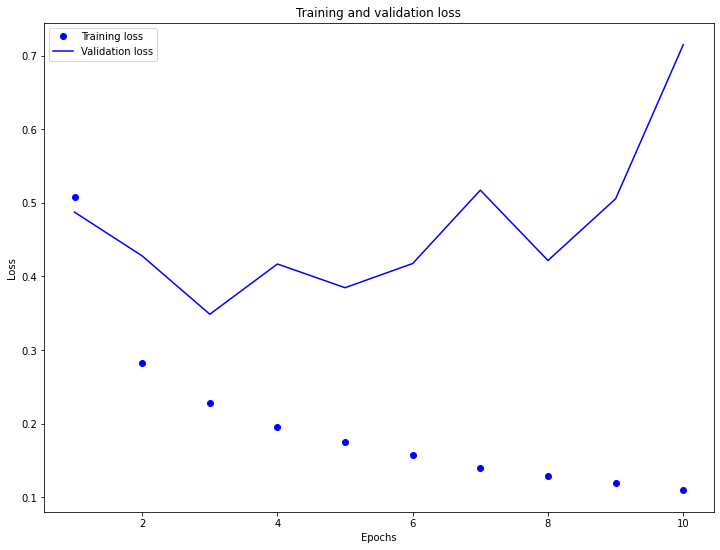

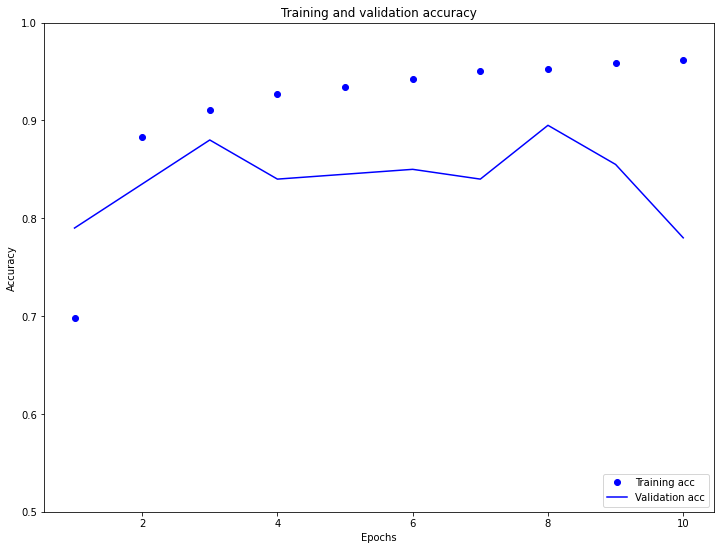

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## Retrieve the learned embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab_size, embedding-dimension)`.

In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


We will now write the weights to disk. To use the [Embedding Projector](http://projector.tensorflow.org), we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [15]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

If you are running this tutorial in [Colaboratory](https://colab.research.google.com), you can use the following snippet to download these files to your local machine (or use the file browser, *View -> Table of contents -> File browser*).

In [16]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualize the embeddings

To visualize our embeddings we will upload them to the embedding projector.

Open the [Embedding Projector](http://projector.tensorflow.org/) (this can also run in a local TensorBoard instance).

* Click on "Load data".

* Upload the two files we created above: `vecs.tsv` and `meta.tsv`.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful". 

Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.

Note: experimentally, you may be able to produce more interpretable embeddings by using a simpler model. Try deleting the `Dense(16)` layer, retraining the model, and visualizing the embeddings again.

<img src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>


## Next steps


This tutorial has shown you how to train and visualize word embeddings from scratch on a small dataset.

* To learn about recurrent networks see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).

* To learn more about text classification (including the overall workflow, and if you're curious about when to use embeddings vs one-hot encodings) we recommend this practical text classification [guide](https://developers.google.com/machine-learning/guides/text-classification/step-2-5).